# Deep Q-Learning 

Install dependencies for AI gym to run properly (shouldn't take more than a minute). If running on google cloud or running locally, only need to run once. Colab may require installing everytime the vm shuts down.

In [1]:
# !pip3 install gym pyvirtualdisplay
# !sudo apt-get install -y xvfb python-opengl ffmpeg

In [2]:
# !pip3 install --upgrade setuptools --user
# !pip3 install ez_setup 
# !pip3 install gym[atari] 
# !pip3 install gym[accept-rom-license] 

In [3]:
import torch
print(torch.cuda.is_available())  # Should return True if CUDA is available
print(torch.version.cuda)  # Should print 11.8
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"CUDA device: {device}")  # Expected output: "cuda:0" if GPU is available

True
11.8
CUDA device: cuda


For this assignment we will implement the Deep Q-Learning algorithm with Experience Replay as described in breakthrough paper __"Playing Atari with Deep Reinforcement Learning"__. We will train an agent to play the famous game of __Breakout__.

In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
# import gym
import gymnasium as gym
import ale_py
import pylab
import random
import numpy as np
from collections import deque
from datetime import datetime
from copy import deepcopy
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from utils import *
from model import *
from config import *
from checkpoint import *
import pickle
import os
import sys

import matplotlib.pyplot as plt


In [5]:
# Function to create metadata for checkpointing puposes
def create_metadata(agent, global_episode, global_frame, eval_rewards, rewards, episodes, last_10_ep_losses, loss_tracker, epsilon, q_stats_hist, qmean_win, qmin_win, qmax_win, beta=None, alpha=None):
    return {
    'global_episode': global_episode,
    'global_frame': global_frame,
    'batch_size': BATCH_SIZE,
    'sch_gamma': scheduler_gamma,
    'sch_step_size': scheduler_step_size,
    'tgt_update_freq': update_target_network_frequency,
    'memory capacity': Memory_capacity,  
    'explore steps': EXPLORE_STEPS, 
    'epsilon_decay_rate': agent.epsilon_decay_rate,
    'sticky_action_prob': sticky_action_prob,
    'eval_rewards': eval_rewards,
    'rewards': rewards,
    'episodes': episodes,
    'last_10_ep_losses': last_10_ep_losses,
    'loss_tracker': loss_tracker,
    'epislon': epsilon,
    'q_stats_hist': q_stats_hist,
    'qmean_win': qmean_win,
    'qmin_win': qmin_win,
    'qmax_win': qmax_win,
    'peralpha': alpha,
    'per_beta': beta,
    'lr': agent.scheduler.get_last_lr()[0],
    'scheduler_step': agent.scheduler.last_epoch
    }

In [ ]:
#Logger for outputing to jupyter notebook and log file simultaneously#
#Seems to break output when enabled and disabled.  Restart Kernel to discontinue use#

import sys
import os

class TeeLogger:
    def __init__(self, filepath):
        self.original_stdout = sys.__stdout__  # raw terminal (useful fallback)
        self.ipython_stdout = sys.stdout       # the notebook's visible output
        self.log = open(filepath, "w")

    def write(self, message):
        self.ipython_stdout.write(message)
        self.log.write(message)
        self.flush()

    def flush(self):
        self.ipython_stdout.flush()
        self.log.flush()

    def close(self):
        self.log.close()

## Understanding the environment

Unlike the UIlliniois assigment this code is based on, I will be using the Gymnasium (https://github.com/farama-Foundation/gymnasium) and the Atari Learning Environment (ALE, link here: https://ale.farama.org/), rather than gym, which has been deprecated.  We will still be playing Breakout on Atari.

To replecate BreakoutDeterministic-v4, as a starting point we'll use ALE/Breakout-v5 with frameskip=4, no "sticky actions" (i.e. deterministic actions), and a limited action space of NOOP, FIRE, LEFT, RIGHT.  However we won't be training on FIRE, instead we will ensure FIRE only happens when the game first starts and when a ball/life is lost.

In [7]:
# env = gym.make('BreakoutDeterministic-v4')
env = gym.make('ALE/Breakout-v5', frameskip=4, repeat_action_probability=0.0, full_action_space=False)  # Use equivalent parameters to BreakoutDeterministic-v4
state = env.reset()

A.L.E: Arcade Learning Environment (version 0.11.0+dfae0bd)
[Powered by Stella]


#### Test Env Frame Output

(185, 160, 3)
height:  185 width:  160


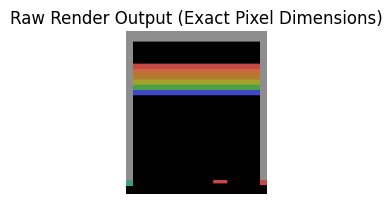

In [8]:
# Create environments
env = gym.make('ALE/Breakout-v5', frameskip=4, repeat_action_probability=sticky_action_prob, full_action_space=False, render_mode="rgb_array")

obs, info = env.reset()
frame = env.render()
frame = frame[20:-5, :, :]

# Calculate figure size in inches to match pixel size
height, width = frame.shape[:2]
print(frame.shape)
print("height: ", height, "width: ", width)
dpi = plt.rcParams['figure.dpi']
figsize = (width / dpi, height / dpi)

# Plot with exact pixel size
plt.figure(figsize=figsize, dpi=dpi)
plt.imshow(frame)
plt.title("Raw Render Output (Exact Pixel Dimensions)")
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()


In [9]:
number_lives = find_max_lives(env)
state_size = env.observation_space.shape
action_size = 3 #noop, left, and right.  Fire ball (action 1) is not trained

## Creating a DQN Agent

Here we create a DQN Agent. The basic agent is defined in the __agent.py__.  Additional agent versions are defined in __agent_double.py__, __agent_timediff.py__, __agent_dbl_timediff.py__.  Be careful to ensure the desired agent is imported below.  The corresponding neural networks (standard and branched) are defined in the __model.py__. 
__Evaluation Reward__ : The average reward received in the past 50 episodes/games.

__Frame__ : Number of frames processed in total.

__Memory Size__ : The current size of the replay memory.

### Create Replay Memory Pickle
The code below can be uncommented to run an existing agent and generate a pickle file that can be used to pre-seed the replay buffer in the training loop below, rather than starting from scratch and building it with a complete naive agent

In [10]:

# # ### Pickle Replay Creator ###
# from gymnasium.wrappers import RecordVideo
# from config import *


# mem_name = 'CircularPERBuffer_for_testing_using_Run13_orig_get_frame'

# #create fresh environment
# env = gym.make('ALE/Breakout-v5', frameskip=4, repeat_action_probability=sticky_action_prob, full_action_space=False, render_mode='rgb_array')
# # env = RecordVideo(env, video_folder="./videos", episode_trigger=lambda ep: ep % 20 == 0)  

# # Choose whether to use double DQN
# double_dqn = False # set to True if using double DQN agent
# if double_dqn:
#     from agent_double import Agent
# else:
#     from agent import Agent

# # print("Instantiating agent")
# agent = Agent(action_size)
# agent.load_policy_net("./save_model/run13/good_Run13_StdDQN_750K_frames_imprvdBatching_2477_eps.pth")
# agent.target_net.load_state_dict(agent.policy_net.state_dict())
# agent.epsilon = 0.1

# frame = 0   
# evaluation_reward = deque(maxlen=evaluation_reward_length)
# rewards, episodes = [], []
# best_eval_reward = 0
# exit_flag = False

# for e in range(EPISODES):
#     done = False
#     score = 0

#     history = np.zeros([5, 84, 84], dtype=np.uint8)
#     step = 0
#     state, _ = env.reset()
#     next_state = state
#     life = number_lives
#     fire_ready = True

#     get_init_state(history, state, HISTORY_SIZE)

#     while not done:
#         step += 1
#         frame += 1

#         # Selet Action (with robust check for FIRE action)
#         if fire_ready:
#             next_state, force_done = reset_after_life_loss(env, history)
#             if force_done:
#                 break
#             action = 1
#             fire_ready = False
#         else:
#             trainable_action = agent.get_action(np.float32(history[:4, :, :]) / 255.)
#             action = TRAINABLE_ACTIONS[trainable_action]

#         state = next_state
#         next_state, reward, terminations, truncations, info = env.step(action)  
#         done = truncations or terminations
#         frame_next_state = get_frame(next_state)
        

#         history[4, :, :] = frame_next_state
#         lost_life = check_live(life, info['lives'])  #check if the agent has lost a life

#         if lost_life:
#             fire_ready = True

#         life = info['lives']
#         r = reward

#         # Store the transition in memory if it was not a FIRE action
#         if action in TRAINABLE_ACTIONS:
#             trainable_index = TRAINABLE_ACTIONS.index(action)
#             term_state = done or lost_life
#             if type(agent.memory).__name__ == "CircularReplayMemoryPER":
#                 agent.memory.push(agent, deepcopy(frame_next_state), trainable_index, r, term_state)
#             else:
#                 agent.memory.push(deepcopy(frame_next_state), trainable_index, r, term_state)
#         # When replay buffer is filled save to pickle and break
#         if len(agent.memory) == train_frame:
#             print(f"Memory filled, saving pickle file") 
#             agent.save_replay_buffer(mem_name, frame)
#             exit_flag = True
#             break 
#         score += reward
#         history[:4, :, :] = history[1:, :, :]  # shift history by one erasing oldest frame

#         if frame % 500 == 0:
#             print("DEBUG: len(valid_flags), len(valid_indices), len(td_errors):", sum(agent.memory.valid_flags), len(agent.memory.valid_indices), len(agent.memory.td_errors))

#         if done:
#             fire_ready = True
#             evaluation_reward.append(score)
#             rewards.append(np.mean(evaluation_reward))  # record moving average of last evaluation_reward_length episodes
#             episodes.append(e)

#             # print episode information 
#             if e % 1 == 0:
#                 print("episode:", e, "  score:", score, "  memory length:",
#                   len(agent.memory), "  epsilon:", agent.epsilon, "  steps:", step,
#                   "  lr:", agent.optimizer.param_groups[0]['lr'], 
#                   "  evaluation reward:", np.mean(evaluation_reward))
#     if exit_flag:
#         break

In [11]:
# # Start logging
# log_file = "./test_log.txt"
# tee = TeeLogger(log_file)
# sys.stdout = tee
# sys.stderr = tee

# print(f"Logging started. Output will be written to both notebook and {log_file}")



In [ ]:
# # Stop logging safely
# !!!  This code doesn't really work properly as is !!!
# sys.stdout = tee.original_stdout
# sys.stderr = tee.original_stdout
# tee.close()

# print("This goes only to the notebook now.")

### Main Training Loop

In this training loop, we do not render the screen because it slows down training signficantly. To watch the agent play the game, run the code in next section "Visualize Agent Performance"

In [ ]:
## Setup Run Name and Memory Paths ##
mem_path = None
# mem_path = './checkpoints/CircularPERBuffer_for_testing_using_Run13_orig_get_frame_50498_replay_buffer.pkl'
# mem_path = './checkpoints/Run1_DQN_Serial_20pctExplore_and_Sticky_100000_replay_buffer.pkl'
# mem_path = './checkpoints/Buffer_for_testing_using_Run5_50K_replay_buffer.pkl'
# mem_path = './checkpoints/Buffer_for_testing_using_Run13_new_get_frame_100974_replay_buffer.pkl'
seed = 84

In [14]:
# log_dir = f"./logs/run{run_num}"
# os.makedirs(log_dir, exist_ok=True)
# log_file = os.path.join(log_dir, f"{run_name}_output.log")
# tee = TeeLogger(log_file)
# sys.stdout = tee
# sys.stderr = tee

# print(f"Logging started. Output will be written to both notebook and {log_file}")

/home/rbisker/miniconda3/envs/wsl_gym/lib/python3.12/site-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /mnt/c/Users/rbisk/Dropbox/GMU/cs747 Deep Learning/Final_Project/Illinois_hw/videos/run18 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/tmp/ipykernel_89518/1620411452.py:78: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly a

Starting run Run18_Bootstrapped_run17_stickyactions5percent
Instantiating agent
Replay buffer loaded from './checkpoints/Run17_StdDQN_750Kfr_newest_get_frame_CirularPER_wIS_159356_replay_buffer.pkl' with size 204356
Updated memory capacity to  1000000
epsilon max:  1.0 epsilon min:  0.1 epsilon_decay:  3e-06
[SANITIZER] Fixing 0 invalid or nonpositive TD-errors...
OptimizedModule(
  (_orig_mod): DQN(
    (conv1): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc): Linear(in_features=3136, out_features=512, bias=True)
    (head): Linear(in_features=512, out_features=3, bias=True)
  )
)
Co

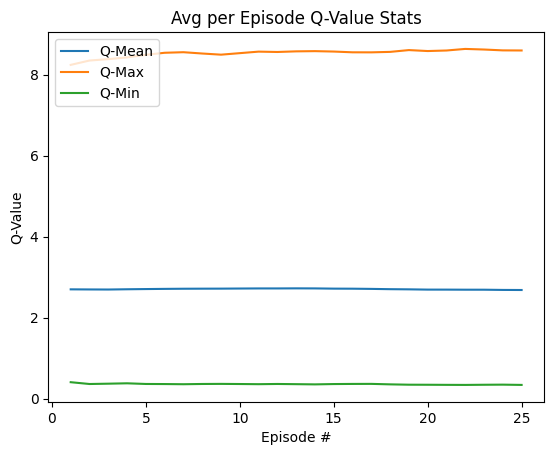

[PER STATS] TD-error mean: 0.06908688102822133 std: 0.1297927217120833 min: 0.0 max: 3.638671875
episode: 26   frame: 4055   proc time: 11.5s   score: 0.0   memory length: 208281   epsilon: 0.98784   steps: 120 steps/sec: 10.42   lr: 0.0005   PER_beta: 0.40324 PER Alpha: 0.59676   reward MA: 1.0   mean loss: 0.02514   mean max Q: 8.6879
episode: 27   frame: 4233   proc time: 16.8s   score: 2.0   memory length: 208454   epsilon: 0.9873   steps: 178 steps/sec: 10.58   lr: 0.0005   PER_beta: 0.40339 PER Alpha: 0.59661   reward MA: 1.037   mean loss: 0.02564   mean max Q: 8.4345
episode: 28   frame: 4456   proc time: 21.3s   score: 3.0   memory length: 208672   epsilon: 0.98663   steps: 223 steps/sec: 10.45   lr: 0.0005   PER_beta: 0.40356 PER Alpha: 0.59644   reward MA: 1.107   mean loss: 0.02277   mean max Q: 8.6832
episode: 29   frame: 4576   proc time: 11.5s   score: 0.0   memory length: 208787   epsilon: 0.98627   steps: 120 steps/sec: 10.46   lr: 0.0005   PER_beta: 0.40366 PER Alpha:

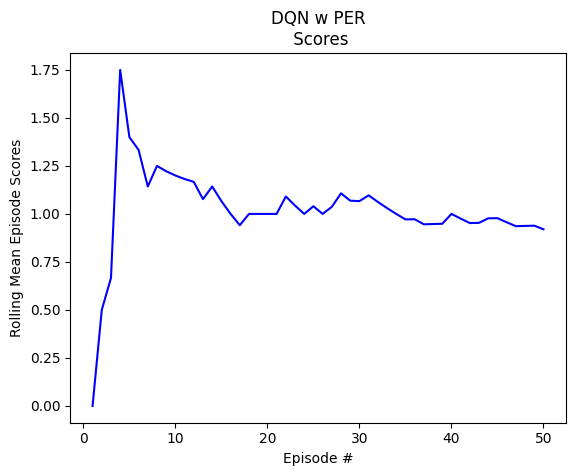

[SAVED PLOT] ./save_graph/run18/Run18_Bootstrapped_run17_stickyactions5percent_ep50_losses.png


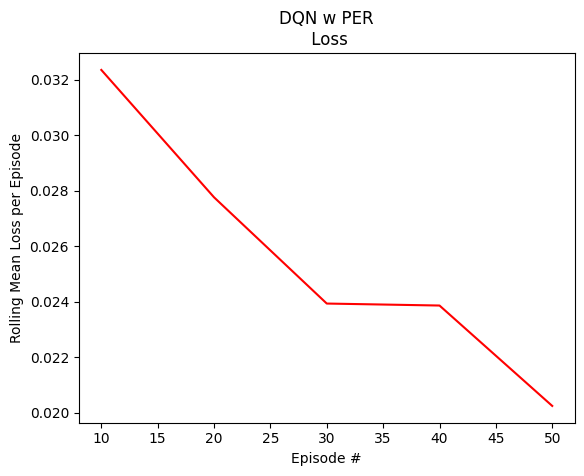

[SAVED PLOT] ./save_graph/run18/Run18_Bootstrapped_run17_stickyactions5percent_ep50_Qstats.png


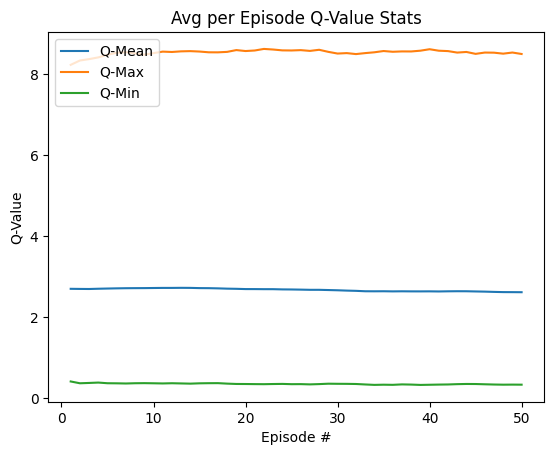

episode: 51   frame: 7729   proc time: 14.9s   score: 1.0   memory length: 211830   epsilon: 0.97681   steps: 148 steps/sec: 9.93   lr: 0.0005   PER_beta: 0.40618 PER Alpha: 0.59382   reward MA: 0.94   mean loss: 0.01797   mean max Q: 8.6183
episode: 52   frame: 7898   proc time: 16.9s   score: 1.0   memory length: 211994   epsilon: 0.97631   steps: 169 steps/sec: 9.99   lr: 0.0005   PER_beta: 0.40632 PER Alpha: 0.59368   reward MA: 0.94   mean loss: 0.0204   mean max Q: 8.848
[PER STATS] TD-error mean: 0.06486456846757702 std: 0.11760409257996729 min: 0.0 max: 3.111328125
episode: 53   frame: 8018   proc time: 12.2s   score: 0.0   memory length: 212109   epsilon: 0.97595   steps: 120 steps/sec: 9.85   lr: 0.0005   PER_beta: 0.40641 PER Alpha: 0.59359   reward MA: 0.92   mean loss: 0.01899   mean max Q: 8.8331
episode: 54   frame: 8138   proc time: 12.2s   score: 0.0   memory length: 212224   epsilon: 0.97559   steps: 120 steps/sec: 9.84   lr: 0.0005   PER_beta: 0.40651 PER Alpha: 0.59

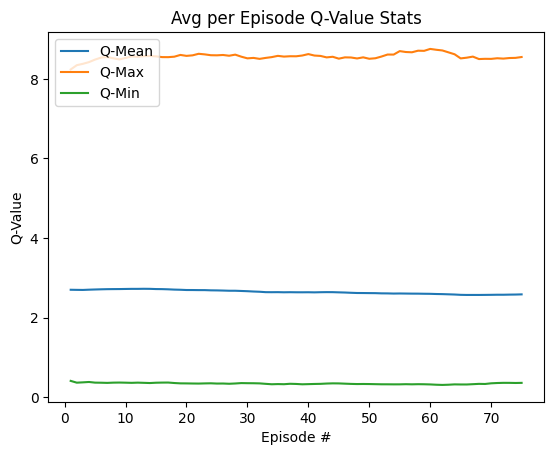

episode: 76   frame: 11532   proc time: 17.4s   score: 1.0   memory length: 215508   epsilon: 0.9654   steps: 168 steps/sec: 9.64   lr: 0.0005   PER_beta: 0.40923 PER Alpha: 0.59077   reward MA: 0.86   mean loss: 0.01929   mean max Q: 8.5338
episode: 77   frame: 11652   proc time: 12.3s   score: 0.0   memory length: 215623   epsilon: 0.96504   steps: 120 steps/sec: 9.73   lr: 0.0005   PER_beta: 0.40932 PER Alpha: 0.59068   reward MA: 0.82   mean loss: 0.01771   mean max Q: 8.539
episode: 78   frame: 11848   proc time: 20.5s   score: 2.0   memory length: 215814   epsilon: 0.96446   steps: 196 steps/sec: 9.57   lr: 0.0005   PER_beta: 0.40948 PER Alpha: 0.59052   reward MA: 0.8   mean loss: 0.01836   mean max Q: 8.4023
episode: 79   frame: 11968   proc time: 12.4s   score: 0.0   memory length: 215929   epsilon: 0.9641   steps: 120 steps/sec: 9.69   lr: 0.0005   PER_beta: 0.40957 PER Alpha: 0.59043   reward MA: 0.8   mean loss: 0.01773   mean max Q: 8.3032
[PER STATS] TD-error mean: 0.0632

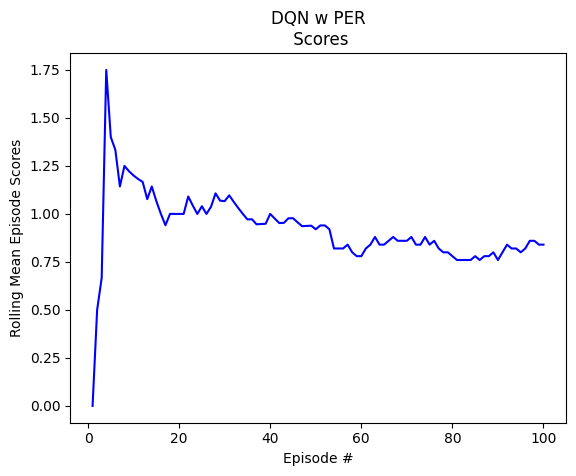

[SAVED PLOT] ./save_graph/run18/Run18_Bootstrapped_run17_stickyactions5percent_ep100_losses.png


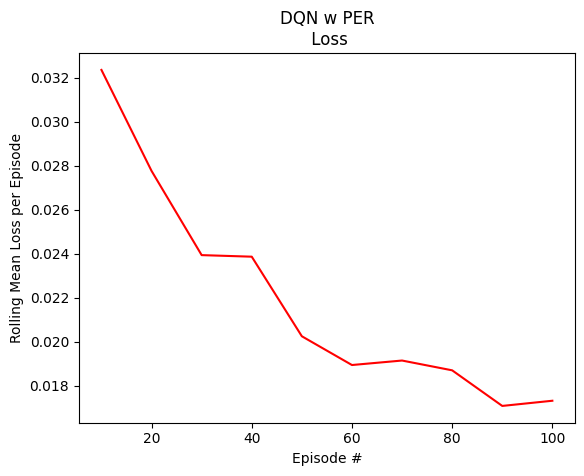

[SAVED PLOT] ./save_graph/run18/Run18_Bootstrapped_run17_stickyactions5percent_ep100_Qstats.png


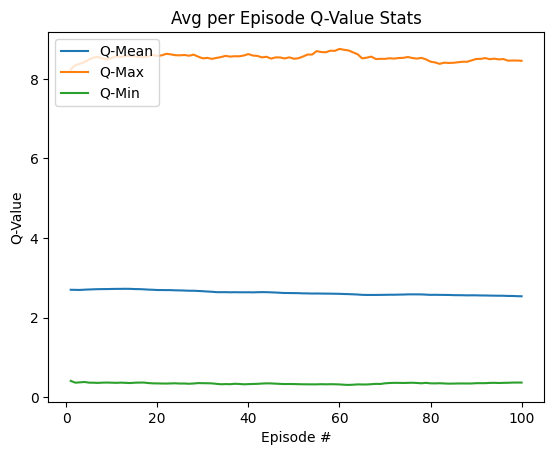

Checkpoint for episode 100 saved
episode: 101   frame: 15310   proc time: 23.4s   score: 2.0   memory length: 219161   epsilon: 0.95407   steps: 219 steps/sec: 9.37   lr: 0.0005   PER_beta: 0.41225 PER Alpha: 0.58775   reward MA: 0.86   mean loss: 0.01921   mean max Q: 8.2792
episode: 102   frame: 15458   proc time: 16.0s   score: 1.0   memory length: 219304   epsilon: 0.95363   steps: 148 steps/sec: 9.26   lr: 0.0005   PER_beta: 0.41237 PER Alpha: 0.58763   reward MA: 0.86   mean loss: 0.02277   mean max Q: 8.392
episode: 103   frame: 15684   proc time: 24.4s   score: 3.0   memory length: 219525   epsilon: 0.95295   steps: 226 steps/sec: 9.28   lr: 0.0005   PER_beta: 0.41255 PER Alpha: 0.58745   reward MA: 0.92   mean loss: 0.01878   mean max Q: 8.3828
episode: 104   frame: 15899   proc time: 23.1s   score: 2.0   memory length: 219735   epsilon: 0.9523   steps: 215 steps/sec: 9.3   lr: 0.0005   PER_beta: 0.41272 PER Alpha: 0.58728   reward MA: 0.96   mean loss: 0.01728   mean max Q: 8

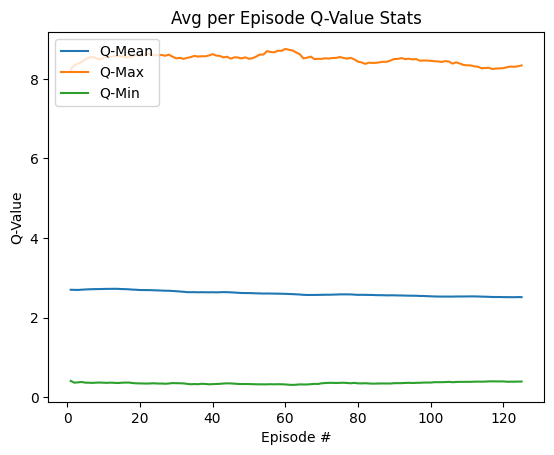

episode: 126   frame: 19510   proc time: 18.4s   score: 1.0   memory length: 223236   epsilon: 0.94147   steps: 168 steps/sec: 9.13   lr: 0.0005   PER_beta: 0.41561 PER Alpha: 0.58439   reward MA: 1.08   mean loss: 0.01518   mean max Q: 8.3293
episode: 127   frame: 19719   proc time: 23.1s   score: 3.0   memory length: 223440   epsilon: 0.94084   steps: 209 steps/sec: 9.06   lr: 0.0005   PER_beta: 0.41578 PER Alpha: 0.58422   reward MA: 1.14   mean loss: 0.01548   mean max Q: 8.1238
episode: 128   frame: 19867   proc time: 16.1s   score: 1.0   memory length: 223583   epsilon: 0.9404   steps: 148 steps/sec: 9.17   lr: 0.0005   PER_beta: 0.41589 PER Alpha: 0.58411   reward MA: 1.12   mean loss: 0.01576   mean max Q: 8.5636
Target network updated at frame:  20000
[PER STATS] TD-error mean: 0.05888960689595393 std: 0.10876338016511378 min: 0.0 max: 2.61328125
episode: 129   frame: 20015   proc time: 16.6s   score: 1.0   memory length: 223726   epsilon: 0.93996   steps: 148 steps/sec: 8.91 

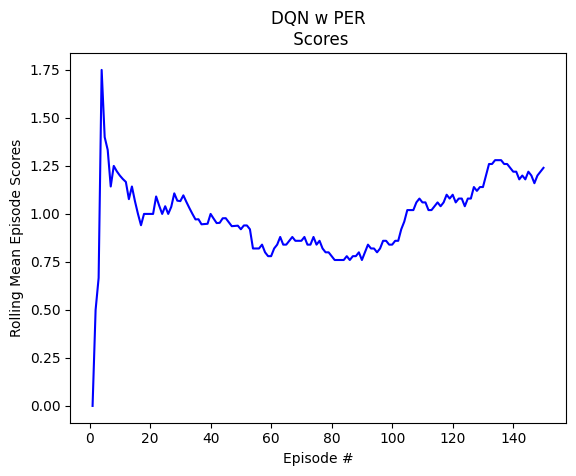

[SAVED PLOT] ./save_graph/run18/Run18_Bootstrapped_run17_stickyactions5percent_ep150_losses.png


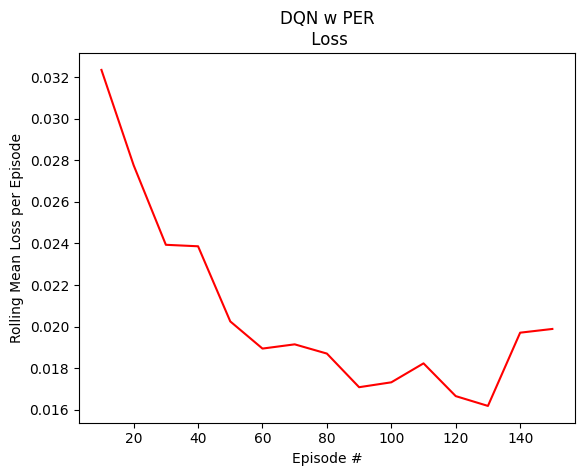

[SAVED PLOT] ./save_graph/run18/Run18_Bootstrapped_run17_stickyactions5percent_ep150_Qstats.png


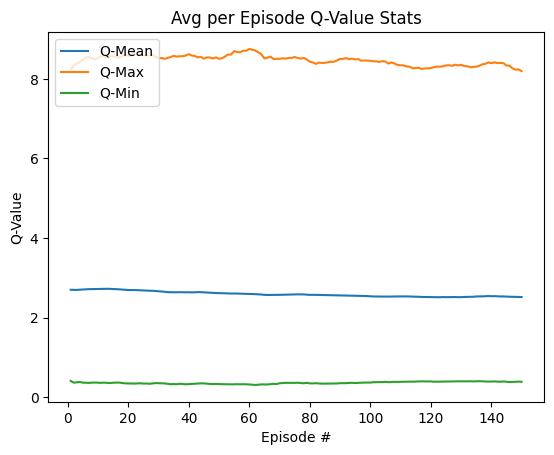

episode: 151   frame: 23354   proc time: 16.9s   score: 1.0   memory length: 226955   epsilon: 0.92994   steps: 148 steps/sec: 8.76   lr: 0.0005   PER_beta: 0.41868 PER Alpha: 0.58132   reward MA: 1.22   mean loss: 0.01852   mean max Q: 8.1547
episode: 152   frame: 23474   proc time: 13.4s   score: 0.0   memory length: 227070   epsilon: 0.92958   steps: 120 steps/sec: 8.96   lr: 0.0005   PER_beta: 0.41878 PER Alpha: 0.58122   reward MA: 1.2   mean loss: 0.01852   mean max Q: 8.6209
episode: 153   frame: 23622   proc time: 16.8s   score: 1.0   memory length: 227213   epsilon: 0.92913   steps: 148 steps/sec: 8.83   lr: 0.0005   PER_beta: 0.4189 PER Alpha: 0.5811   reward MA: 1.16   mean loss: 0.01674   mean max Q: 8.156
episode: 154   frame: 23742   proc time: 13.5s   score: 0.0   memory length: 227328   epsilon: 0.92877   steps: 120 steps/sec: 8.91   lr: 0.0005   PER_beta: 0.41899 PER Alpha: 0.58101   reward MA: 1.12   mean loss: 0.01943   mean max Q: 8.0209
episode: 155   frame: 23862 

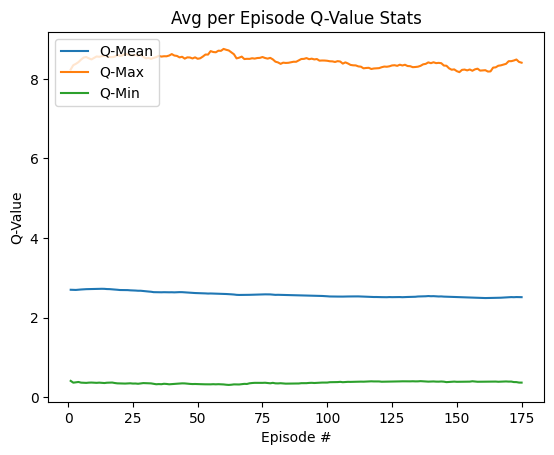

episode: 176   frame: 27375   proc time: 17.1s   score: 1.0   memory length: 230851   epsilon: 0.91788   steps: 148 steps/sec: 8.64   lr: 0.0005   PER_beta: 0.4219 PER Alpha: 0.5781   reward MA: 1.14   mean loss: 0.02876   mean max Q: 8.4104
episode: 177   frame: 27572   proc time: 23.0s   score: 2.0   memory length: 231043   epsilon: 0.91728   steps: 197 steps/sec: 8.57   lr: 0.0005   PER_beta: 0.42206 PER Alpha: 0.57794   reward MA: 1.12   mean loss: 0.02691   mean max Q: 8.0756
episode: 178   frame: 27721   proc time: 17.3s   score: 1.0   memory length: 231187   epsilon: 0.91684   steps: 149 steps/sec: 8.61   lr: 0.0005   PER_beta: 0.42218 PER Alpha: 0.57782   reward MA: 1.12   mean loss: 0.03107   mean max Q: 8.3291
episode: 179   frame: 27946   proc time: 26.1s   score: 3.0   memory length: 231407   epsilon: 0.91616   steps: 225 steps/sec: 8.62   lr: 0.0005   PER_beta: 0.42236 PER Alpha: 0.57764   reward MA: 1.16   mean loss: 0.02896   mean max Q: 8.2548
[PER STATS] TD-error mean:

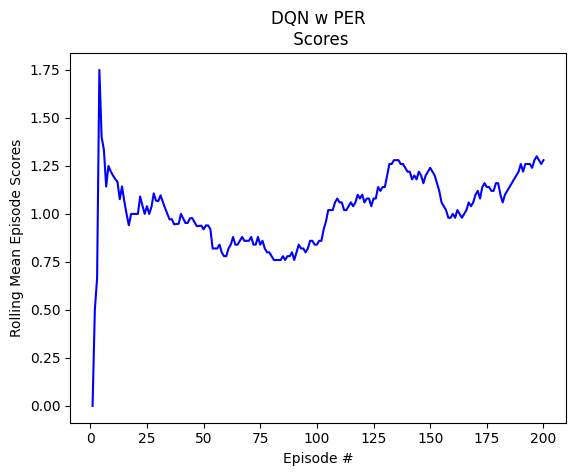

[SAVED PLOT] ./save_graph/run18/Run18_Bootstrapped_run17_stickyactions5percent_ep200_losses.png


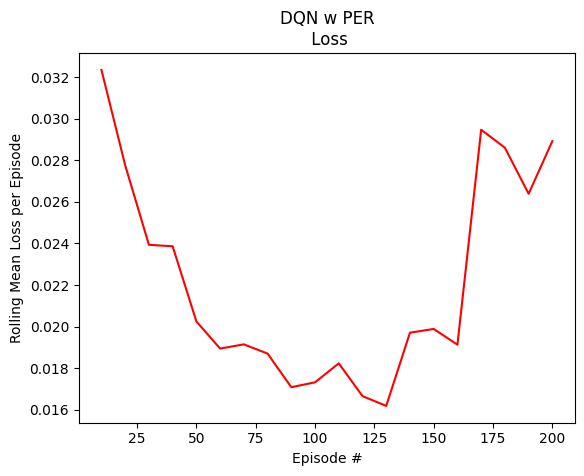

[SAVED PLOT] ./save_graph/run18/Run18_Bootstrapped_run17_stickyactions5percent_ep200_Qstats.png


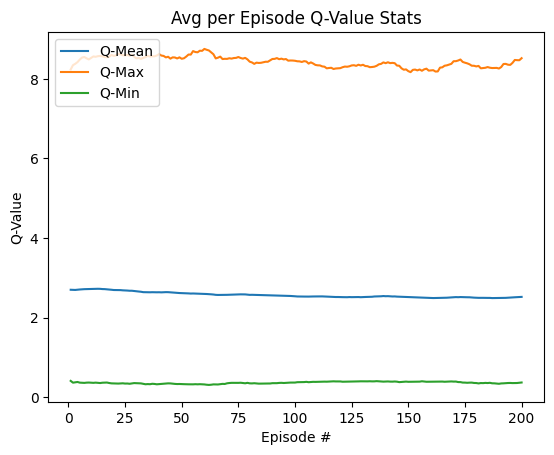

Checkpoint for episode 200 saved
Replay buffer of 234758 frames saved
episode: 201   frame: 31598   proc time: 24.1s   score: 2.0   memory length: 234949   epsilon: 0.90521   steps: 196 steps/sec: 8.15   lr: 0.0005   PER_beta: 0.42528 PER Alpha: 0.57472   reward MA: 1.3   mean loss: 0.02804   mean max Q: 8.3168
episode: 202   frame: 31746   proc time: 17.8s   score: 1.0   memory length: 235092   epsilon: 0.90476   steps: 148 steps/sec: 8.3   lr: 0.0005   PER_beta: 0.4254 PER Alpha: 0.5746   reward MA: 1.32   mean loss: 0.02678   mean max Q: 8.661
episode: 203   frame: 31866   proc time: 14.3s   score: 0.0   memory length: 235207   epsilon: 0.9044   steps: 120 steps/sec: 8.4   lr: 0.0005   PER_beta: 0.42549 PER Alpha: 0.57451   reward MA: 1.3   mean loss: 0.02712   mean max Q: 7.9808
[PER STATS] TD-error mean: 0.06670186719103663 std: 0.1354674584530585 min: 0.0 max: 4.009765625
episode: 204   frame: 32014   proc time: 18.0s   score: 1.0   memory length: 235350   epsilon: 0.90396   step

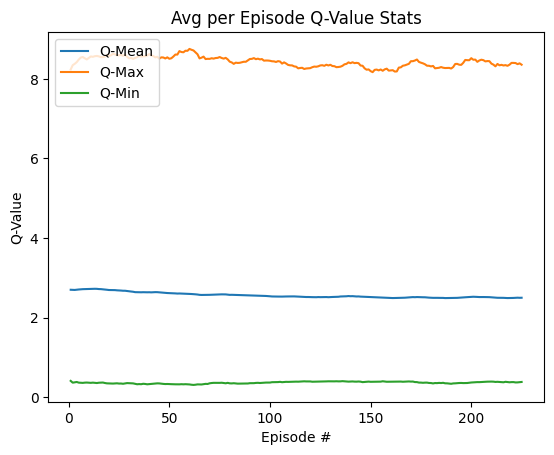

[PER STATS] TD-error mean: 0.0666543189252241 std: 0.13004460753951694 min: 0.0 max: 3.18359375
episode: 226   frame: 36019   proc time: 20.9s   score: 1.0   memory length: 239245   epsilon: 0.89194   steps: 168 steps/sec: 8.05   lr: 0.0005   PER_beta: 0.42882 PER Alpha: 0.57118   reward MA: 1.5   mean loss: 0.02304   mean max Q: 8.1958
episode: 227   frame: 36216   proc time: 24.3s   score: 2.0   memory length: 239437   epsilon: 0.89135   steps: 197 steps/sec: 8.1   lr: 0.0005   PER_beta: 0.42897 PER Alpha: 0.57103   reward MA: 1.5   mean loss: 0.023   mean max Q: 8.2078
episode: 228   frame: 36431   proc time: 26.4s   score: 2.0   memory length: 239647   epsilon: 0.89071   steps: 215 steps/sec: 8.13   lr: 0.0005   PER_beta: 0.42914 PER Alpha: 0.57086   reward MA: 1.52   mean loss: 0.02394   mean max Q: 8.2273
episode: 229   frame: 36579   proc time: 18.3s   score: 1.0   memory length: 239790   epsilon: 0.89026   steps: 148 steps/sec: 8.11   lr: 0.0005   PER_beta: 0.42926 PER Alpha: 0

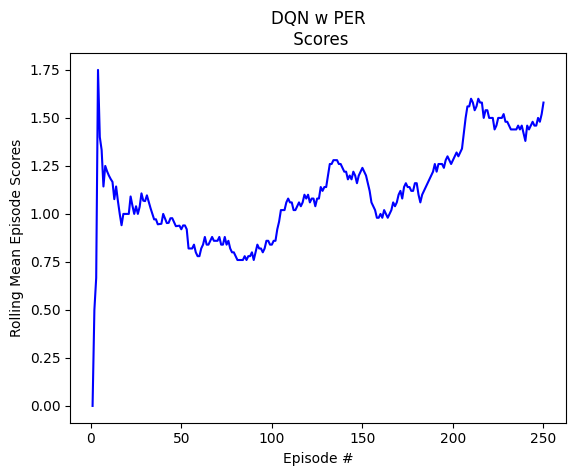

[SAVED PLOT] ./save_graph/run18/Run18_Bootstrapped_run17_stickyactions5percent_ep250_losses.png


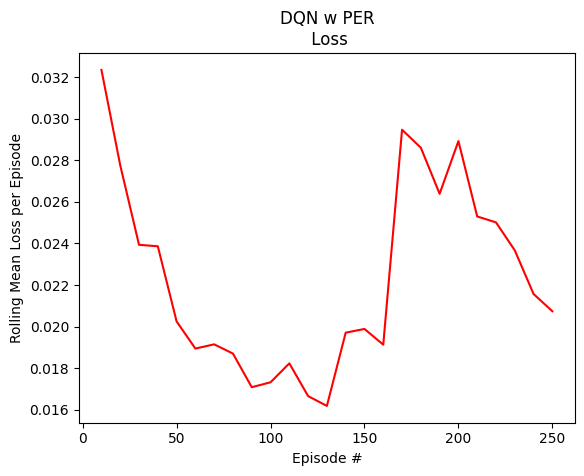

[SAVED PLOT] ./save_graph/run18/Run18_Bootstrapped_run17_stickyactions5percent_ep250_Qstats.png


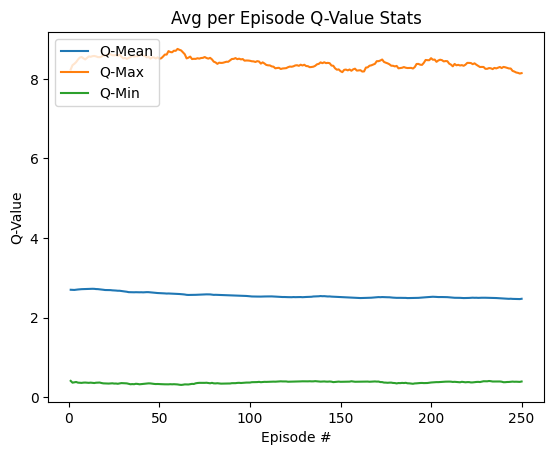

episode: 251   frame: 40409   proc time: 15.0s   score: 0.0   memory length: 243510   epsilon: 0.87877   steps: 120 steps/sec: 8.02   lr: 0.0005   PER_beta: 0.43233 PER Alpha: 0.56767   reward MA: 1.54   mean loss: 0.02788   mean max Q: 8.3147
episode: 252   frame: 40557   proc time: 18.7s   score: 1.0   memory length: 243653   epsilon: 0.87833   steps: 148 steps/sec: 7.93   lr: 0.0005   PER_beta: 0.43245 PER Alpha: 0.56755   reward MA: 1.54   mean loss: 0.02524   mean max Q: 8.3321
episode: 253   frame: 40753   proc time: 24.6s   score: 2.0   memory length: 243844   epsilon: 0.87774   steps: 196 steps/sec: 7.95   lr: 0.0005   PER_beta: 0.4326 PER Alpha: 0.5674   reward MA: 1.58   mean loss: 0.02383   mean max Q: 8.4241
episode: 254   frame: 40873   proc time: 15.1s   score: 0.0   memory length: 243959   epsilon: 0.87738   steps: 120 steps/sec: 7.93   lr: 0.0005   PER_beta: 0.4327 PER Alpha: 0.5673   reward MA: 1.56   mean loss: 0.02217   mean max Q: 8.7439
episode: 255   frame: 40993 

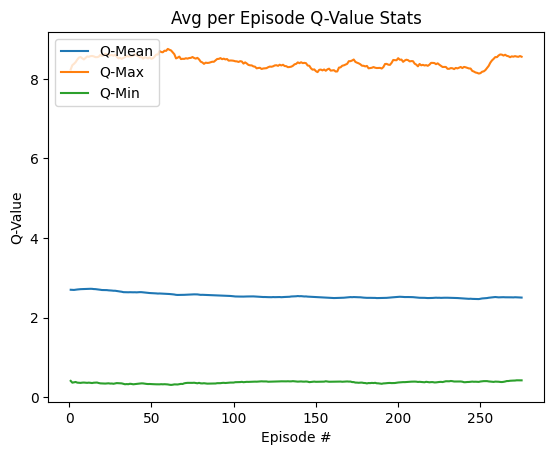

episode: 276   frame: 44661   proc time: 43.5s   score: 6.0   memory length: 247637   epsilon: 0.86602   steps: 335 steps/sec: 7.7   lr: 0.0005   PER_beta: 0.43573 PER Alpha: 0.56427   reward MA: 1.5   mean loss: 0.02062   mean max Q: 8.6545
episode: 277   frame: 44937   proc time: 36.2s   score: 4.0   memory length: 247908   epsilon: 0.86519   steps: 276 steps/sec: 7.63   lr: 0.0005   PER_beta: 0.43595 PER Alpha: 0.56405   reward MA: 1.54   mean loss: 0.01941   mean max Q: 8.4995
Target network updated at frame:  45000
[PER STATS] TD-error mean: 0.0661119297662168 std: 0.12547393055156464 min: 0.0 max: 2.9755859375
episode: 278   frame: 45085   proc time: 19.4s   score: 1.0   memory length: 248051   epsilon: 0.86475   steps: 148 steps/sec: 7.61   lr: 0.0005   PER_beta: 0.43607 PER Alpha: 0.56393   reward MA: 1.52   mean loss: 0.01928   mean max Q: 8.8115
episode: 279   frame: 45233   proc time: 22.3s   score: 1.0   memory length: 248194   epsilon: 0.8643   steps: 148 steps/sec: 6.65  

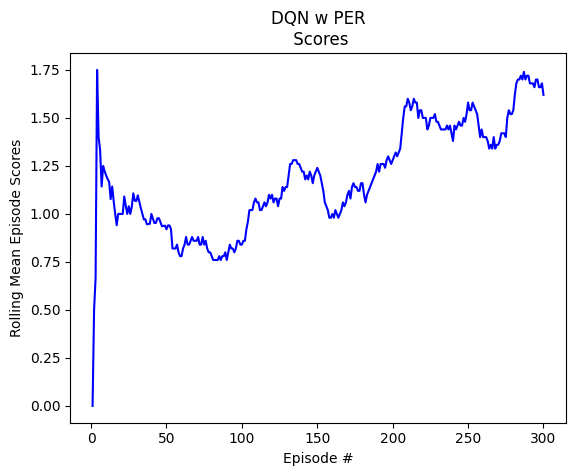

[SAVED PLOT] ./save_graph/run18/Run18_Bootstrapped_run17_stickyactions5percent_ep300_losses.png


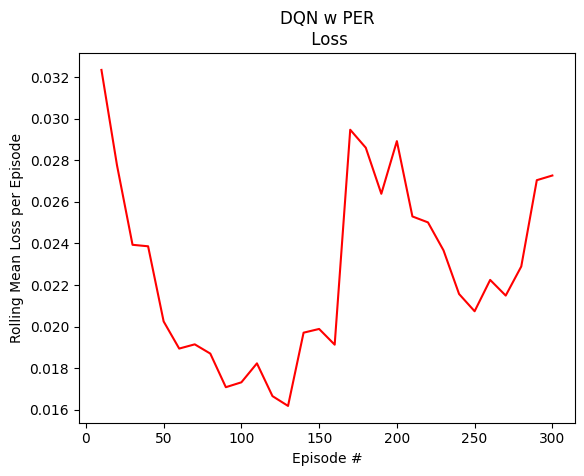

[SAVED PLOT] ./save_graph/run18/Run18_Bootstrapped_run17_stickyactions5percent_ep300_Qstats.png


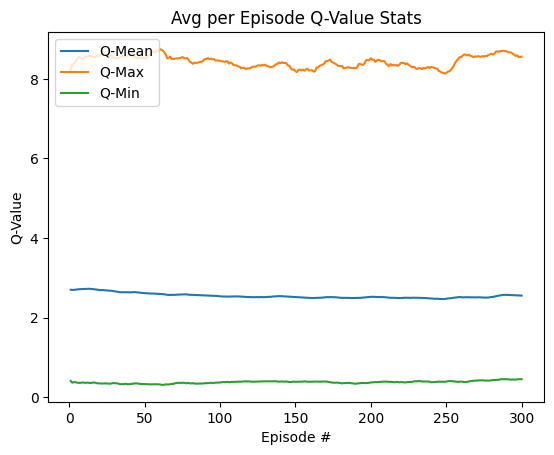

Checkpoint for episode 300 saved
episode: 301   frame: 49168   proc time: 20.6s   score: 1.0   memory length: 252019   epsilon: 0.8525   steps: 148 steps/sec: 7.19   lr: 0.0005   PER_beta: 0.43933 PER Alpha: 0.56067   reward MA: 1.64   mean loss: 0.02681   mean max Q: 8.6942
episode: 302   frame: 49288   proc time: 16.7s   score: 0.0   memory length: 252134   epsilon: 0.85214   steps: 120 steps/sec: 7.18   lr: 0.0005   PER_beta: 0.43943 PER Alpha: 0.56057   reward MA: 1.62   mean loss: 0.02526   mean max Q: 8.8342
episode: 303   frame: 49408   proc time: 16.7s   score: 0.0   memory length: 252249   epsilon: 0.85178   steps: 120 steps/sec: 7.18   lr: 0.0005   PER_beta: 0.43953 PER Alpha: 0.56047   reward MA: 1.58   mean loss: 0.02757   mean max Q: 8.4917
episode: 304   frame: 49615   proc time: 28.7s   score: 3.0   memory length: 252451   epsilon: 0.85116   steps: 207 steps/sec: 7.21   lr: 0.0005   PER_beta: 0.43969 PER Alpha: 0.56031   reward MA: 1.64   mean loss: 0.0283   mean max Q: 

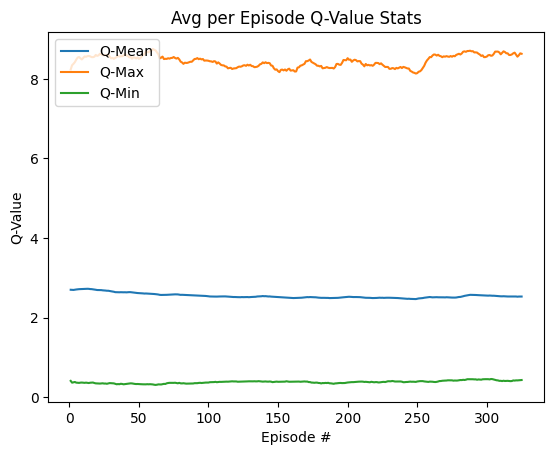

episode: 326   frame: 53196   proc time: 16.5s   score: 0.0   memory length: 255922   epsilon: 0.84041   steps: 120 steps/sec: 7.29   lr: 0.0005   PER_beta: 0.44256 PER Alpha: 0.55744   reward MA: 1.54   mean loss: 0.02854   mean max Q: 8.605
episode: 327   frame: 53344   proc time: 20.4s   score: 1.0   memory length: 256065   epsilon: 0.83997   steps: 148 steps/sec: 7.25   lr: 0.0005   PER_beta: 0.44268 PER Alpha: 0.55732   reward MA: 1.48   mean loss: 0.03004   mean max Q: 8.7208
episode: 328   frame: 53521   proc time: 24.2s   score: 2.0   memory length: 256237   epsilon: 0.83944   steps: 177 steps/sec: 7.31   lr: 0.0005   PER_beta: 0.44282 PER Alpha: 0.55718   reward MA: 1.5   mean loss: 0.0258   mean max Q: 8.4668
episode: 329   frame: 53689   proc time: 23.0s   score: 1.0   memory length: 256400   epsilon: 0.83893   steps: 168 steps/sec: 7.32   lr: 0.0005   PER_beta: 0.44295 PER Alpha: 0.55705   reward MA: 1.5   mean loss: 0.02585   mean max Q: 8.5973
episode: 330   frame: 53809 

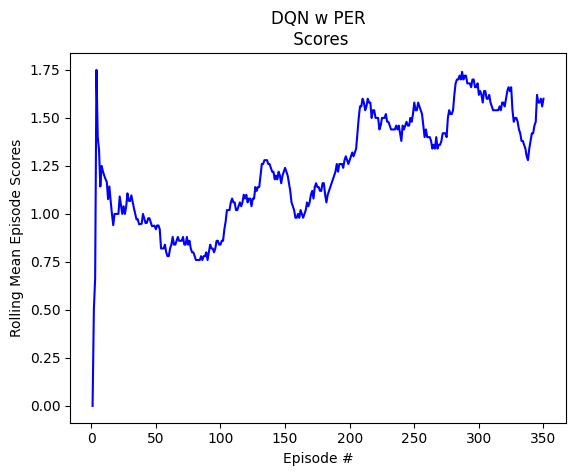

[SAVED PLOT] ./save_graph/run18/Run18_Bootstrapped_run17_stickyactions5percent_ep350_losses.png


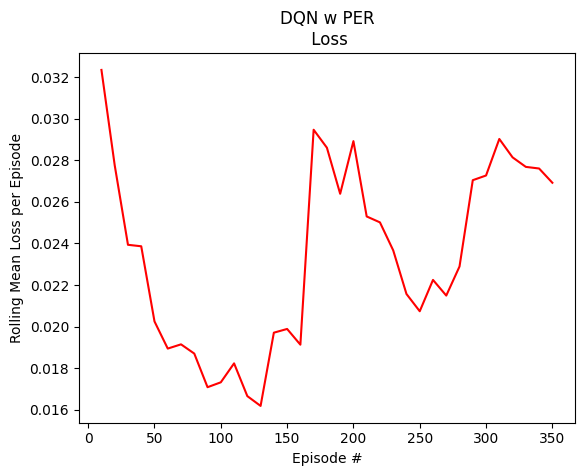

[SAVED PLOT] ./save_graph/run18/Run18_Bootstrapped_run17_stickyactions5percent_ep350_Qstats.png


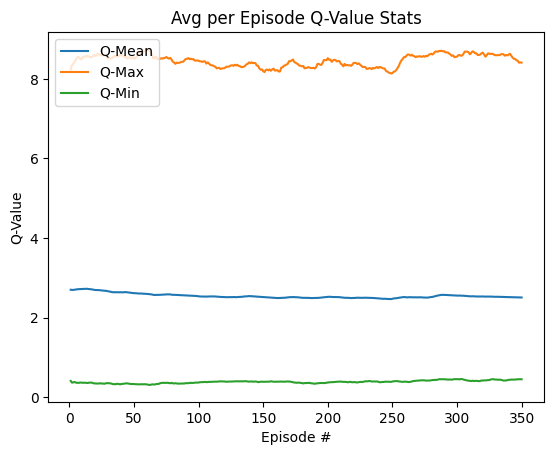

episode: 351   frame: 57694   proc time: 28.0s   score: 2.0   memory length: 260295   epsilon: 0.82692   steps: 197 steps/sec: 7.05   lr: 0.0005   PER_beta: 0.44616 PER Alpha: 0.55384   reward MA: 1.62   mean loss: 0.02639   mean max Q: 8.2598
episode: 352   frame: 57920   proc time: 31.7s   score: 3.0   memory length: 260516   epsilon: 0.82624   steps: 226 steps/sec: 7.12   lr: 0.0005   PER_beta: 0.44634 PER Alpha: 0.55366   reward MA: 1.68   mean loss: 0.0265   mean max Q: 8.3247
[PER STATS] TD-error mean: 0.06975313761581736 std: 0.14145936429082295 min: 0.0 max: 4.0908203125
episode: 353   frame: 58040   proc time: 17.0s   score: 0.0   memory length: 260631   epsilon: 0.82588   steps: 120 steps/sec: 7.07   lr: 0.0005   PER_beta: 0.44643 PER Alpha: 0.55357   reward MA: 1.68   mean loss: 0.02699   mean max Q: 8.6094
episode: 354   frame: 58188   proc time: 21.1s   score: 1.0   memory length: 260774   epsilon: 0.82544   steps: 148 steps/sec: 7.02   lr: 0.0005   PER_beta: 0.44655 PER A

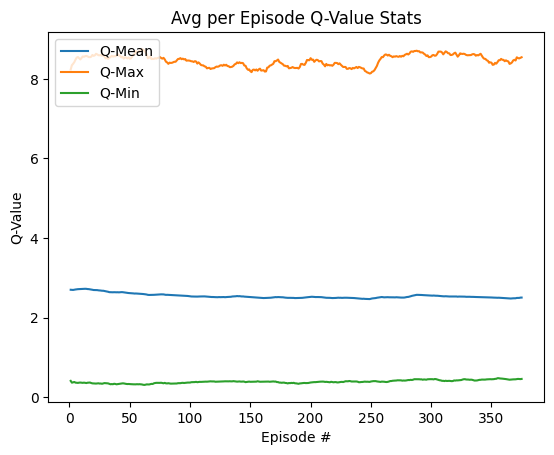

episode: 376   frame: 62289   proc time: 30.9s   score: 2.0   memory length: 264765   epsilon: 0.81313   steps: 214 steps/sec: 6.92   lr: 0.0005   PER_beta: 0.44983 PER Alpha: 0.55017   reward MA: 1.92   mean loss: 0.02025   mean max Q: 8.2556
episode: 377   frame: 62466   proc time: 25.4s   score: 2.0   memory length: 264937   epsilon: 0.8126   steps: 177 steps/sec: 6.97   lr: 0.0005   PER_beta: 0.44997 PER Alpha: 0.55003   reward MA: 1.94   mean loss: 0.02162   mean max Q: 8.484
episode: 378   frame: 62643   proc time: 29.1s   score: 2.0   memory length: 265109   epsilon: 0.81207   steps: 177 steps/sec: 6.08   lr: 0.0005   PER_beta: 0.45011 PER Alpha: 0.54989   reward MA: 1.94   mean loss: 0.02299   mean max Q: 8.409
episode: 379   frame: 62840   proc time: 28.2s   score: 2.0   memory length: 265301   epsilon: 0.81148   steps: 197 steps/sec: 6.99   lr: 0.0005   PER_beta: 0.45027 PER Alpha: 0.54973   reward MA: 1.96   mean loss: 0.02195   mean max Q: 8.3637
episode: 380   frame: 62988

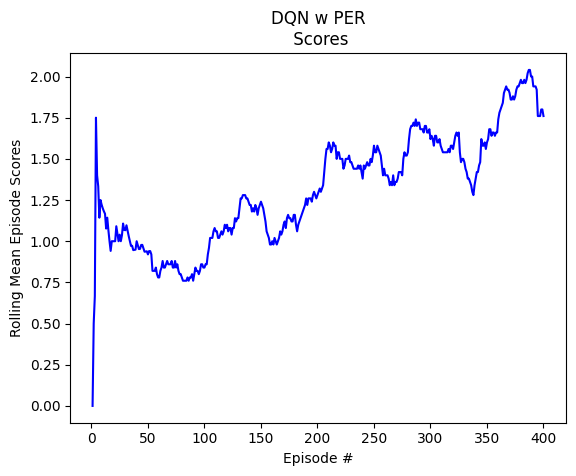

[SAVED PLOT] ./save_graph/run18/Run18_Bootstrapped_run17_stickyactions5percent_ep400_losses.png


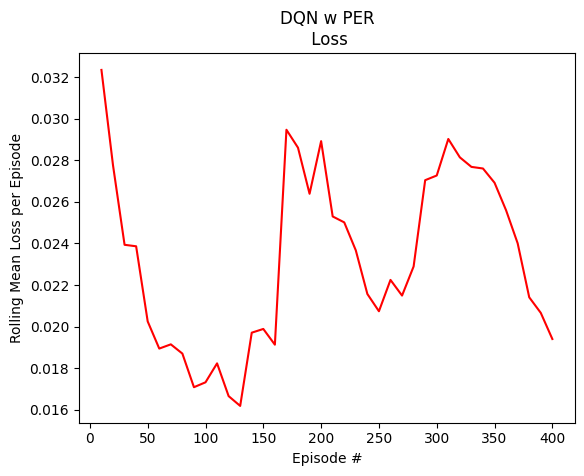

[SAVED PLOT] ./save_graph/run18/Run18_Bootstrapped_run17_stickyactions5percent_ep400_Qstats.png


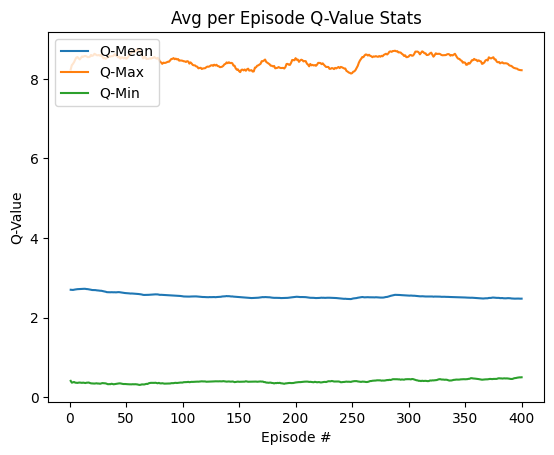

Checkpoint for episode 400 saved
Replay buffer of 268979 frames saved
episode: 401   frame: 66838   proc time: 30.9s   score: 2.0   memory length: 269189   epsilon: 0.79949   steps: 215 steps/sec: 6.96   lr: 0.0005   PER_beta: 0.45347 PER Alpha: 0.54653   reward MA: 1.76   mean loss: 0.01711   mean max Q: 8.0561
episode: 402   frame: 66986   proc time: 20.8s   score: 1.0   memory length: 269332   epsilon: 0.79904   steps: 148 steps/sec: 7.11   lr: 0.0005   PER_beta: 0.45359 PER Alpha: 0.54641   reward MA: 1.72   mean loss: 0.01904   mean max Q: 8.0885
[PER STATS] TD-error mean: 0.0663358770984756 std: 0.12222449874031624 min: 0.0 max: 3.3515625
episode: 403   frame: 67154   proc time: 23.6s   score: 1.0   memory length: 269495   epsilon: 0.79854   steps: 168 steps/sec: 7.11   lr: 0.0005   PER_beta: 0.45372 PER Alpha: 0.54628   reward MA: 1.74   mean loss: 0.01838   mean max Q: 8.181
episode: 404   frame: 67362   proc time: 29.4s   score: 3.0   memory length: 269698   epsilon: 0.79791  

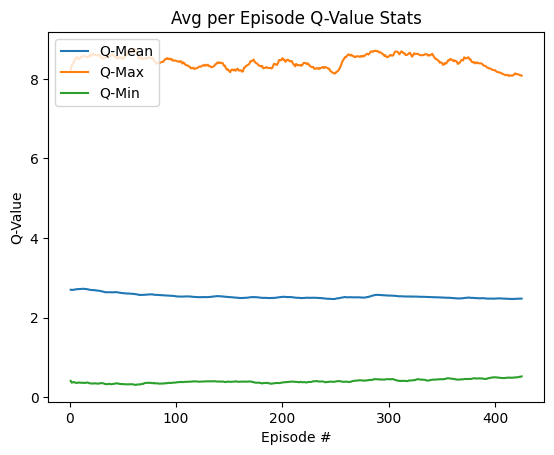

episode: 426   frame: 71783   proc time: 25.3s   score: 2.0   memory length: 274009   epsilon: 0.78465   steps: 178 steps/sec: 7.05   lr: 0.0005   PER_beta: 0.45743 PER Alpha: 0.54257   reward MA: 1.92   mean loss: 0.01677   mean max Q: 8.2102
[PER STATS] TD-error mean: 0.06540162188870136 std: 0.1209573714486039 min: 0.0 max: 3.1005859375
episode: 427   frame: 72101   proc time: 46.3s   score: 5.0   memory length: 274322   epsilon: 0.7837   steps: 318 steps/sec: 6.88   lr: 0.0005   PER_beta: 0.45768 PER Alpha: 0.54232   reward MA: 1.98   mean loss: 0.01822   mean max Q: 8.291
episode: 428   frame: 72326   proc time: 32.5s   score: 3.0   memory length: 274542   epsilon: 0.78302   steps: 225 steps/sec: 6.93   lr: 0.0005   PER_beta: 0.45786 PER Alpha: 0.54214   reward MA: 2.0   mean loss: 0.01759   mean max Q: 8.1682
episode: 429   frame: 72446   proc time: 17.2s   score: 0.0   memory length: 274657   epsilon: 0.78266   steps: 120 steps/sec: 6.99   lr: 0.0005   PER_beta: 0.45796 PER Alph

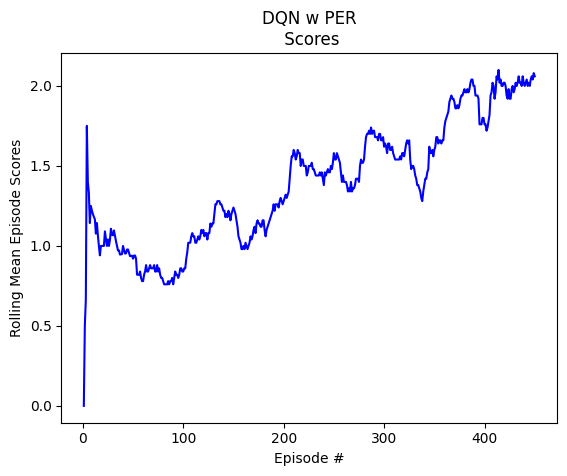

[SAVED PLOT] ./save_graph/run18/Run18_Bootstrapped_run17_stickyactions5percent_ep450_losses.png


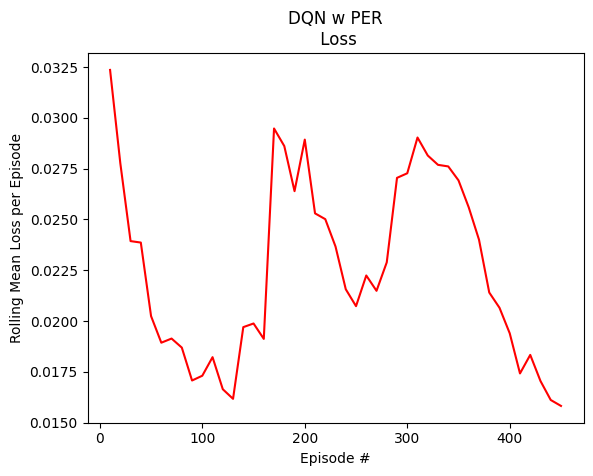

[SAVED PLOT] ./save_graph/run18/Run18_Bootstrapped_run17_stickyactions5percent_ep450_Qstats.png


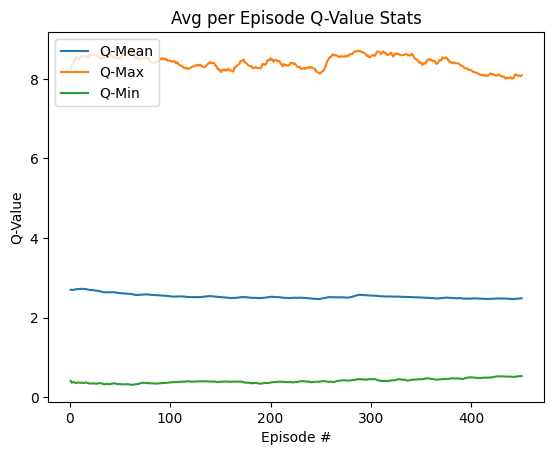

episode: 451   frame: 76377   proc time: 26.1s   score: 2.0   memory length: 278478   epsilon: 0.77087   steps: 178 steps/sec: 6.83   lr: 0.0005   PER_beta: 0.4611 PER Alpha: 0.5389   reward MA: 2.06   mean loss: 0.01427   mean max Q: 7.9181
episode: 452   frame: 76689   proc time: 46.1s   score: 4.0   memory length: 278785   epsilon: 0.76993   steps: 312 steps/sec: 6.77   lr: 0.0005   PER_beta: 0.46135 PER Alpha: 0.53865   reward MA: 2.12   mean loss: 0.01327   mean max Q: 8.1254
episode: 453   frame: 76837   proc time: 22.0s   score: 1.0   memory length: 278928   epsilon: 0.76949   steps: 148 steps/sec: 6.73   lr: 0.0005   PER_beta: 0.46147 PER Alpha: 0.53853   reward MA: 2.12   mean loss: 0.01452   mean max Q: 7.9335
[PER STATS] TD-error mean: 0.06290925749799915 std: 0.11123698942108279 min: 0.0 max: 2.97265625
episode: 454   frame: 77015   proc time: 26.2s   score: 2.0   memory length: 279101   epsilon: 0.76896   steps: 178 steps/sec: 6.79   lr: 0.0005   PER_beta: 0.46161 PER Alph

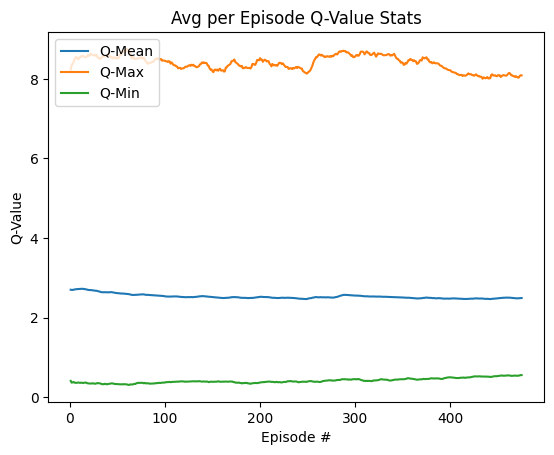

episode: 476   frame: 81323   proc time: 22.5s   score: 1.0   memory length: 283299   epsilon: 0.75603   steps: 149 steps/sec: 6.63   lr: 0.0005   PER_beta: 0.46506 PER Alpha: 0.53494   reward MA: 2.02   mean loss: 0.01274   mean max Q: 8.4043
episode: 477   frame: 81519   proc time: 29.5s   score: 2.0   memory length: 283490   epsilon: 0.75544   steps: 196 steps/sec: 6.64   lr: 0.0005   PER_beta: 0.46522 PER Alpha: 0.53478   reward MA: 1.96   mean loss: 0.01344   mean max Q: 8.2363
episode: 478   frame: 81697   proc time: 26.8s   score: 2.0   memory length: 283663   epsilon: 0.75491   steps: 178 steps/sec: 6.65   lr: 0.0005   PER_beta: 0.46536 PER Alpha: 0.53464   reward MA: 1.94   mean loss: 0.01385   mean max Q: 8.2034
[PER STATS] TD-error mean: 0.06360583451565952 std: 0.11345116455738512 min: 0.0 max: 2.861328125
episode: 479   frame: 82038   proc time: 51.8s   score: 6.0   memory length: 283999   epsilon: 0.75389   steps: 341 steps/sec: 6.59   lr: 0.0005   PER_beta: 0.46563 PER A

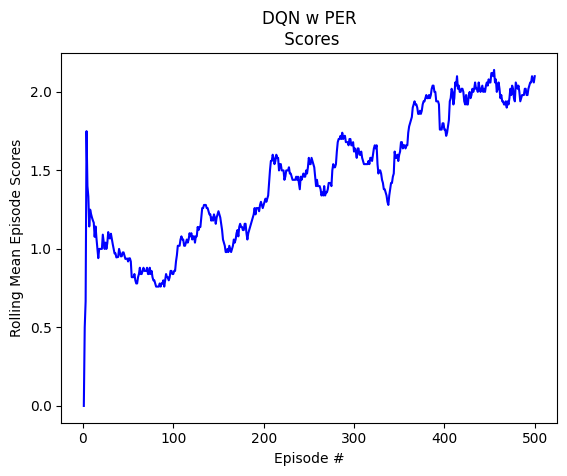

[SAVED PLOT] ./save_graph/run18/Run18_Bootstrapped_run17_stickyactions5percent_ep500_losses.png


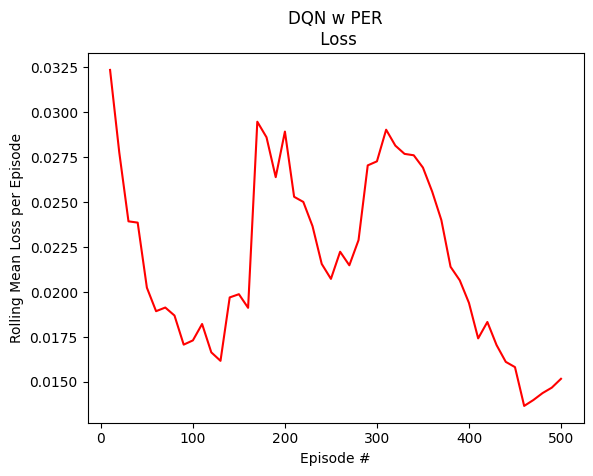

[SAVED PLOT] ./save_graph/run18/Run18_Bootstrapped_run17_stickyactions5percent_ep500_Qstats.png


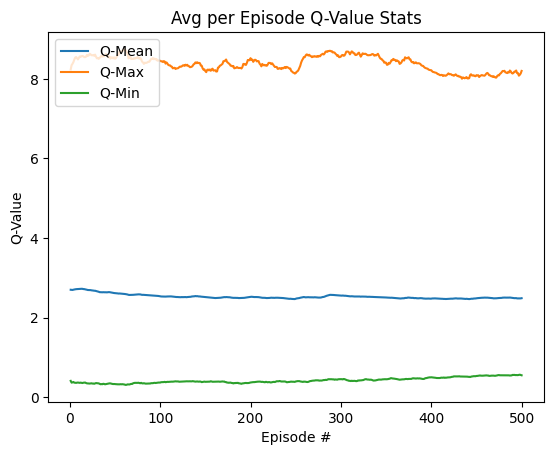

Checkpoint for episode 500 saved
[PER STATS] TD-error mean: 0.06440250984804259 std: 0.11515664052327343 min: 0.0 max: 2.697265625
episode: 501   frame: 86101   proc time: 30.5s   score: 2.0   memory length: 287952   epsilon: 0.7417   steps: 197 steps/sec: 6.45   lr: 0.0005   PER_beta: 0.46888 PER Alpha: 0.53112   reward MA: 2.1   mean loss: 0.0155   mean max Q: 8.2137
episode: 502   frame: 86221   proc time: 18.5s   score: 0.0   memory length: 288067   epsilon: 0.74134   steps: 120 steps/sec: 6.48   lr: 0.0005   PER_beta: 0.46898 PER Alpha: 0.53102   reward MA: 2.02   mean loss: 0.01366   mean max Q: 8.3511
episode: 503   frame: 86446   proc time: 34.7s   score: 3.0   memory length: 288287   epsilon: 0.74066   steps: 225 steps/sec: 6.48   lr: 0.0005   PER_beta: 0.46916 PER Alpha: 0.53084   reward MA: 2.06   mean loss: 0.0134   mean max Q: 7.969
episode: 504   frame: 86642   proc time: 30.1s   score: 2.0   memory length: 288478   epsilon: 0.74007   steps: 196 steps/sec: 6.51   lr: 0.00

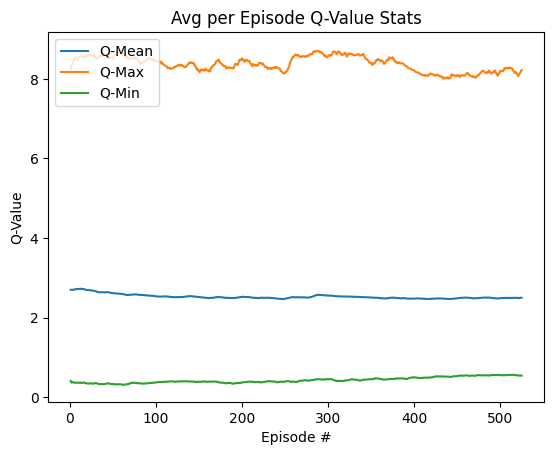

episode: 526   frame: 91556   proc time: 40.9s   score: 4.0   memory length: 293282   epsilon: 0.72533   steps: 258 steps/sec: 6.31   lr: 0.0005   PER_beta: 0.47324 PER Alpha: 0.52676   reward MA: 2.36   mean loss: 0.01477   mean max Q: 8.2269
episode: 527   frame: 91782   proc time: 35.8s   score: 3.0   memory length: 293503   epsilon: 0.72465   steps: 226 steps/sec: 6.31   lr: 0.0005   PER_beta: 0.47343 PER Alpha: 0.52657   reward MA: 2.38   mean loss: 0.0162   mean max Q: 8.3729
episode: 528   frame: 91931   proc time: 23.7s   score: 1.0   memory length: 293647   epsilon: 0.72421   steps: 149 steps/sec: 6.29   lr: 0.0005   PER_beta: 0.47354 PER Alpha: 0.52646   reward MA: 2.36   mean loss: 0.0148   mean max Q: 8.3199
[PER STATS] TD-error mean: 0.06373466007706753 std: 0.11468061440383234 min: 0.0 max: 3.17333984375
episode: 529   frame: 92140   proc time: 33.3s   score: 3.0   memory length: 293851   epsilon: 0.72358   steps: 209 steps/sec: 6.28   lr: 0.0005   PER_beta: 0.47371 PER A

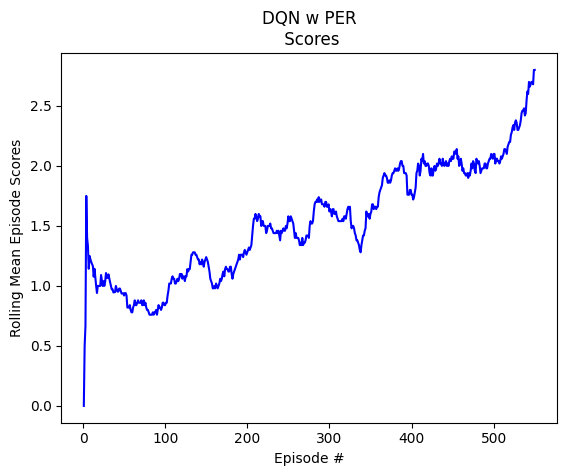

[SAVED PLOT] ./save_graph/run18/Run18_Bootstrapped_run17_stickyactions5percent_ep550_losses.png


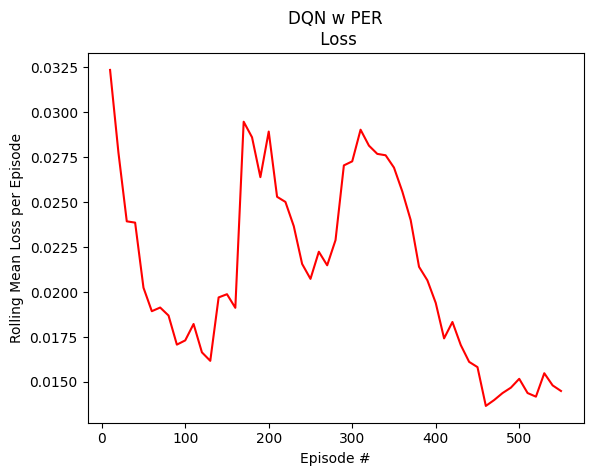

[SAVED PLOT] ./save_graph/run18/Run18_Bootstrapped_run17_stickyactions5percent_ep550_Qstats.png


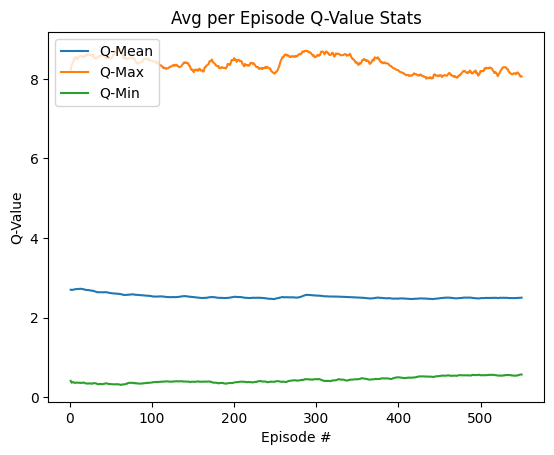

episode: 551   frame: 96914   proc time: 28.9s   score: 2.0   memory length: 298515   epsilon: 0.70926   steps: 178 steps/sec: 6.16   lr: 0.0005   PER_beta: 0.47753 PER Alpha: 0.52247   reward MA: 2.8   mean loss: 0.0139   mean max Q: 8.001
[PER STATS] TD-error mean: 0.06335681020606818 std: 0.11319805149482562 min: 0.0 max: 2.580078125
episode: 552   frame: 97172   proc time: 42.5s   score: 4.0   memory length: 298768   epsilon: 0.70848   steps: 258 steps/sec: 6.07   lr: 0.0005   PER_beta: 0.47774 PER Alpha: 0.52226   reward MA: 2.88   mean loss: 0.01361   mean max Q: 8.3082
episode: 553   frame: 97292   proc time: 19.4s   score: 0.0   memory length: 298883   epsilon: 0.70812   steps: 120 steps/sec: 6.19   lr: 0.0005   PER_beta: 0.47783 PER Alpha: 0.52217   reward MA: 2.82   mean loss: 0.01376   mean max Q: 8.0874
episode: 554   frame: 97440   proc time: 24.2s   score: 1.0   memory length: 299026   epsilon: 0.70768   steps: 148 steps/sec: 6.11   lr: 0.0005   PER_beta: 0.47795 PER Alph

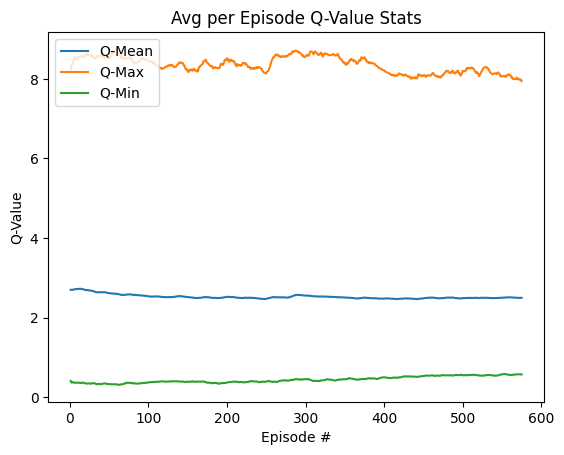

episode: 576   frame: 101945   proc time: 44.9s   score: 4.0   memory length: 303421   epsilon: 0.69417   steps: 268 steps/sec: 5.97   lr: 0.0002   PER_beta: 0.48156 PER Alpha: 0.51844   reward MA: 2.6   mean loss: 0.01489   mean max Q: 7.9819
[PER STATS] TD-error mean: 0.06273437280983046 std: 0.11521631490598286 min: 0.0 max: 3.1357421875
episode: 577   frame: 102201   proc time: 42.8s   score: 4.0   memory length: 303672   epsilon: 0.6934   steps: 256 steps/sec: 5.98   lr: 0.0002   PER_beta: 0.48176 PER Alpha: 0.51824   reward MA: 2.62   mean loss: 0.01623   mean max Q: 7.7618
episode: 578   frame: 102349   proc time: 24.7s   score: 1.0   memory length: 303815   epsilon: 0.69295   steps: 148 steps/sec: 6.0   lr: 0.0002   PER_beta: 0.48188 PER Alpha: 0.51812   reward MA: 2.62   mean loss: 0.01455   mean max Q: 7.9279
episode: 579   frame: 102497   proc time: 24.9s   score: 1.0   memory length: 303958   epsilon: 0.69251   steps: 148 steps/sec: 5.95   lr: 0.0002   PER_beta: 0.482 PER A

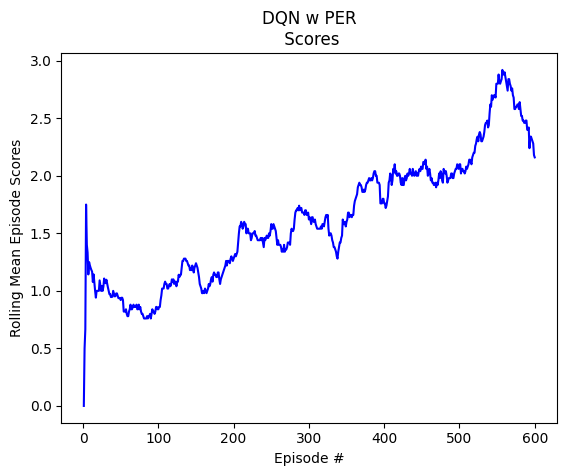

[SAVED PLOT] ./save_graph/run18/Run18_Bootstrapped_run17_stickyactions5percent_ep600_losses.png


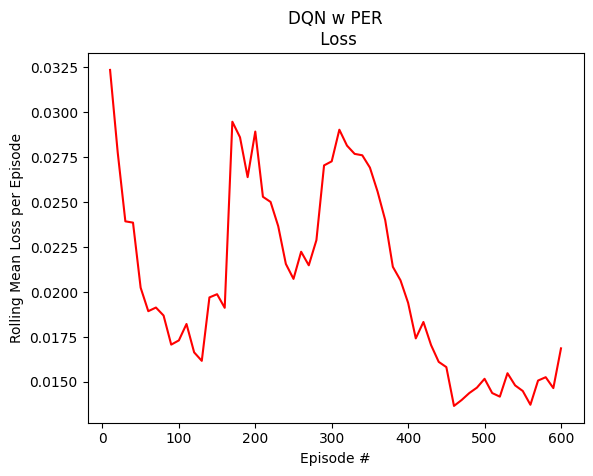

[SAVED PLOT] ./save_graph/run18/Run18_Bootstrapped_run17_stickyactions5percent_ep600_Qstats.png


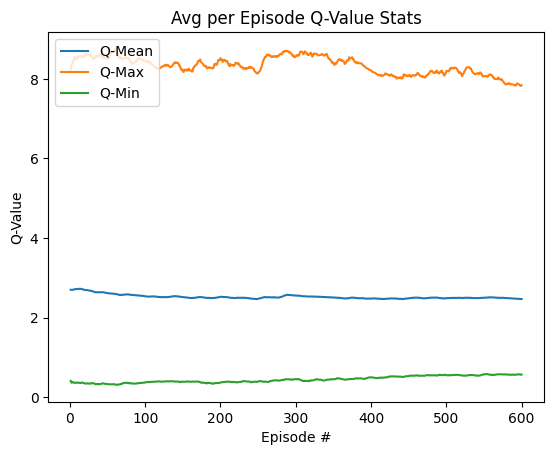

Checkpoint for episode 600 saved
Replay buffer of 307901 frames saved
episode: 601   frame: 106665   proc time: 21.6s   score: 0.0   memory length: 308016   epsilon: 0.68001   steps: 120 steps/sec: 5.54   lr: 0.0002   PER_beta: 0.48533 PER Alpha: 0.51467   reward MA: 2.12   mean loss: 0.01677   mean max Q: 7.6405
episode: 602   frame: 106861   proc time: 38.0s   score: 2.0   memory length: 308207   epsilon: 0.67942   steps: 196 steps/sec: 5.16   lr: 0.0002   PER_beta: 0.48549 PER Alpha: 0.51451   reward MA: 2.08   mean loss: 0.01724   mean max Q: 7.7152
[PER STATS] TD-error mean: 0.06309865724724989 std: 0.12019589538473875 min: 0.0 max: 2.990234375
episode: 603   frame: 107009   proc time: 27.9s   score: 1.0   memory length: 308350   epsilon: 0.67897   steps: 148 steps/sec: 5.31   lr: 0.0002   PER_beta: 0.48561 PER Alpha: 0.51439   reward MA: 2.1   mean loss: 0.0165   mean max Q: 7.8805
episode: 604   frame: 107216   proc time: 37.4s   score: 3.0   memory length: 308552   epsilon: 0.6

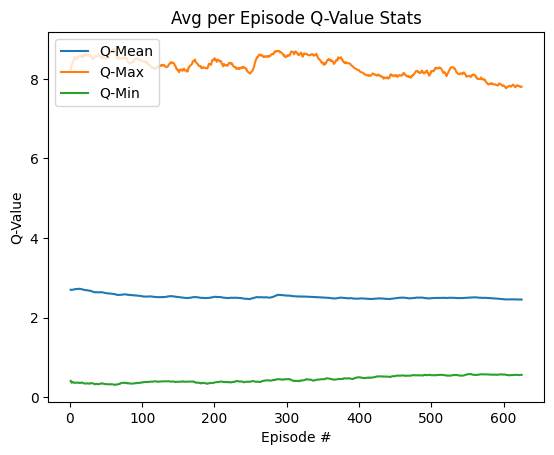

episode: 626   frame: 111971   proc time: 58.5s   score: 6.0   memory length: 313197   epsilon: 0.66409   steps: 342 steps/sec: 5.85   lr: 0.0002   PER_beta: 0.48958 PER Alpha: 0.51042   reward MA: 2.36   mean loss: 0.01843   mean max Q: 7.609
[PER STATS] TD-error mean: 0.06420457651405864 std: 0.12544660994219908 min: 0.0 max: 3.1494140625
episode: 627   frame: 112224   proc time: 43.4s   score: 4.0   memory length: 313445   epsilon: 0.66333   steps: 253 steps/sec: 5.83   lr: 0.0002   PER_beta: 0.48978 PER Alpha: 0.51022   reward MA: 2.36   mean loss: 0.0181   mean max Q: 7.7165
episode: 628   frame: 112372   proc time: 25.4s   score: 1.0   memory length: 313588   epsilon: 0.66288   steps: 148 steps/sec: 5.83   lr: 0.0002   PER_beta: 0.4899 PER Alpha: 0.5101   reward MA: 2.36   mean loss: 0.01794   mean max Q: 7.6377
episode: 629   frame: 112540   proc time: 32.8s   score: 1.0   memory length: 313751   epsilon: 0.66238   steps: 168 steps/sec: 5.12   lr: 0.0002   PER_beta: 0.49003 PER 

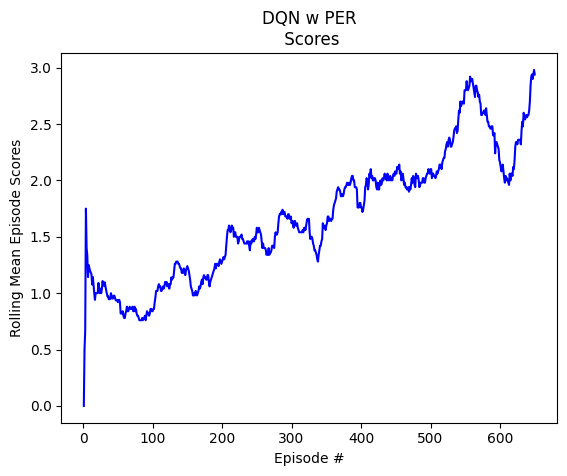

[SAVED PLOT] ./save_graph/run18/Run18_Bootstrapped_run17_stickyactions5percent_ep650_losses.png


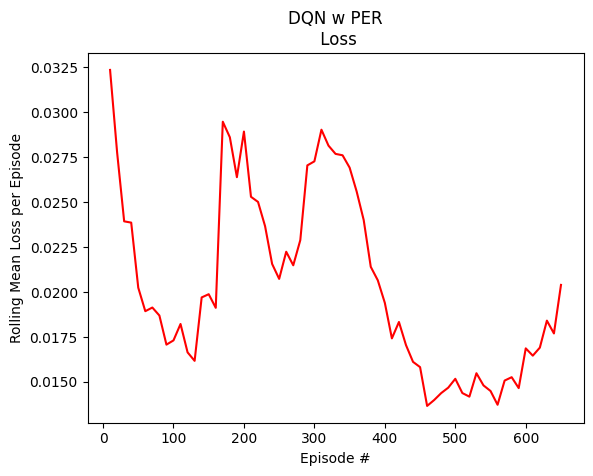

[SAVED PLOT] ./save_graph/run18/Run18_Bootstrapped_run17_stickyactions5percent_ep650_Qstats.png


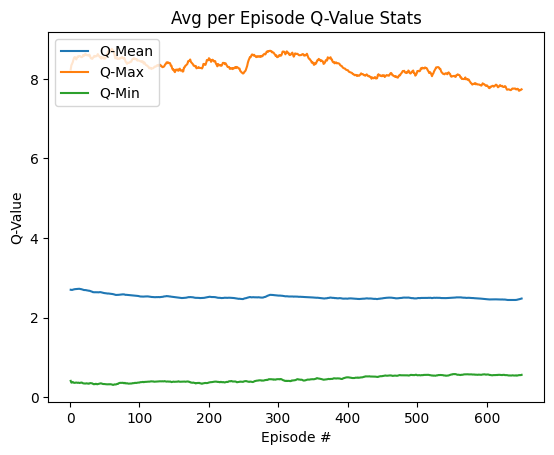

episode: 651   frame: 117576   proc time: 33.5s   score: 2.0   memory length: 318677   epsilon: 0.64727   steps: 178 steps/sec: 5.32   lr: 0.0002   PER_beta: 0.49406 PER Alpha: 0.50594   reward MA: 2.98   mean loss: 0.01945   mean max Q: 7.876
episode: 652   frame: 117724   proc time: 26.4s   score: 1.0   memory length: 318820   epsilon: 0.64683   steps: 148 steps/sec: 5.6   lr: 0.0002   PER_beta: 0.49418 PER Alpha: 0.50582   reward MA: 2.96   mean loss: 0.01739   mean max Q: 7.5189
[PER STATS] TD-error mean: 0.06556990493088691 std: 0.13273323064960577 min: 0.0 max: 4.05712890625
episode: 653   frame: 118120   proc time: 72.8s   score: 9.0   memory length: 319211   epsilon: 0.64564   steps: 396 steps/sec: 5.44   lr: 0.0002   PER_beta: 0.4945 PER Alpha: 0.5055   reward MA: 3.12   mean loss: 0.01989   mean max Q: 7.8371
episode: 654   frame: 118268   proc time: 26.6s   score: 1.0   memory length: 319354   epsilon: 0.6452   steps: 148 steps/sec: 5.55   lr: 0.0002   PER_beta: 0.49461 PER 

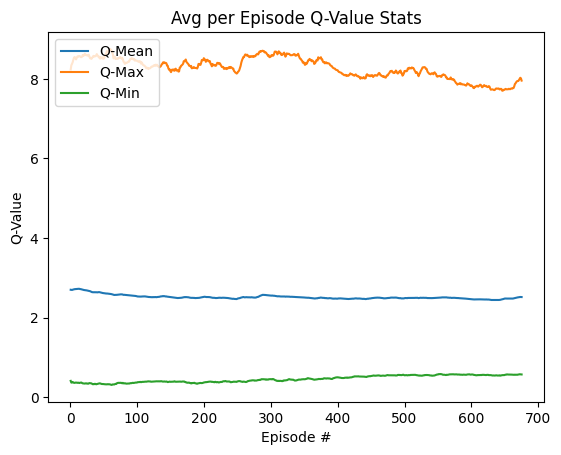

episode: 676   frame: 123353   proc time: 48.2s   score: 3.0   memory length: 324329   epsilon: 0.62994   steps: 227 steps/sec: 4.7   lr: 0.0002   PER_beta: 0.49868 PER Alpha: 0.50132   reward MA: 3.28   mean loss: 0.01802   mean max Q: 8.1363
episode: 677   frame: 123473   proc time: 25.0s   score: 0.0   memory length: 324444   epsilon: 0.62958   steps: 120 steps/sec: 4.8   lr: 0.0002   PER_beta: 0.49878 PER Alpha: 0.50122   reward MA: 3.2   mean loss: 0.01728   mean max Q: 8.291
episode: 678   frame: 123795   proc time: 68.1s   score: 5.0   memory length: 324761   epsilon: 0.62862   steps: 322 steps/sec: 4.73   lr: 0.0002   PER_beta: 0.49904 PER Alpha: 0.50096   reward MA: 3.28   mean loss: 0.01933   mean max Q: 8.1014
[PER STATS] TD-error mean: 0.06629888213162151 std: 0.1277865533307272 min: 0.0 max: 3.0986328125
episode: 679   frame: 124004   proc time: 44.5s   score: 3.0   memory length: 324965   epsilon: 0.62799   steps: 209 steps/sec: 4.69   lr: 0.0002   PER_beta: 0.4992 PER Al

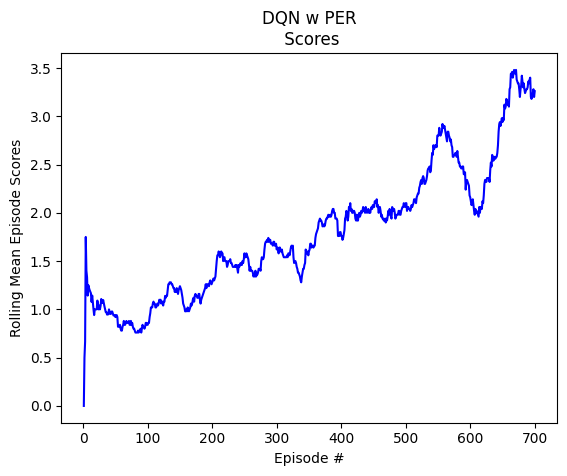

[SAVED PLOT] ./save_graph/run18/Run18_Bootstrapped_run17_stickyactions5percent_ep700_losses.png


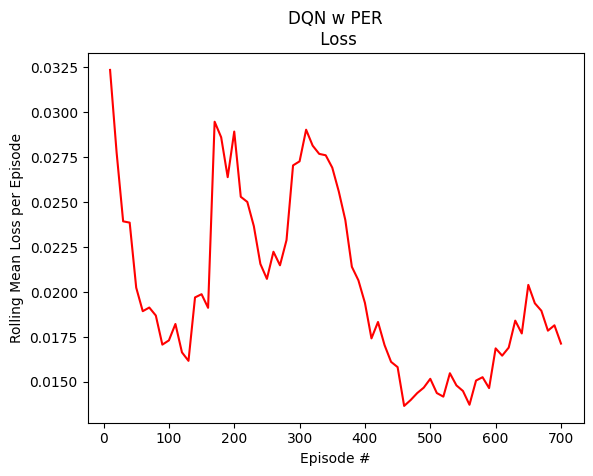

[SAVED PLOT] ./save_graph/run18/Run18_Bootstrapped_run17_stickyactions5percent_ep700_Qstats.png


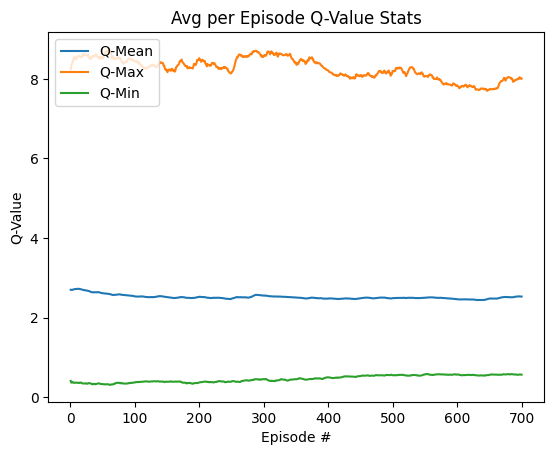

Checkpoint for episode 700 saved
[PER STATS] TD-error mean: 0.06793713695826673 std: 0.12913469410029957 min: 0.0 max: 3.39453125
episode: 701   frame: 129126   proc time: 49.3s   score: 3.0   memory length: 329977   epsilon: 0.61262   steps: 227 steps/sec: 4.6   lr: 0.0002   PER_beta: 0.5033 PER Alpha: 0.4967   reward MA: 3.28   mean loss: 0.01574   mean max Q: 8.1333
episode: 702   frame: 129304   proc time: 38.2s   score: 2.0   memory length: 330150   epsilon: 0.61209   steps: 178 steps/sec: 4.66   lr: 0.0002   PER_beta: 0.50344 PER Alpha: 0.49656   reward MA: 3.3   mean loss: 0.01685   mean max Q: 7.6266
episode: 703   frame: 129513   proc time: 44.7s   score: 3.0   memory length: 330354   epsilon: 0.61146   steps: 209 steps/sec: 4.68   lr: 0.0002   PER_beta: 0.50361 PER Alpha: 0.49639   reward MA: 3.18   mean loss: 0.01743   mean max Q: 8.2391
episode: 704   frame: 129843   proc time: 70.0s   score: 5.0   memory length: 330679   epsilon: 0.61047   steps: 330 steps/sec: 4.71   lr: 

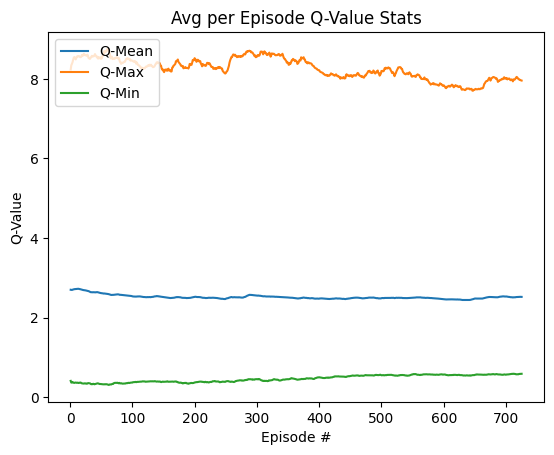

episode: 726   frame: 134916   proc time: 39.0s   score: 2.0   memory length: 335642   epsilon: 0.59525   steps: 178 steps/sec: 4.56   lr: 0.0002   PER_beta: 0.50793 PER Alpha: 0.49207   reward MA: 3.26   mean loss: 0.01783   mean max Q: 7.9691
Target network updated at frame:  135000
[PER STATS] TD-error mean: 0.06833319793609624 std: 0.12723372142462908 min: 0.0 max: 2.962890625
episode: 727   frame: 135143   proc time: 50.9s   score: 3.0   memory length: 335864   epsilon: 0.59457   steps: 227 steps/sec: 4.46   lr: 0.0002   PER_beta: 0.50811 PER Alpha: 0.49189   reward MA: 3.32   mean loss: 0.0174   mean max Q: 7.5998
episode: 728   frame: 135448   proc time: 68.0s   score: 5.0   memory length: 336164   epsilon: 0.59366   steps: 305 steps/sec: 4.49   lr: 0.0002   PER_beta: 0.50836 PER Alpha: 0.49164   reward MA: 3.32   mean loss: 0.01633   mean max Q: 7.8268
episode: 729   frame: 135626   proc time: 39.1s   score: 2.0   memory length: 336337   epsilon: 0.59312   steps: 178 steps/sec:

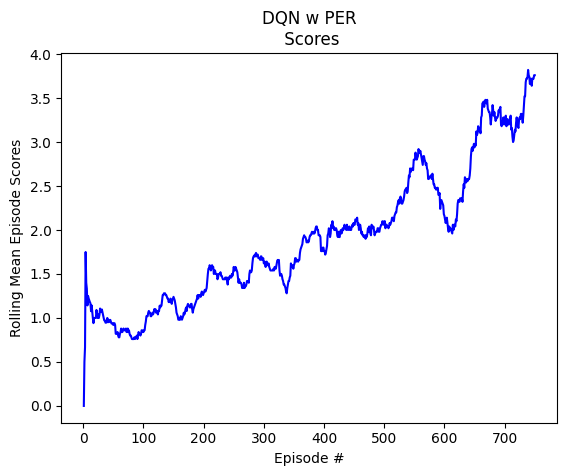

[SAVED PLOT] ./save_graph/run18/Run18_Bootstrapped_run17_stickyactions5percent_ep750_losses.png


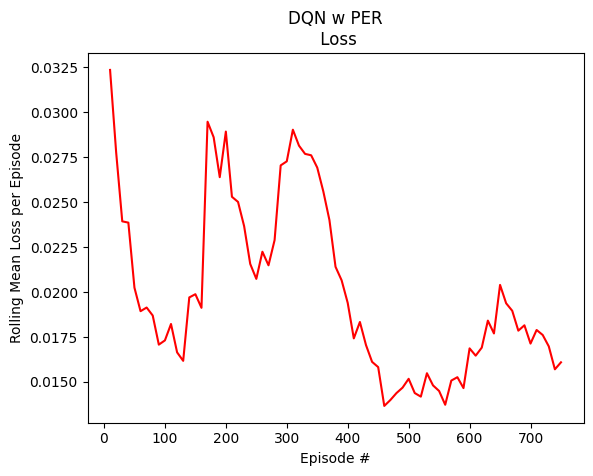

[SAVED PLOT] ./save_graph/run18/Run18_Bootstrapped_run17_stickyactions5percent_ep750_Qstats.png


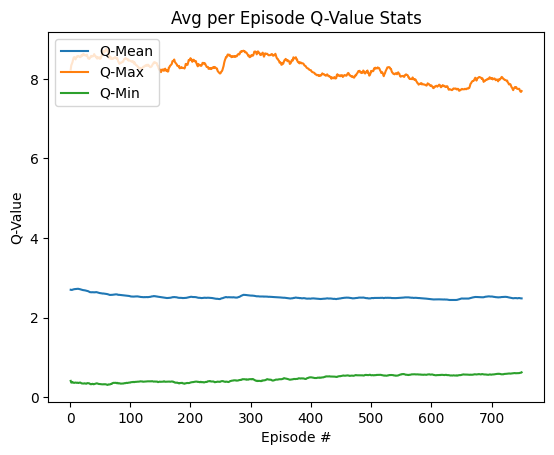

episode: 751   frame: 141285   proc time: 55.5s   score: 4.0   memory length: 341886   epsilon: 0.57615   steps: 260 steps/sec: 4.69   lr: 0.0002   PER_beta: 0.51303 PER Alpha: 0.48697   reward MA: 3.78   mean loss: 0.01474   mean max Q: 7.7296
episode: 752   frame: 141511   proc time: 49.9s   score: 3.0   memory length: 342107   epsilon: 0.57547   steps: 226 steps/sec: 4.53   lr: 0.0002   PER_beta: 0.51321 PER Alpha: 0.48679   reward MA: 3.8   mean loss: 0.01396   mean max Q: 7.4871
episode: 753   frame: 141737   proc time: 49.0s   score: 3.0   memory length: 342328   epsilon: 0.57479   steps: 226 steps/sec: 4.61   lr: 0.0002   PER_beta: 0.51339 PER Alpha: 0.48661   reward MA: 3.8   mean loss: 0.01418   mean max Q: 7.5539
episode: 754   frame: 141885   proc time: 32.3s   score: 1.0   memory length: 342471   epsilon: 0.57435   steps: 148 steps/sec: 4.58   lr: 0.0002   PER_beta: 0.51351 PER Alpha: 0.48649   reward MA: 3.72   mean loss: 0.01465   mean max Q: 7.8574
[PER STATS] TD-error m

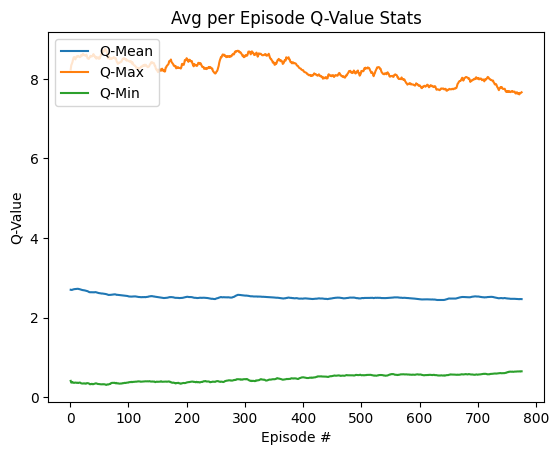

episode: 776   frame: 147203   proc time: 43.8s   score: 2.0   memory length: 347679   epsilon: 0.55839   steps: 199 steps/sec: 4.55   lr: 0.0002   PER_beta: 0.51776 PER Alpha: 0.48224   reward MA: 3.96   mean loss: 0.01399   mean max Q: 7.7227
episode: 777   frame: 147380   proc time: 41.9s   score: 2.0   memory length: 347851   epsilon: 0.55786   steps: 177 steps/sec: 4.22   lr: 0.0002   PER_beta: 0.5179 PER Alpha: 0.4821   reward MA: 3.94   mean loss: 0.01291   mean max Q: 7.8539
episode: 778   frame: 147558   proc time: 41.4s   score: 2.0   memory length: 348024   epsilon: 0.55733   steps: 178 steps/sec: 4.3   lr: 0.0002   PER_beta: 0.51805 PER Alpha: 0.48195   reward MA: 3.88   mean loss: 0.01199   mean max Q: 7.671
episode: 779   frame: 147783   proc time: 52.5s   score: 3.0   memory length: 348244   epsilon: 0.55665   steps: 225 steps/sec: 4.29   lr: 0.0002   PER_beta: 0.51823 PER Alpha: 0.48177   reward MA: 3.9   mean loss: 0.01385   mean max Q: 7.691
[PER STATS] TD-error mean:

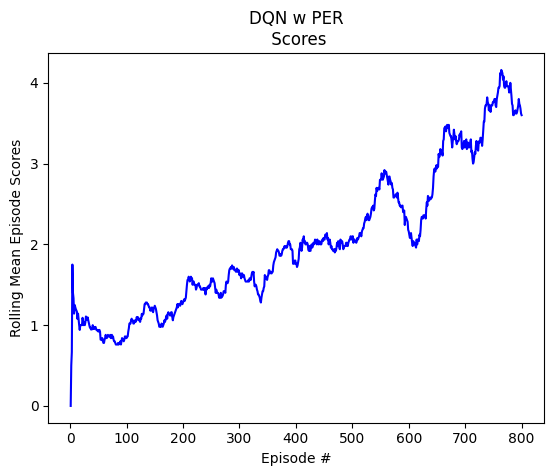

[SAVED PLOT] ./save_graph/run18/Run18_Bootstrapped_run17_stickyactions5percent_ep800_losses.png


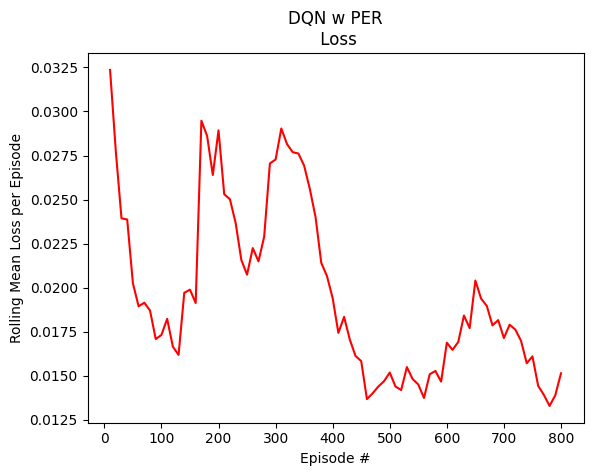

[SAVED PLOT] ./save_graph/run18/Run18_Bootstrapped_run17_stickyactions5percent_ep800_Qstats.png


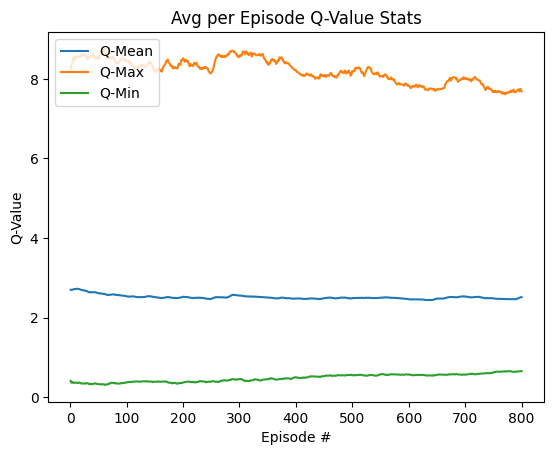

Checkpoint for episode 800 saved
Replay buffer of 352988 frames saved
episode: 801   frame: 152830   proc time: 45.6s   score: 2.0   memory length: 353181   epsilon: 0.54151   steps: 198 steps/sec: 4.34   lr: 0.0002   PER_beta: 0.52226 PER Alpha: 0.47774   reward MA: 3.56   mean loss: 0.01475   mean max Q: 8.044
episode: 802   frame: 152978   proc time: 33.9s   score: 1.0   memory length: 353324   epsilon: 0.54107   steps: 148 steps/sec: 4.36   lr: 0.0002   PER_beta: 0.52238 PER Alpha: 0.47762   reward MA: 3.52   mean loss: 0.01576   mean max Q: 7.6637
[PER STATS] TD-error mean: 0.06565715622490886 std: 0.12371985013916795 min: 0.0 max: 3.107421875
episode: 803   frame: 153269   proc time: 66.8s   score: 8.0   memory length: 353610   epsilon: 0.54019   steps: 291 steps/sec: 4.36   lr: 0.0002   PER_beta: 0.52262 PER Alpha: 0.47738   reward MA: 3.62   mean loss: 0.01401   mean max Q: 7.7117
episode: 804   frame: 153597   proc time: 75.2s   score: 5.0   memory length: 353933   epsilon: 0.

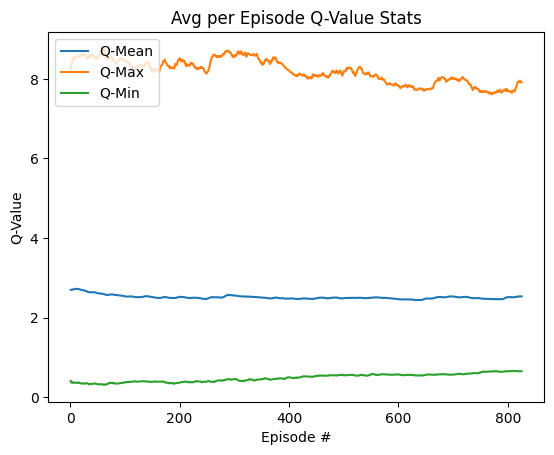

episode: 826   frame: 158703   proc time: 27.8s   score: 0.0   memory length: 358929   epsilon: 0.52389   steps: 120 steps/sec: 4.32   lr: 0.0002   PER_beta: 0.52696 PER Alpha: 0.47304   reward MA: 3.74   mean loss: 0.01606   mean max Q: 7.9862
episode: 827   frame: 158993   proc time: 67.7s   score: 8.0   memory length: 359214   epsilon: 0.52302   steps: 290 steps/sec: 4.28   lr: 0.0002   PER_beta: 0.52719 PER Alpha: 0.47281   reward MA: 3.86   mean loss: 0.01649   mean max Q: 7.4695
[PER STATS] TD-error mean: 0.06622818094308391 std: 0.1245740323778843 min: 0.0 max: 3.36376953125
episode: 828   frame: 159250   proc time: 60.5s   score: 4.0   memory length: 359466   epsilon: 0.52225   steps: 257 steps/sec: 4.25   lr: 0.0002   PER_beta: 0.5274 PER Alpha: 0.4726   reward MA: 3.9   mean loss: 0.01553   mean max Q: 7.6758
episode: 829   frame: 159447   proc time: 46.2s   score: 2.0   memory length: 359658   epsilon: 0.52166   steps: 197 steps/sec: 4.27   lr: 0.0002   PER_beta: 0.52756 PER

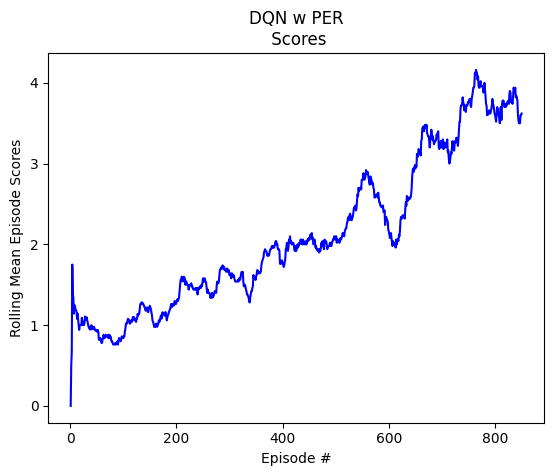

[SAVED PLOT] ./save_graph/run18/Run18_Bootstrapped_run17_stickyactions5percent_ep850_losses.png


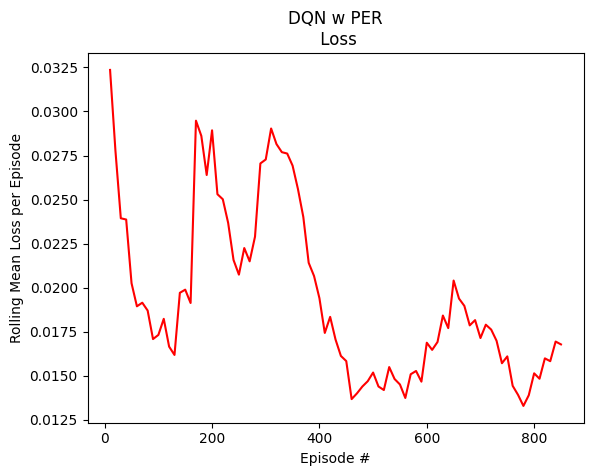

[SAVED PLOT] ./save_graph/run18/Run18_Bootstrapped_run17_stickyactions5percent_ep850_Qstats.png


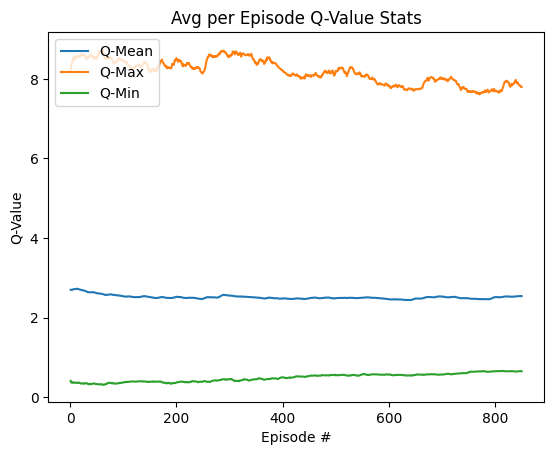

episode: 851   frame: 164399   proc time: 46.1s   score: 2.0   memory length: 364500   epsilon: 0.5068   steps: 178 steps/sec: 3.86   lr: 0.0002   PER_beta: 0.53152 PER Alpha: 0.46848   reward MA: 3.62   mean loss: 0.017   mean max Q: 7.7317
episode: 852   frame: 164577   proc time: 43.6s   score: 2.0   memory length: 364673   epsilon: 0.50627   steps: 178 steps/sec: 4.08   lr: 0.0002   PER_beta: 0.53166 PER Alpha: 0.46834   reward MA: 3.64   mean loss: 0.01567   mean max Q: 7.8211
episode: 853   frame: 164796   proc time: 52.9s   score: 2.0   memory length: 364887   epsilon: 0.50561   steps: 219 steps/sec: 4.14   lr: 0.0002   PER_beta: 0.53184 PER Alpha: 0.46816   reward MA: 3.52   mean loss: 0.01622   mean max Q: 7.7849
Target network updated at frame:  165000
[PER STATS] TD-error mean: 0.06656926650439522 std: 0.12884645216505833 min: 0.0 max: 3.9931640625
episode: 854   frame: 165043   proc time: 59.9s   score: 3.0   memory length: 365129   epsilon: 0.50487   steps: 247 steps/sec: 

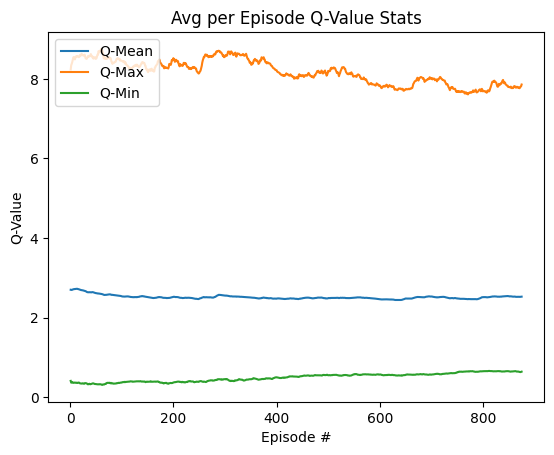

episode: 876   frame: 170671   proc time: 66.7s   score: 5.0   memory length: 370647   epsilon: 0.48799   steps: 269 steps/sec: 4.03   lr: 0.0002   PER_beta: 0.53654 PER Alpha: 0.46346   reward MA: 3.66   mean loss: 0.01684   mean max Q: 7.8412
episode: 877   frame: 170899   proc time: 56.6s   score: 3.0   memory length: 370870   epsilon: 0.4873   steps: 228 steps/sec: 4.03   lr: 0.0002   PER_beta: 0.53672 PER Alpha: 0.46328   reward MA: 3.56   mean loss: 0.0165   mean max Q: 7.6809
[PER STATS] TD-error mean: 0.06754251092621408 std: 0.12964288531436366 min: 0.0 max: 3.232421875
episode: 878   frame: 171077   proc time: 44.3s   score: 2.0   memory length: 371043   epsilon: 0.48677   steps: 178 steps/sec: 4.02   lr: 0.0002   PER_beta: 0.53686 PER Alpha: 0.46314   reward MA: 3.52   mean loss: 0.01648   mean max Q: 8.0462
episode: 879   frame: 171301   proc time: 55.5s   score: 3.0   memory length: 371262   epsilon: 0.4861   steps: 224 steps/sec: 4.04   lr: 0.0002   PER_beta: 0.53704 PER 

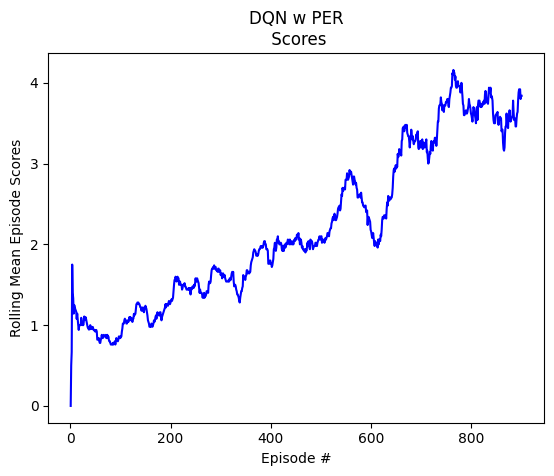

[SAVED PLOT] ./save_graph/run18/Run18_Bootstrapped_run17_stickyactions5percent_ep900_losses.png


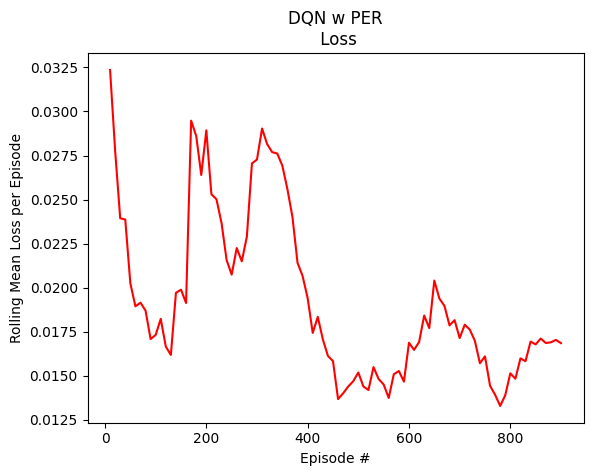

[SAVED PLOT] ./save_graph/run18/Run18_Bootstrapped_run17_stickyactions5percent_ep900_Qstats.png


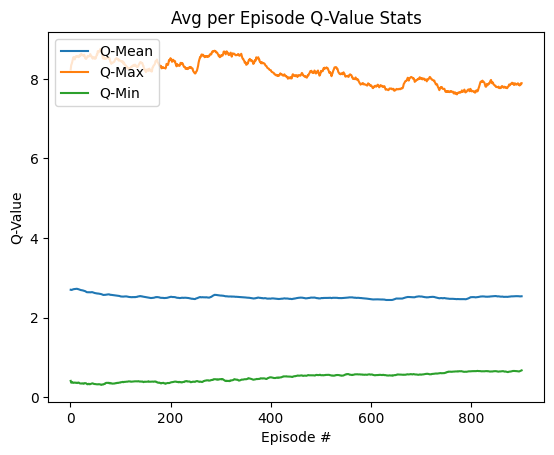

Checkpoint for episode 900 saved
episode: 901   frame: 176641   proc time: 92.9s   score: 8.0   memory length: 376492   epsilon: 0.47008   steps: 382 steps/sec: 4.11   lr: 0.0002   PER_beta: 0.54131 PER Alpha: 0.45869   reward MA: 3.96   mean loss: 0.01741   mean max Q: 8.0174
episode: 902   frame: 176958   proc time: 80.5s   score: 6.0   memory length: 376804   epsilon: 0.46913   steps: 317 steps/sec: 3.94   lr: 0.0002   PER_beta: 0.54157 PER Alpha: 0.45843   reward MA: 4.04   mean loss: 0.01877   mean max Q: 7.7575
[PER STATS] TD-error mean: 0.06827645430916239 std: 0.13446986029198493 min: 0.0 max: 3.56640625
episode: 903   frame: 177136   proc time: 44.2s   score: 2.0   memory length: 376977   epsilon: 0.46859   steps: 178 steps/sec: 4.03   lr: 0.0002   PER_beta: 0.54171 PER Alpha: 0.45829   reward MA: 4.04   mean loss: 0.01831   mean max Q: 7.7341
episode: 904   frame: 177363   proc time: 57.6s   score: 3.0   memory length: 377199   epsilon: 0.46791   steps: 227 steps/sec: 3.94   

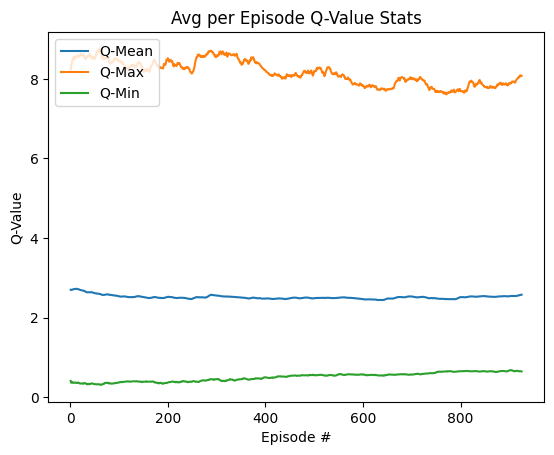

episode: 926   frame: 182988   proc time: 55.6s   score: 3.0   memory length: 382714   epsilon: 0.45104   steps: 207 steps/sec: 3.72   lr: 0.0002   PER_beta: 0.54639 PER Alpha: 0.45361   reward MA: 4.0   mean loss: 0.01969   mean max Q: 7.908
[PER STATS] TD-error mean: 0.0703526921502378 std: 0.1363136859861803 min: 0.0 max: 3.21875
episode: 927   frame: 183108   proc time: 31.8s   score: 0.0   memory length: 382829   epsilon: 0.45068   steps: 120 steps/sec: 3.77   lr: 0.0002   PER_beta: 0.54649 PER Alpha: 0.45351   reward MA: 3.94   mean loss: 0.01762   mean max Q: 7.7388
episode: 928   frame: 183354   proc time: 63.4s   score: 3.0   memory length: 383070   epsilon: 0.44994   steps: 246 steps/sec: 3.88   lr: 0.0002   PER_beta: 0.54668 PER Alpha: 0.45332   reward MA: 3.96   mean loss: 0.01921   mean max Q: 7.9723
episode: 929   frame: 183601   proc time: 66.5s   score: 3.0   memory length: 383312   epsilon: 0.4492   steps: 247 steps/sec: 3.72   lr: 0.0002   PER_beta: 0.54688 PER Alpha:

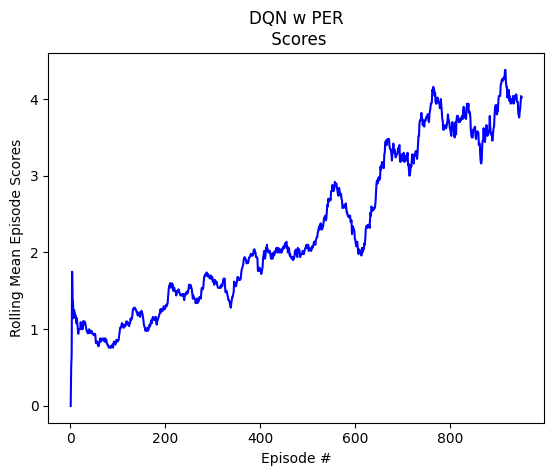

[SAVED PLOT] ./save_graph/run18/Run18_Bootstrapped_run17_stickyactions5percent_ep950_losses.png


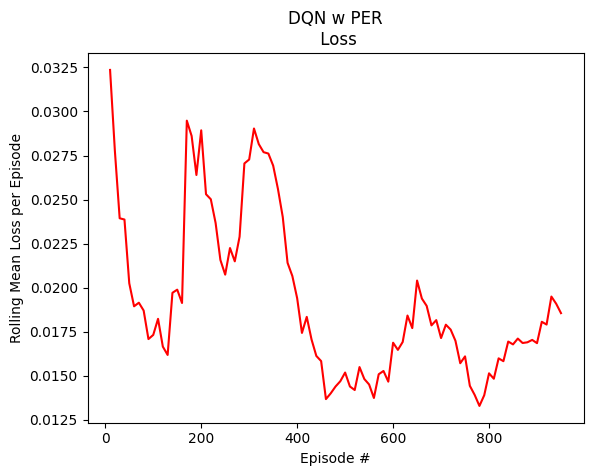

[SAVED PLOT] ./save_graph/run18/Run18_Bootstrapped_run17_stickyactions5percent_ep950_Qstats.png


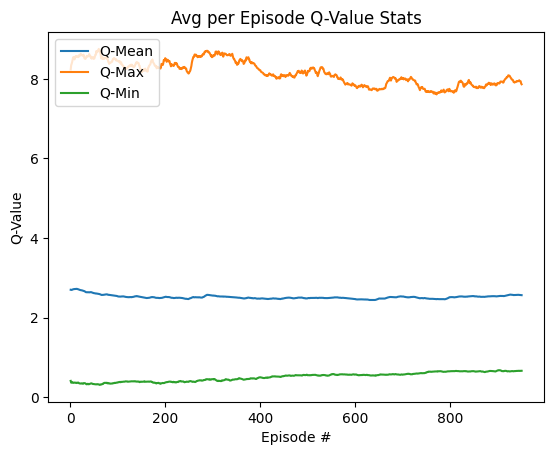

episode: 951   frame: 188931   proc time: 49.7s   score: 2.0   memory length: 388532   epsilon: 0.43321   steps: 178 steps/sec: 3.58   lr: 0.0002   PER_beta: 0.55114 PER Alpha: 0.44886   reward MA: 3.9   mean loss: 0.01951   mean max Q: 7.5962
[PER STATS] TD-error mean: 0.07127208488771057 std: 0.1375453119494999 min: 0.0 max: 3.4892578125
episode: 952   frame: 189355   proc time: 116.9s   score: 8.0   memory length: 388951   epsilon: 0.43194   steps: 424 steps/sec: 3.63   lr: 0.0002   PER_beta: 0.55148 PER Alpha: 0.44852   reward MA: 3.94   mean loss: 0.01843   mean max Q: 7.8554
episode: 953   frame: 189759   proc time: 110.0s   score: 7.0   memory length: 389350   epsilon: 0.43072   steps: 404 steps/sec: 3.67   lr: 0.0002   PER_beta: 0.55181 PER Alpha: 0.44819   reward MA: 4.04   mean loss: 0.01761   mean max Q: 7.6133
episode: 954   frame: 189968   proc time: 56.2s   score: 3.0   memory length: 389554   epsilon: 0.4301   steps: 209 steps/sec: 3.72   lr: 0.0002   PER_beta: 0.55197 P

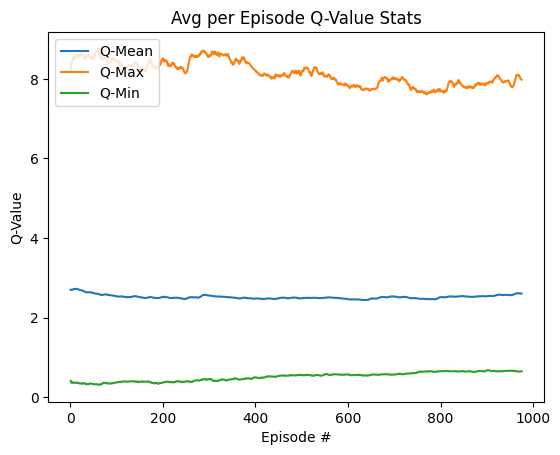

episode: 976   frame: 195304   proc time: 77.2s   score: 11.0   memory length: 394780   epsilon: 0.41409   steps: 262 steps/sec: 3.39   lr: 0.0002   PER_beta: 0.55624 PER Alpha: 0.44376   reward MA: 4.06   mean loss: 0.01874   mean max Q: 8.5777
episode: 977   frame: 195563   proc time: 78.0s   score: 4.0   memory length: 395034   epsilon: 0.41331   steps: 259 steps/sec: 3.32   lr: 0.0002   PER_beta: 0.55645 PER Alpha: 0.44355   reward MA: 4.14   mean loss: 0.02103   mean max Q: 8.2105
episode: 978   frame: 195821   proc time: 79.1s   score: 4.0   memory length: 395287   epsilon: 0.41254   steps: 258 steps/sec: 3.26   lr: 0.0002   PER_beta: 0.55666 PER Alpha: 0.44334   reward MA: 4.16   mean loss: 0.02025   mean max Q: 8.0428
[PER STATS] TD-error mean: 0.07509120193907373 std: 0.1430786818446791 min: 0.0 max: 4.38671875
episode: 979   frame: 196076   proc time: 76.3s   score: 4.0   memory length: 395537   epsilon: 0.41177   steps: 255 steps/sec: 3.34   lr: 0.0002   PER_beta: 0.55686 PE

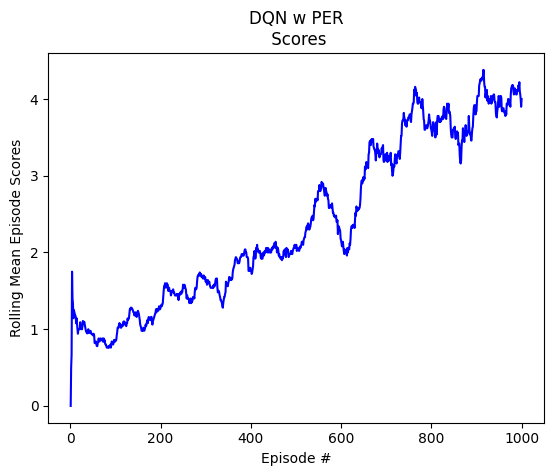

[SAVED PLOT] ./save_graph/run18/Run18_Bootstrapped_run17_stickyactions5percent_ep1000_losses.png


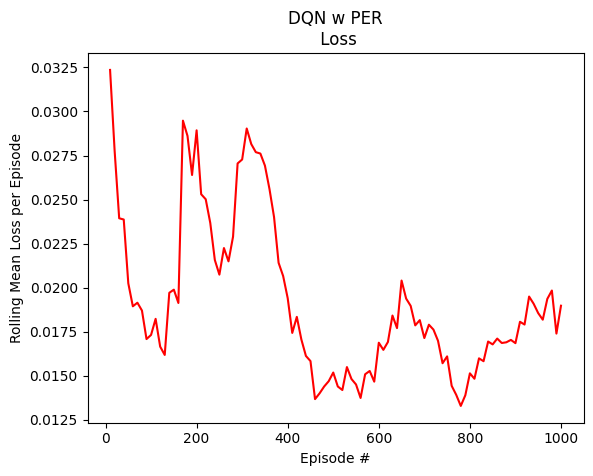

[SAVED PLOT] ./save_graph/run18/Run18_Bootstrapped_run17_stickyactions5percent_ep1000_Qstats.png


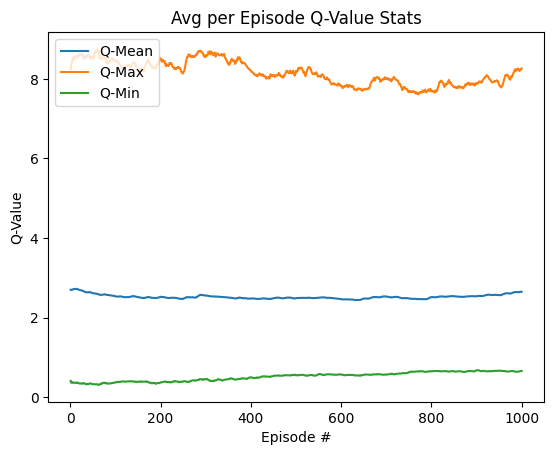

Checkpoint for episode 1000 saved
Replay buffer of 400566 frames saved
episode: 1001   frame: 201468   proc time: 74.4s   score: 4.0   memory length: 400819   epsilon: 0.3956   steps: 258 steps/sec: 3.47   lr: 8e-05   PER_beta: 0.56117 PER Alpha: 0.43883   reward MA: 4.04   mean loss: 0.01815   mean max Q: 8.2562
episode: 1002   frame: 201675   proc time: 58.6s   score: 3.0   memory length: 401021   epsilon: 0.39498   steps: 207 steps/sec: 3.53   lr: 8e-05   PER_beta: 0.56134 PER Alpha: 0.43866   reward MA: 3.94   mean loss: 0.01877   mean max Q: 8.4732
episode: 1003   frame: 201882   proc time: 60.2s   score: 3.0   memory length: 401223   epsilon: 0.39435   steps: 207 steps/sec: 3.44   lr: 8e-05   PER_beta: 0.56151 PER Alpha: 0.43849   reward MA: 3.86   mean loss: 0.01799   mean max Q: 8.2737
[PER STATS] TD-error mean: 0.07401787549018717 std: 0.1379222081371119 min: 0.0 max: 4.76953125
episode: 1004   frame: 202248   proc time: 108.8s   score: 7.0   memory length: 401584   epsilon: 0

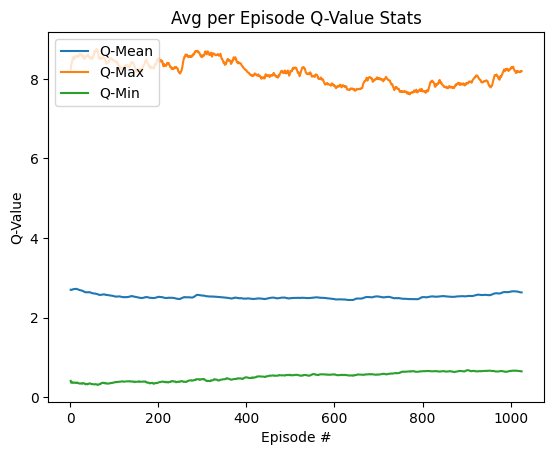

[PER STATS] TD-error mean: 0.07440073850579082 std: 0.13884175717326772 min: 0.0 max: 4.24609375
episode: 1026   frame: 208174   proc time: 153.6s   score: 10.0   memory length: 407400   epsilon: 0.37548   steps: 510 steps/sec: 3.32   lr: 8e-05   PER_beta: 0.56654 PER Alpha: 0.43346   reward MA: 4.4   mean loss: 0.01382   mean max Q: 8.024
episode: 1027   frame: 208412   proc time: 71.3s   score: 4.0   memory length: 407633   epsilon: 0.37476   steps: 238 steps/sec: 3.34   lr: 8e-05   PER_beta: 0.56673 PER Alpha: 0.43327   reward MA: 4.4   mean loss: 0.01522   mean max Q: 7.7259
episode: 1028   frame: 208704   proc time: 90.0s   score: 8.0   memory length: 407920   epsilon: 0.37389   steps: 292 steps/sec: 3.24   lr: 8e-05   PER_beta: 0.56696 PER Alpha: 0.43304   reward MA: 4.48   mean loss: 0.01757   mean max Q: 8.1699
episode: 1029   frame: 208942   proc time: 72.4s   score: 4.0   memory length: 408153   epsilon: 0.37317   steps: 238 steps/sec: 3.29   lr: 8e-05   PER_beta: 0.56715 PER

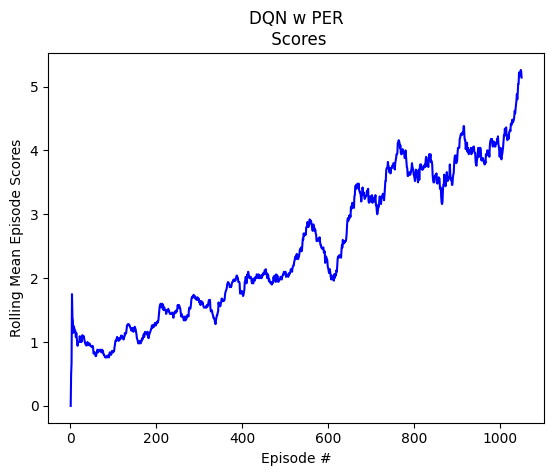

[SAVED PLOT] ./save_graph/run18/Run18_Bootstrapped_run17_stickyactions5percent_ep1050_losses.png


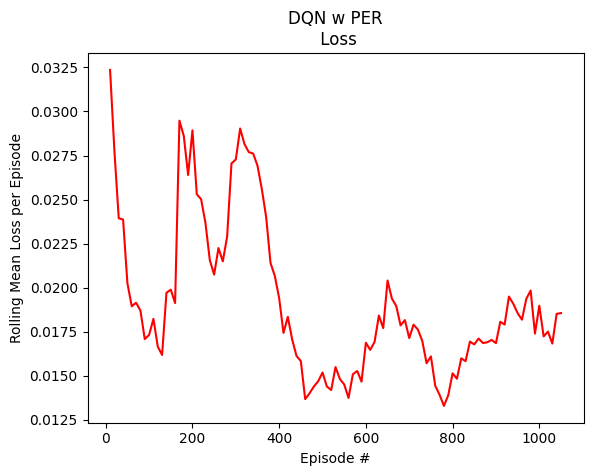

[SAVED PLOT] ./save_graph/run18/Run18_Bootstrapped_run17_stickyactions5percent_ep1050_Qstats.png


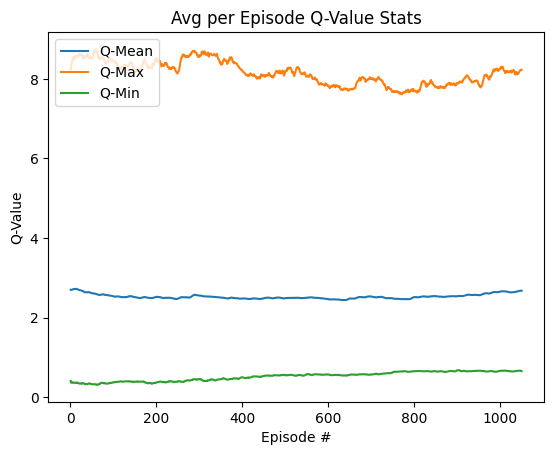

Target network updated at frame:  215000
[PER STATS] TD-error mean: 0.07519636936291037 std: 0.13841852191026363 min: 0.0 max: 3.88671875
episode: 1051   frame: 215003   proc time: 80.3s   score: 5.0   memory length: 414104   epsilon: 0.35499   steps: 272 steps/sec: 3.39   lr: 8e-05   PER_beta: 0.572 PER Alpha: 0.428   reward MA: 5.16   mean loss: 0.01737   mean max Q: 8.1976
episode: 1052   frame: 215245   proc time: 71.2s   score: 4.0   memory length: 414341   epsilon: 0.35427   steps: 242 steps/sec: 3.4   lr: 8e-05   PER_beta: 0.5722 PER Alpha: 0.4278   reward MA: 5.18   mean loss: 0.01832   mean max Q: 8.3423
episode: 1053   frame: 215503   proc time: 76.5s   score: 4.0   memory length: 414594   epsilon: 0.35349   steps: 258 steps/sec: 3.37   lr: 8e-05   PER_beta: 0.5724 PER Alpha: 0.4276   reward MA: 5.2   mean loss: 0.01998   mean max Q: 8.2606
episode: 1054   frame: 215718   proc time: 63.6s   score: 2.0   memory length: 414804   epsilon: 0.35285   steps: 215 steps/sec: 3.38   l

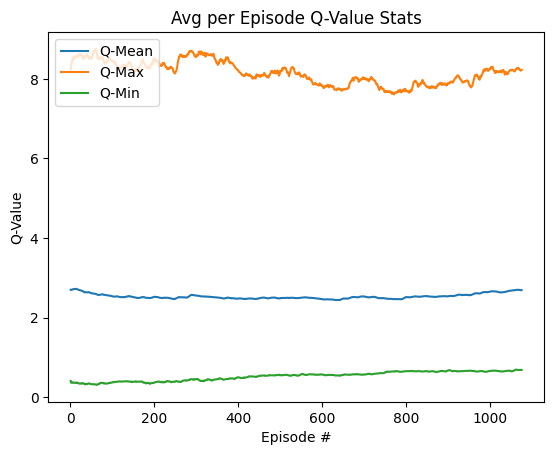

[PER STATS] TD-error mean: 0.07335540499989826 std: 0.13237483170157727 min: 0.0 max: 5.62109375
episode: 1076   frame: 221256   proc time: 98.9s   score: 5.0   memory length: 420232   epsilon: 0.33623   steps: 327 steps/sec: 3.31   lr: 8e-05   PER_beta: 0.577 PER Alpha: 0.423   reward MA: 4.7   mean loss: 0.01748   mean max Q: 8.2468
episode: 1077   frame: 221501   proc time: 74.1s   score: 3.0   memory length: 420472   epsilon: 0.3355   steps: 245 steps/sec: 3.31   lr: 8e-05   PER_beta: 0.5772 PER Alpha: 0.4228   reward MA: 4.68   mean loss: 0.01625   mean max Q: 8.1362
episode: 1078   frame: 221758   proc time: 78.2s   score: 4.0   memory length: 420724   epsilon: 0.33473   steps: 257 steps/sec: 3.29   lr: 8e-05   PER_beta: 0.57741 PER Alpha: 0.42259   reward MA: 4.6   mean loss: 0.01609   mean max Q: 8.2068
episode: 1079   frame: 221906   proc time: 44.3s   score: 1.0   memory length: 420867   epsilon: 0.33428   steps: 148 steps/sec: 3.34   lr: 8e-05   PER_beta: 0.57752 PER Alpha: 

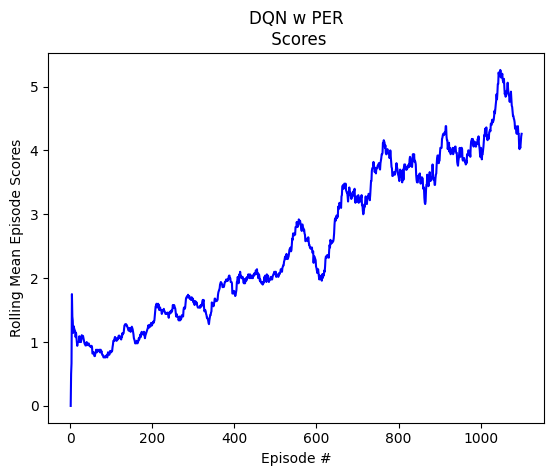

[SAVED PLOT] ./save_graph/run18/Run18_Bootstrapped_run17_stickyactions5percent_ep1100_losses.png


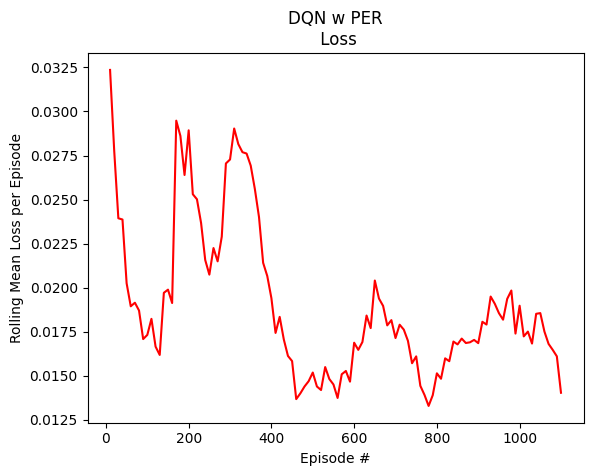

[SAVED PLOT] ./save_graph/run18/Run18_Bootstrapped_run17_stickyactions5percent_ep1100_Qstats.png


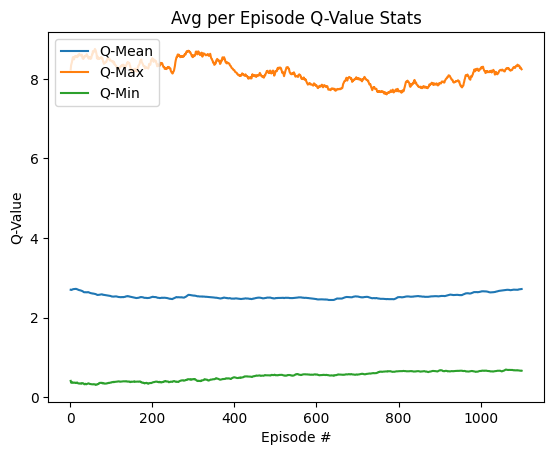

Checkpoint for episode 1100 saved
episode: 1101   frame: 227694   proc time: 72.7s   score: 3.0   memory length: 426545   epsilon: 0.31692   steps: 226 steps/sec: 3.11   lr: 8e-05   PER_beta: 0.58216 PER Alpha: 0.41784   reward MA: 4.22   mean loss: 0.01296   mean max Q: 8.2596
episode: 1102   frame: 227872   proc time: 55.1s   score: 2.0   memory length: 426718   epsilon: 0.31638   steps: 178 steps/sec: 3.23   lr: 8e-05   PER_beta: 0.5823 PER Alpha: 0.4177   reward MA: 4.18   mean loss: 0.01259   mean max Q: 8.2766
[PER STATS] TD-error mean: 0.07214571509262044 std: 0.12720109530536114 min: 0.0 max: 3.76953125
episode: 1103   frame: 228020   proc time: 45.9s   score: 1.0   memory length: 426861   epsilon: 0.31594   steps: 148 steps/sec: 3.22   lr: 8e-05   PER_beta: 0.58242 PER Alpha: 0.41758   reward MA: 4.12   mean loss: 0.01152   mean max Q: 8.1222
episode: 1104   frame: 228239   proc time: 67.8s   score: 2.0   memory length: 427075   epsilon: 0.31528   steps: 219 steps/sec: 3.23   

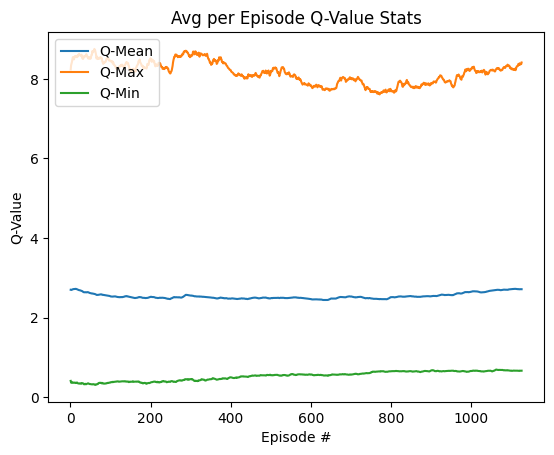

episode: 1126   frame: 233747   proc time: 61.5s   score: 2.0   memory length: 432473   epsilon: 0.29876   steps: 196 steps/sec: 3.19   lr: 8e-05   PER_beta: 0.587 PER Alpha: 0.413   reward MA: 4.2   mean loss: 0.01559   mean max Q: 8.2691
episode: 1127   frame: 233994   proc time: 78.1s   score: 3.0   memory length: 432715   epsilon: 0.29802   steps: 247 steps/sec: 3.16   lr: 8e-05   PER_beta: 0.5872 PER Alpha: 0.4128   reward MA: 4.2   mean loss: 0.01445   mean max Q: 8.4898
[PER STATS] TD-error mean: 0.07130478360768087 std: 0.12633664572173547 min: 0.0 max: 3.91796875
episode: 1128   frame: 234390   proc time: 125.6s   score: 8.0   memory length: 433106   epsilon: 0.29683   steps: 396 steps/sec: 3.15   lr: 8e-05   PER_beta: 0.58751 PER Alpha: 0.41249   reward MA: 4.28   mean loss: 0.01427   mean max Q: 8.4298
episode: 1129   frame: 234748   proc time: 113.0s   score: 6.0   memory length: 433459   epsilon: 0.29576   steps: 358 steps/sec: 3.17   lr: 8e-05   PER_beta: 0.5878 PER Alpha

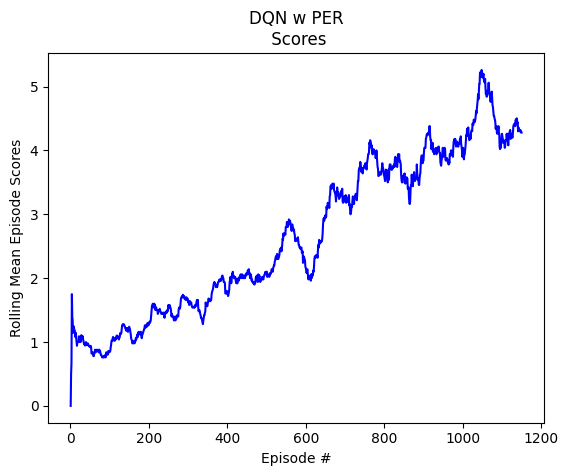

[SAVED PLOT] ./save_graph/run18/Run18_Bootstrapped_run17_stickyactions5percent_ep1150_losses.png


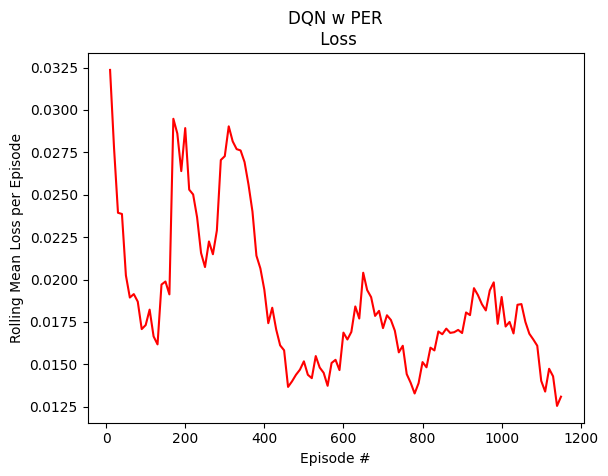

[SAVED PLOT] ./save_graph/run18/Run18_Bootstrapped_run17_stickyactions5percent_ep1150_Qstats.png


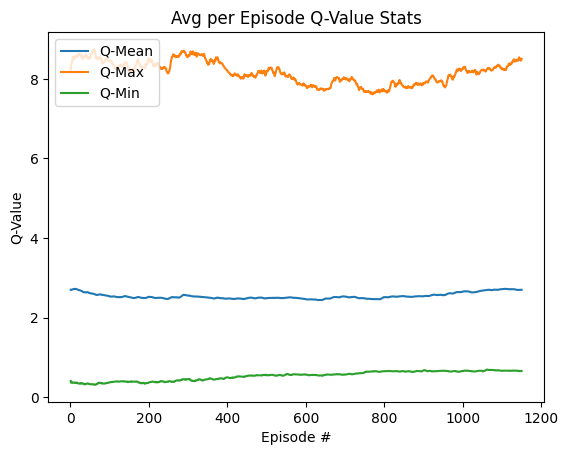

Target network updated at frame:  240000
[PER STATS] TD-error mean: 0.0717366342195765 std: 0.1294724996756631 min: 0.0 max: 3.46875
episode: 1151   frame: 240200   proc time: 67.3s   score: 3.0   memory length: 438801   epsilon: 0.2794   steps: 207 steps/sec: 3.08   lr: 8e-05   PER_beta: 0.59216 PER Alpha: 0.40784   reward MA: 4.28   mean loss: 0.01429   mean max Q: 8.1147
episode: 1152   frame: 240444   proc time: 79.0s   score: 7.0   memory length: 439040   epsilon: 0.27867   steps: 244 steps/sec: 3.09   lr: 8e-05   PER_beta: 0.59236 PER Alpha: 0.40764   reward MA: 4.38   mean loss: 0.01564   mean max Q: 8.5478
episode: 1153   frame: 240651   proc time: 66.5s   score: 3.0   memory length: 439242   epsilon: 0.27805   steps: 207 steps/sec: 3.11   lr: 8e-05   PER_beta: 0.59252 PER Alpha: 0.40748   reward MA: 4.42   mean loss: 0.01528   mean max Q: 8.4089
episode: 1154   frame: 240891   proc time: 77.4s   score: 4.0   memory length: 439477   epsilon: 0.27733   steps: 240 steps/sec: 3.1 

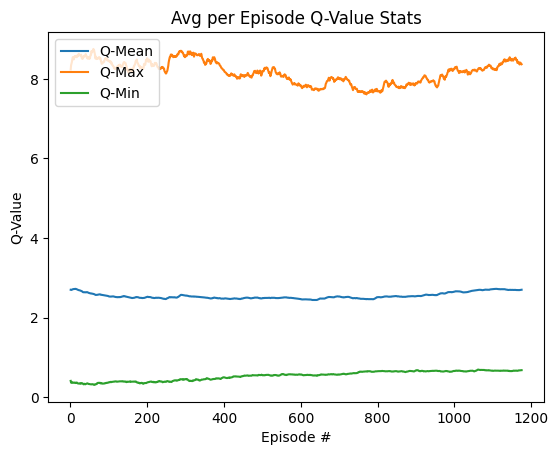

episode: 1176   frame: 246419   proc time: 73.7s   score: 3.0   memory length: 444895   epsilon: 0.26074   steps: 226 steps/sec: 3.06   lr: 8e-05   PER_beta: 0.59714 PER Alpha: 0.40286   reward MA: 4.52   mean loss: 0.01247   mean max Q: 8.5493
episode: 1177   frame: 246659   proc time: 78.9s   score: 4.0   memory length: 445130   epsilon: 0.26002   steps: 240 steps/sec: 3.04   lr: 8e-05   PER_beta: 0.59733 PER Alpha: 0.40267   reward MA: 4.54   mean loss: 0.01339   mean max Q: 8.2224
episode: 1178   frame: 246966   proc time: 100.6s   score: 5.0   memory length: 445432   epsilon: 0.2591   steps: 307 steps/sec: 3.05   lr: 8e-05   PER_beta: 0.59757 PER Alpha: 0.40243   reward MA: 4.48   mean loss: 0.01309   mean max Q: 8.6521
[PER STATS] TD-error mean: 0.07044015972060155 std: 0.1271866088988233 min: 0.0 max: 3.328125
episode: 1179   frame: 247193   proc time: 74.9s   score: 3.0   memory length: 445654   epsilon: 0.25842   steps: 227 steps/sec: 3.03   lr: 8e-05   PER_beta: 0.59775 PER A

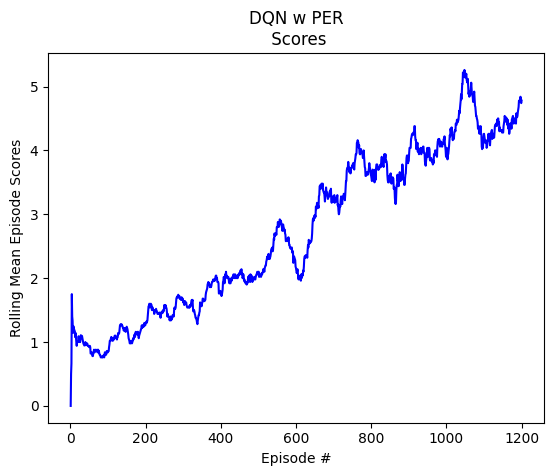

[SAVED PLOT] ./save_graph/run18/Run18_Bootstrapped_run17_stickyactions5percent_ep1200_losses.png


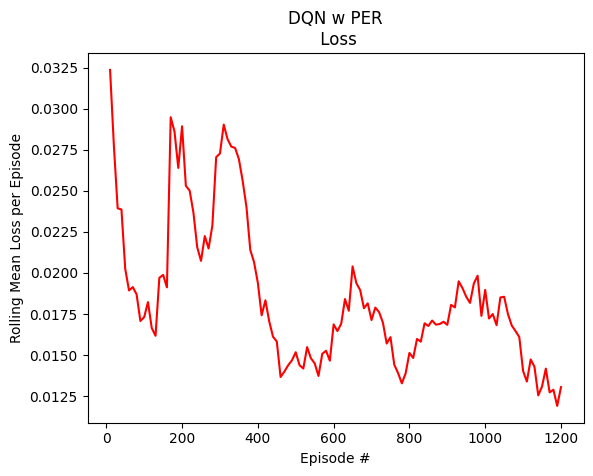

[SAVED PLOT] ./save_graph/run18/Run18_Bootstrapped_run17_stickyactions5percent_ep1200_Qstats.png


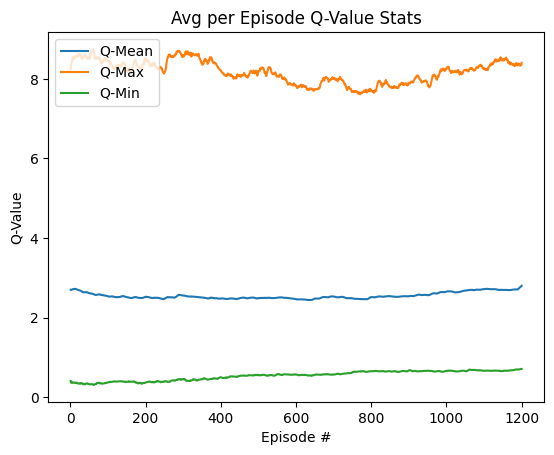

Checkpoint for episode 1200 saved
Replay buffer of 451236 frames saved
[PER STATS] TD-error mean: 0.06961680266168939 std: 0.12505629192626927 min: 0.0 max: 2.607421875
episode: 1201   frame: 253106   proc time: 76.6s   score: 3.0   memory length: 451457   epsilon: 0.24068   steps: 226 steps/sec: 2.95   lr: 8e-05   PER_beta: 0.60248 PER Alpha: 0.39752   reward MA: 4.78   mean loss: 0.0114   mean max Q: 8.7218
episode: 1202   frame: 253343   proc time: 79.8s   score: 4.0   memory length: 451689   epsilon: 0.23997   steps: 237 steps/sec: 2.97   lr: 8e-05   PER_beta: 0.60267 PER Alpha: 0.39733   reward MA: 4.72   mean loss: 0.01151   mean max Q: 8.3722
episode: 1203   frame: 253567   proc time: 75.4s   score: 3.0   memory length: 451908   epsilon: 0.2393   steps: 224 steps/sec: 2.97   lr: 8e-05   PER_beta: 0.60285 PER Alpha: 0.39715   reward MA: 4.72   mean loss: 0.01191   mean max Q: 8.6683
episode: 1204   frame: 253842   proc time: 92.6s   score: 8.0   memory length: 452178   epsilon: 0

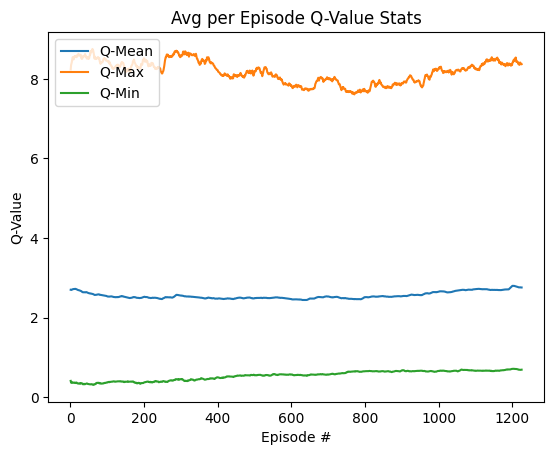

episode: 1226   frame: 259823   proc time: 71.7s   score: 3.0   memory length: 458049   epsilon: 0.22053   steps: 209 steps/sec: 2.91   lr: 8e-05   PER_beta: 0.60786 PER Alpha: 0.39214   reward MA: 5.44   mean loss: 0.01386   mean max Q: 8.2365
Target network updated at frame:  260000
[PER STATS] TD-error mean: 0.06944414752343844 std: 0.12422495792911883 min: 0.0 max: 3.560546875
episode: 1227   frame: 260064   proc time: 83.5s   score: 4.0   memory length: 458285   epsilon: 0.21981   steps: 241 steps/sec: 2.89   lr: 8e-05   PER_beta: 0.60805 PER Alpha: 0.39195   reward MA: 5.44   mean loss: 0.01388   mean max Q: 8.5089
episode: 1228   frame: 260354   proc time: 99.9s   score: 8.0   memory length: 458570   epsilon: 0.21894   steps: 290 steps/sec: 2.9   lr: 8e-05   PER_beta: 0.60828 PER Alpha: 0.39172   reward MA: 5.5   mean loss: 0.01391   mean max Q: 8.6478
episode: 1229   frame: 260595   proc time: 82.9s   score: 7.0   memory length: 458806   epsilon: 0.21822   steps: 241 steps/sec:

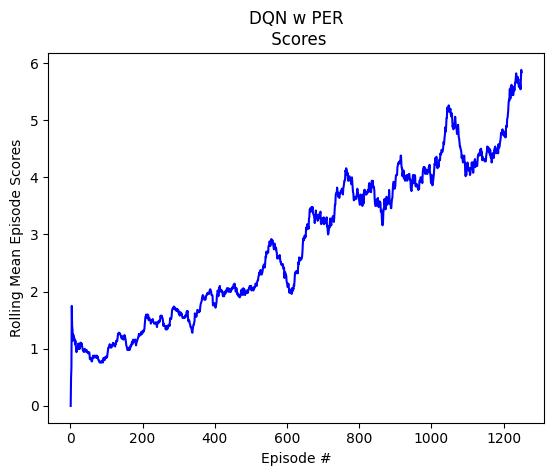

[SAVED PLOT] ./save_graph/run18/Run18_Bootstrapped_run17_stickyactions5percent_ep1250_losses.png


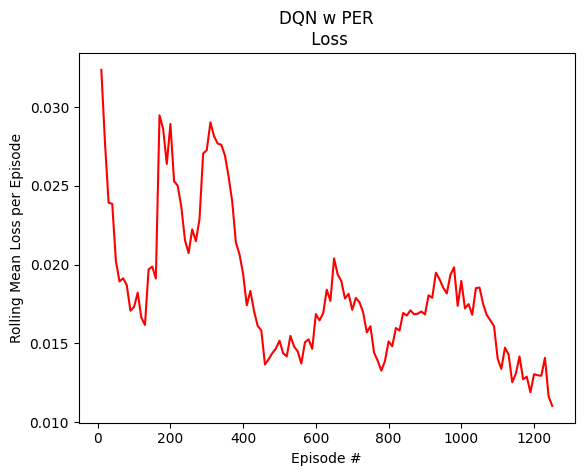

[SAVED PLOT] ./save_graph/run18/Run18_Bootstrapped_run17_stickyactions5percent_ep1250_Qstats.png


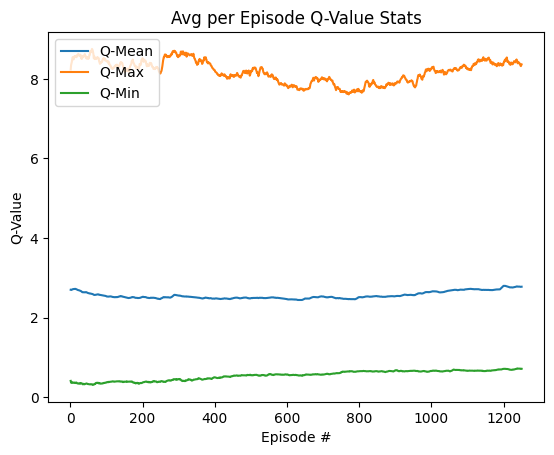

episode: 1251   frame: 266383   proc time: 120.1s   score: 9.0   memory length: 464484   epsilon: 0.20085   steps: 338 steps/sec: 2.81   lr: 8e-05   PER_beta: 0.61311 PER Alpha: 0.38689   reward MA: 5.96   mean loss: 0.01068   mean max Q: 8.3218
episode: 1252   frame: 266819   proc time: 153.9s   score: 8.0   memory length: 464915   epsilon: 0.19954   steps: 436 steps/sec: 2.83   lr: 8e-05   PER_beta: 0.61346 PER Alpha: 0.38654   reward MA: 6.04   mean loss: 0.01055   mean max Q: 8.3349
[PER STATS] TD-error mean: 0.0692396036616414 std: 0.1251434949839343 min: 0.0 max: 3.17822265625
episode: 1253   frame: 267030   proc time: 74.5s   score: 3.0   memory length: 465121   epsilon: 0.19891   steps: 211 steps/sec: 2.83   lr: 8e-05   PER_beta: 0.61362 PER Alpha: 0.38638   reward MA: 6.04   mean loss: 0.01165   mean max Q: 8.5305
episode: 1254   frame: 267288   proc time: 90.9s   score: 4.0   memory length: 465374   epsilon: 0.19814   steps: 258 steps/sec: 2.84   lr: 8e-05   PER_beta: 0.61383

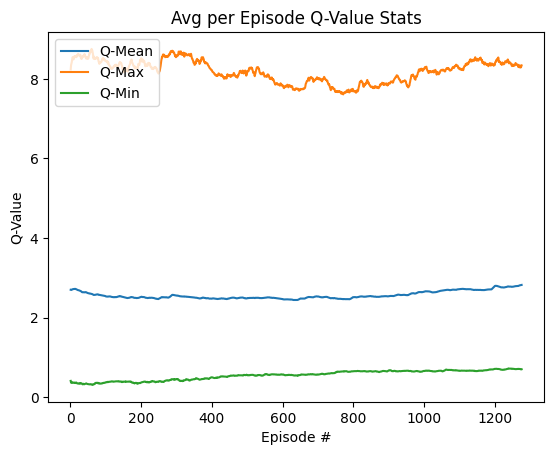

episode: 1276   frame: 272914   proc time: 103.7s   score: 8.0   memory length: 470890   epsilon: 0.18126   steps: 290 steps/sec: 2.8   lr: 8e-05   PER_beta: 0.61833 PER Alpha: 0.38167   reward MA: 5.56   mean loss: 0.01476   mean max Q: 8.2257
[PER STATS] TD-error mean: 0.07002892329137016 std: 0.12643944194577694 min: 0.0 max: 2.625
episode: 1277   frame: 273262   proc time: 124.6s   score: 8.0   memory length: 471233   epsilon: 0.18021   steps: 348 steps/sec: 2.79   lr: 8e-05   PER_beta: 0.61861 PER Alpha: 0.38139   reward MA: 5.64   mean loss: 0.01361   mean max Q: 8.248
episode: 1278   frame: 273503   proc time: 85.9s   score: 7.0   memory length: 471469   epsilon: 0.17949   steps: 241 steps/sec: 2.8   lr: 8e-05   PER_beta: 0.6188 PER Alpha: 0.3812   reward MA: 5.62   mean loss: 0.01318   mean max Q: 8.6248
episode: 1279   frame: 273652   proc time: 53.0s   score: 1.0   memory length: 471613   epsilon: 0.17904   steps: 149 steps/sec: 2.81   lr: 8e-05   PER_beta: 0.61892 PER Alpha:

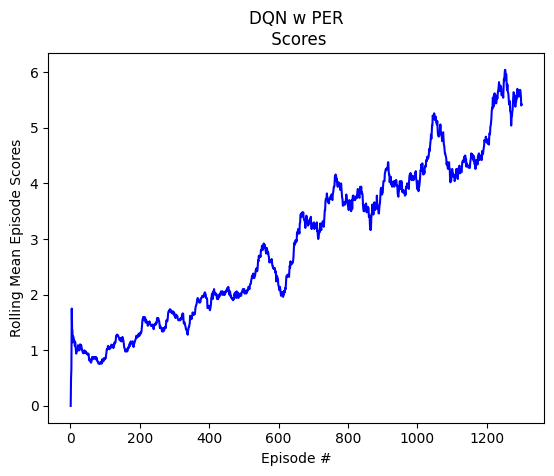

[SAVED PLOT] ./save_graph/run18/Run18_Bootstrapped_run17_stickyactions5percent_ep1300_losses.png


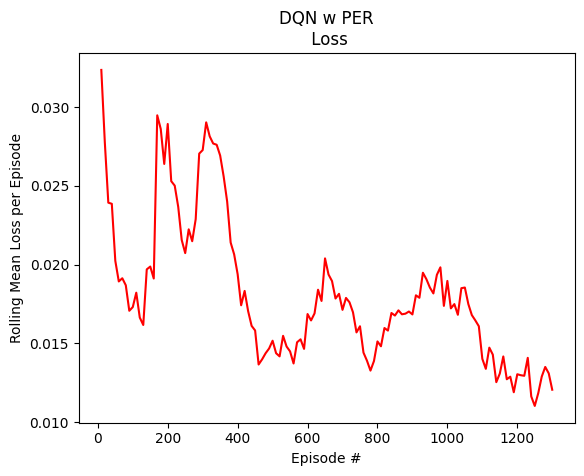

[SAVED PLOT] ./save_graph/run18/Run18_Bootstrapped_run17_stickyactions5percent_ep1300_Qstats.png


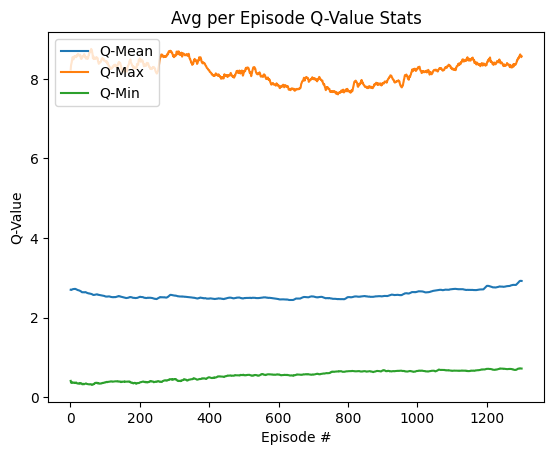

Checkpoint for episode 1300 saved
episode: 1301   frame: 279708   proc time: 95.2s   score: 11.0   memory length: 477559   epsilon: 0.16088   steps: 262 steps/sec: 2.75   lr: 8e-05   PER_beta: 0.62377 PER Alpha: 0.37623   reward MA: 5.46   mean loss: 0.01115   mean max Q: 8.5167
Target network updated at frame:  280000
[PER STATS] TD-error mean: 0.06971984161180009 std: 0.12157086183405283 min: 0.0 max: 2.888671875
episode: 1302   frame: 280133   proc time: 156.0s   score: 8.0   memory length: 477979   epsilon: 0.1596   steps: 425 steps/sec: 2.72   lr: 8e-05   PER_beta: 0.62411 PER Alpha: 0.37589   reward MA: 5.46   mean loss: 0.01127   mean max Q: 8.9022
episode: 1303   frame: 280311   proc time: 64.7s   score: 2.0   memory length: 478152   epsilon: 0.15907   steps: 178 steps/sec: 2.75   lr: 8e-05   PER_beta: 0.62425 PER Alpha: 0.37575   reward MA: 5.44   mean loss: 0.01188   mean max Q: 8.3569
episode: 1304   frame: 280566   proc time: 93.1s   score: 4.0   memory length: 478402   eps

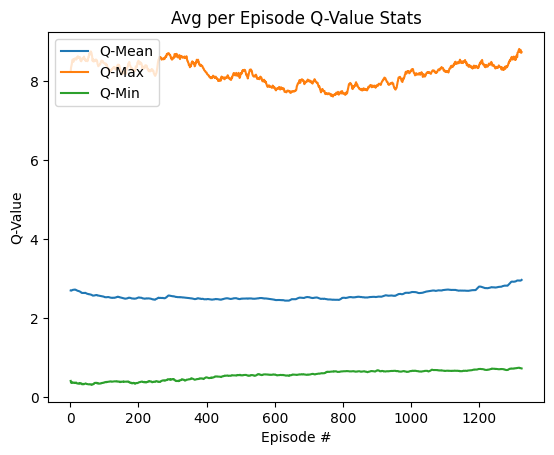

[PER STATS] TD-error mean: 0.06893572831409692 std: 0.12084761164366323 min: 0.0 max: 2.763671875
episode: 1326   frame: 286237   proc time: 109.4s   score: 5.0   memory length: 483963   epsilon: 0.14129   steps: 290 steps/sec: 2.65   lr: 8e-05   PER_beta: 0.62899 PER Alpha: 0.37101   reward MA: 5.32   mean loss: 0.01145   mean max Q: 8.9671
episode: 1327   frame: 286544   proc time: 119.4s   score: 5.0   memory length: 484265   epsilon: 0.14037   steps: 307 steps/sec: 2.57   lr: 8e-05   PER_beta: 0.62924 PER Alpha: 0.37076   reward MA: 5.26   mean loss: 0.01323   mean max Q: 8.8699
episode: 1328   frame: 286740   proc time: 75.2s   score: 2.0   memory length: 484456   epsilon: 0.13978   steps: 196 steps/sec: 2.61   lr: 8e-05   PER_beta: 0.62939 PER Alpha: 0.37061   reward MA: 5.16   mean loss: 0.01275   mean max Q: 8.9078
[PER STATS] TD-error mean: 0.0691525818660464 std: 0.1222043209057308 min: 0.0 max: 2.919921875
episode: 1329   frame: 287012   proc time: 105.1s   score: 8.0   memo

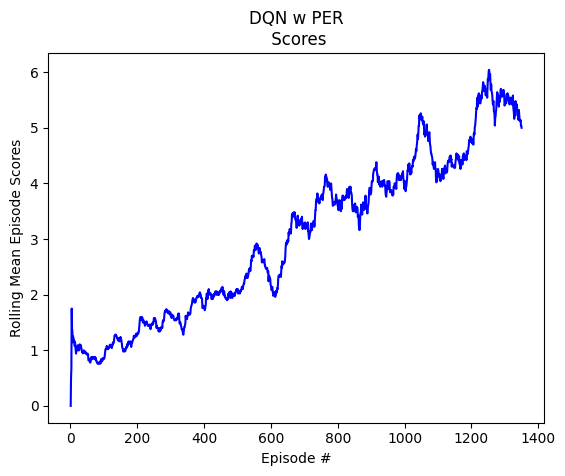

[SAVED PLOT] ./save_graph/run18/Run18_Bootstrapped_run17_stickyactions5percent_ep1350_losses.png


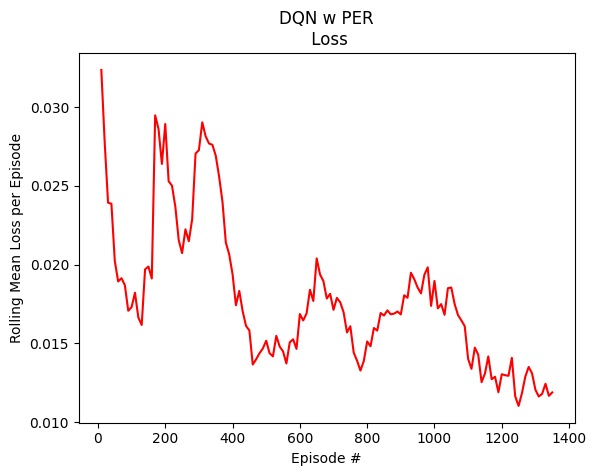

[SAVED PLOT] ./save_graph/run18/Run18_Bootstrapped_run17_stickyactions5percent_ep1350_Qstats.png


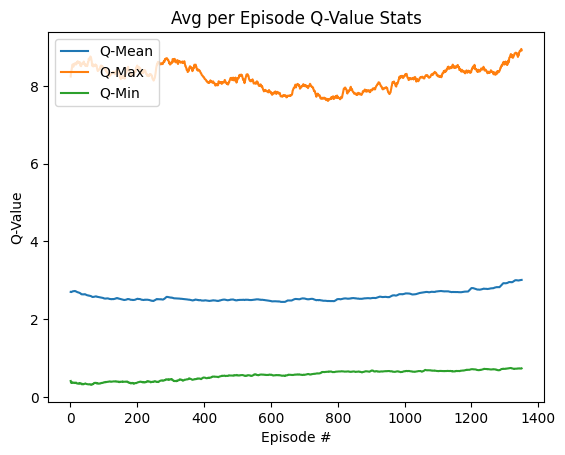

episode: 1351   frame: 292507   proc time: 118.1s   score: 5.0   memory length: 490108   epsilon: 0.12248   steps: 304 steps/sec: 2.57   lr: 8e-05   PER_beta: 0.63401 PER Alpha: 0.36599   reward MA: 4.88   mean loss: 0.01287   mean max Q: 8.8162
episode: 1352   frame: 292803   proc time: 113.7s   score: 12.0   memory length: 490399   epsilon: 0.12159   steps: 296 steps/sec: 2.6   lr: 8e-05   PER_beta: 0.63424 PER Alpha: 0.36576   reward MA: 4.96   mean loss: 0.01131   mean max Q: 9.0039
[PER STATS] TD-error mean: 0.06918592320862332 std: 0.12353549515853517 min: 0.0 max: 3.3984375
episode: 1353   frame: 293158   proc time: 143.7s   score: 6.0   memory length: 490749   epsilon: 0.12053   steps: 355 steps/sec: 2.47   lr: 8e-05   PER_beta: 0.63453 PER Alpha: 0.36547   reward MA: 5.04   mean loss: 0.01217   mean max Q: 8.5563
episode: 1354   frame: 293340   proc time: 71.1s   score: 2.0   memory length: 490926   epsilon: 0.11998   steps: 182 steps/sec: 2.56   lr: 8e-05   PER_beta: 0.63467 

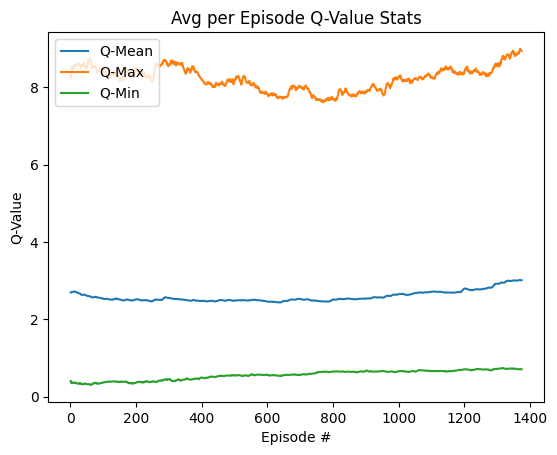

episode: 1376   frame: 298843   proc time: 113.5s   score: 4.0   memory length: 496319   epsilon: 0.10347   steps: 273 steps/sec: 2.4   lr: 8e-05   PER_beta: 0.63907 PER Alpha: 0.36093   reward MA: 4.78   mean loss: 0.01289   mean max Q: 9.1645
[PER STATS] TD-error mean: 0.06842941753614858 std: 0.12354175348559038 min: 0.0 max: 3.841796875
episode: 1377   frame: 299052   proc time: 83.5s   score: 3.0   memory length: 496523   epsilon: 0.10284   steps: 209 steps/sec: 2.5   lr: 8e-05   PER_beta: 0.63924 PER Alpha: 0.36076   reward MA: 4.74   mean loss: 0.01216   mean max Q: 9.0392
episode: 1378   frame: 299230   proc time: 70.3s   score: 2.0   memory length: 496696   epsilon: 0.10231   steps: 178 steps/sec: 2.53   lr: 8e-05   PER_beta: 0.63938 PER Alpha: 0.36062   reward MA: 4.74   mean loss: 0.01261   mean max Q: 9.0178
episode: 1379   frame: 299564   proc time: 132.5s   score: 6.0   memory length: 497025   epsilon: 0.10131   steps: 334 steps/sec: 2.52   lr: 8e-05   PER_beta: 0.63965 P

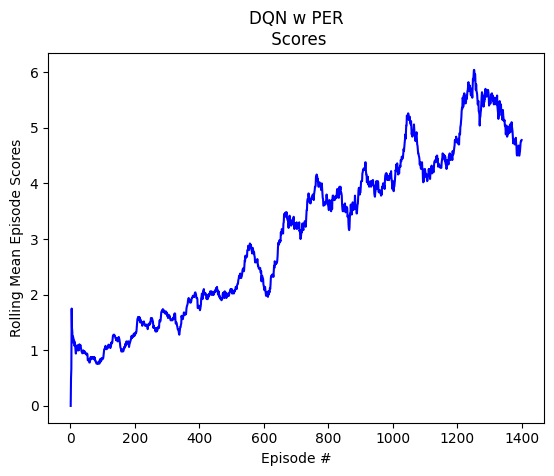

[SAVED PLOT] ./save_graph/run18/Run18_Bootstrapped_run17_stickyactions5percent_ep1400_losses.png


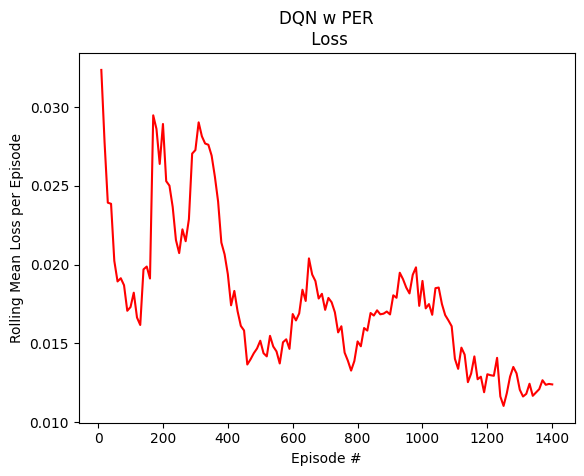

[SAVED PLOT] ./save_graph/run18/Run18_Bootstrapped_run17_stickyactions5percent_ep1400_Qstats.png


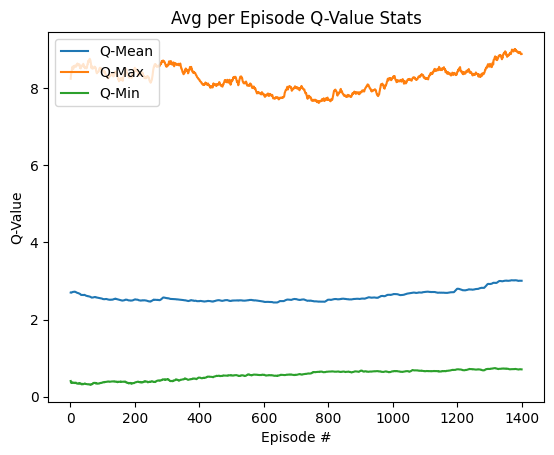

Checkpoint for episode 1400 saved
Replay buffer of 502676 frames saved
episode: 1401   frame: 305578   proc time: 103.3s   score: 4.0   memory length: 502929   epsilon: 0.1   steps: 258 steps/sec: 2.5   lr: 3.2000000000000005e-05   PER_beta: 0.64446 PER Alpha: 0.35554   reward MA: 4.76   mean loss: 0.01503   mean max Q: 8.9665
episode: 1402   frame: 305917   proc time: 137.4s   score: 6.0   memory length: 503263   epsilon: 0.1   steps: 339 steps/sec: 2.47   lr: 3.2000000000000005e-05   PER_beta: 0.64473 PER Alpha: 0.35527   reward MA: 4.64   mean loss: 0.01496   mean max Q: 9.1766
[PER STATS] TD-error mean: 0.0702382817982136 std: 0.12880083224288535 min: 0.0 max: 3.919921875
episode: 1403   frame: 306210   proc time: 118.1s   score: 8.0   memory length: 503551   epsilon: 0.1   steps: 293 steps/sec: 2.48   lr: 3.2000000000000005e-05   PER_beta: 0.64497 PER Alpha: 0.35503   reward MA: 4.68   mean loss: 0.01383   mean max Q: 8.7418
episode: 1404   frame: 306533   proc time: 128.9s   scor

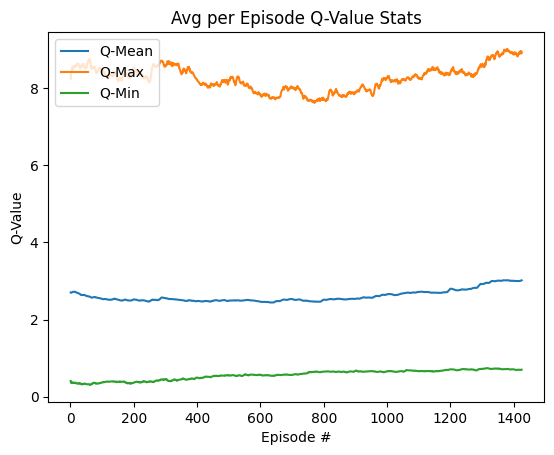

episode: 1426   frame: 312472   proc time: 58.3s   score: 1.0   memory length: 509698   epsilon: 0.1   steps: 149 steps/sec: 2.56   lr: 3.2000000000000005e-05   PER_beta: 0.64998 PER Alpha: 0.35002   reward MA: 5.2   mean loss: 0.01262   mean max Q: 9.3561
episode: 1427   frame: 312592   proc time: 43.6s   score: 0.0   memory length: 509813   epsilon: 0.1   steps: 120 steps/sec: 2.75   lr: 3.2000000000000005e-05   PER_beta: 0.65007 PER Alpha: 0.34993   reward MA: 5.14   mean loss: 0.01267   mean max Q: 8.5387
episode: 1428   frame: 312854   proc time: 95.2s   score: 11.0   memory length: 510070   epsilon: 0.1   steps: 262 steps/sec: 2.75   lr: 3.2000000000000005e-05   PER_beta: 0.65028 PER Alpha: 0.34972   reward MA: 5.32   mean loss: 0.01408   mean max Q: 8.7227
[PER STATS] TD-error mean: 0.07047642084672374 std: 0.12657896757244919 min: 0.0 max: 3.892578125
episode: 1429   frame: 313129   proc time: 101.0s   score: 8.0   memory length: 510340   epsilon: 0.1   steps: 275 steps/sec: 2.

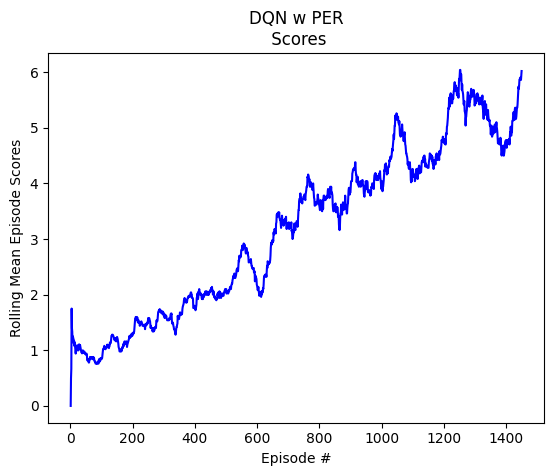

[SAVED PLOT] ./save_graph/run18/Run18_Bootstrapped_run17_stickyactions5percent_ep1450_losses.png


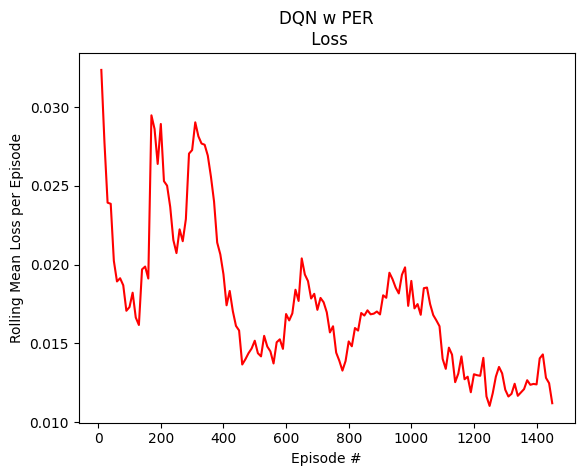

[SAVED PLOT] ./save_graph/run18/Run18_Bootstrapped_run17_stickyactions5percent_ep1450_Qstats.png


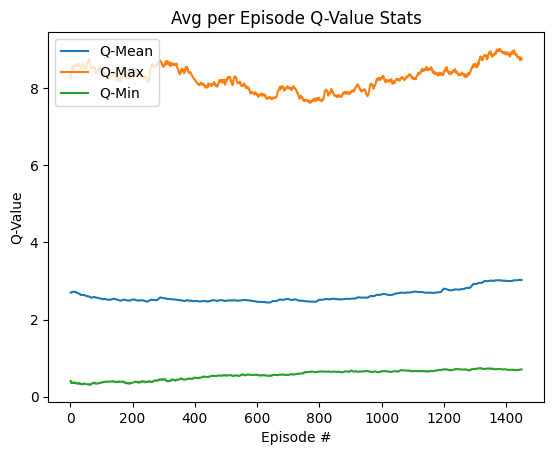

episode: 1451   frame: 319884   proc time: 175.5s   score: 12.0   memory length: 516985   epsilon: 0.1   steps: 468 steps/sec: 2.67   lr: 3.2000000000000005e-05   PER_beta: 0.65591 PER Alpha: 0.34409   reward MA: 6.18   mean loss: 0.01127   mean max Q: 8.8306
Target network updated at frame:  320000
[PER STATS] TD-error mean: 0.0684499517625586 std: 0.12433225977795266 min: 0.0 max: 17.6484375
episode: 1452   frame: 320191   proc time: 115.9s   score: 5.0   memory length: 517287   epsilon: 0.1   steps: 307 steps/sec: 2.65   lr: 3.2000000000000005e-05   PER_beta: 0.65615 PER Alpha: 0.34385   reward MA: 6.16   mean loss: 0.0103   mean max Q: 9.0483
episode: 1453   frame: 320558   proc time: 137.6s   score: 10.0   memory length: 517649   epsilon: 0.1   steps: 367 steps/sec: 2.67   lr: 3.2000000000000005e-05   PER_beta: 0.65645 PER Alpha: 0.34355   reward MA: 6.2   mean loss: 0.01347   mean max Q: 8.8959
episode: 1454   frame: 320848   proc time: 108.2s   score: 8.0   memory length: 517934

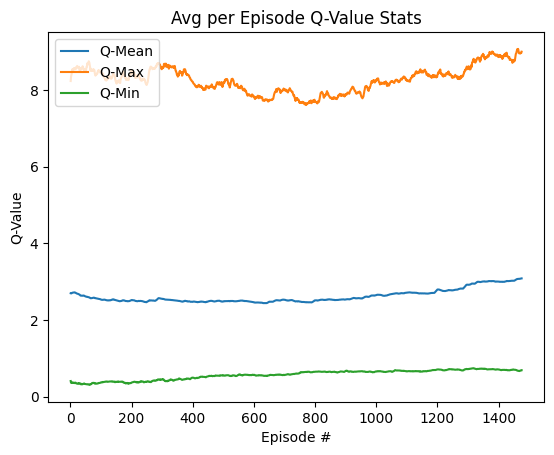

[PER STATS] TD-error mean: 0.06885824809756988 std: 0.12410302125360252 min: 0.0 max: 17.2421875
episode: 1476   frame: 327023   proc time: 97.2s   score: 4.0   memory length: 523999   epsilon: 0.1   steps: 256 steps/sec: 2.63   lr: 3.2000000000000005e-05   PER_beta: 0.66162 PER Alpha: 0.33838   reward MA: 6.26   mean loss: 0.01473   mean max Q: 9.1034
episode: 1477   frame: 327311   proc time: 109.3s   score: 5.0   memory length: 524282   epsilon: 0.1   steps: 288 steps/sec: 2.63   lr: 3.2000000000000005e-05   PER_beta: 0.66185 PER Alpha: 0.33815   reward MA: 6.36   mean loss: 0.01253   mean max Q: 9.0044
episode: 1478   frame: 327618   proc time: 116.7s   score: 5.0   memory length: 524584   epsilon: 0.1   steps: 307 steps/sec: 2.63   lr: 3.2000000000000005e-05   PER_beta: 0.66209 PER Alpha: 0.33791   reward MA: 6.24   mean loss: 0.01514   mean max Q: 9.0758
episode: 1479   frame: 327944   proc time: 124.7s   score: 5.0   memory length: 524905   epsilon: 0.1   steps: 326 steps/sec: 2

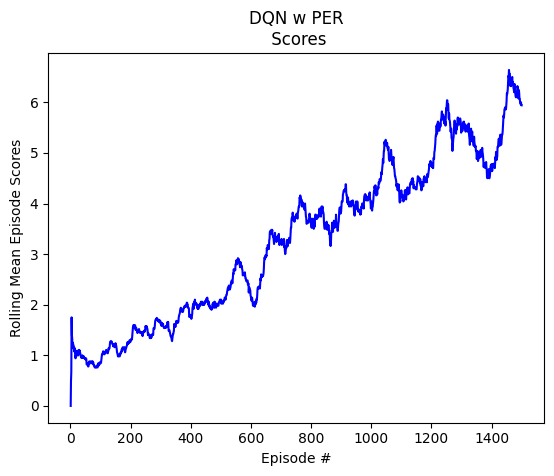

[SAVED PLOT] ./save_graph/run18/Run18_Bootstrapped_run17_stickyactions5percent_ep1500_losses.png


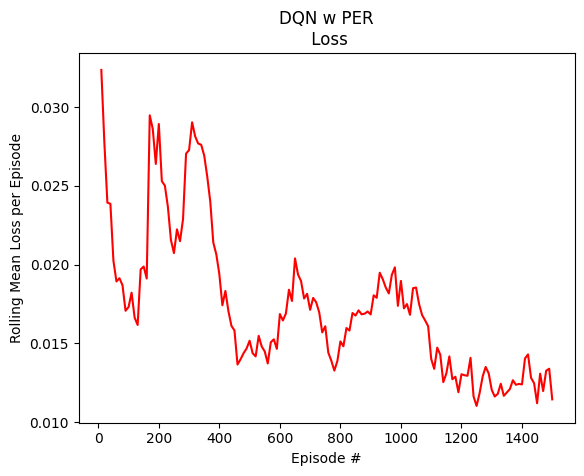

[SAVED PLOT] ./save_graph/run18/Run18_Bootstrapped_run17_stickyactions5percent_ep1500_Qstats.png


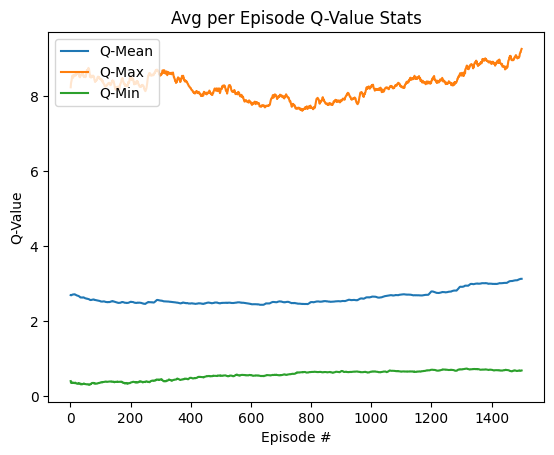

Checkpoint for episode 1500 saved
episode: 1501   frame: 334482   proc time: 113.1s   score: 8.0   memory length: 531333   epsilon: 0.1   steps: 291 steps/sec: 2.57   lr: 3.2000000000000005e-05   PER_beta: 0.66759 PER Alpha: 0.33241   reward MA: 5.86   mean loss: 0.01156   mean max Q: 9.308
episode: 1502   frame: 334860   proc time: 147.8s   score: 6.0   memory length: 531706   epsilon: 0.1   steps: 378 steps/sec: 2.56   lr: 3.2000000000000005e-05   PER_beta: 0.66789 PER Alpha: 0.33211   reward MA: 5.88   mean loss: 0.01199   mean max Q: 9.2771
Target network updated at frame:  335000
[PER STATS] TD-error mean: 0.06839040527190557 std: 0.12531371247122802 min: 0.0 max: 17.09375
episode: 1503   frame: 335116   proc time: 100.8s   score: 4.0   memory length: 531957   epsilon: 0.1   steps: 256 steps/sec: 2.54   lr: 3.2000000000000005e-05   PER_beta: 0.66809 PER Alpha: 0.33191   reward MA: 5.76   mean loss: 0.01196   mean max Q: 9.2137
episode: 1504   frame: 335388   proc time: 107.1s   sc

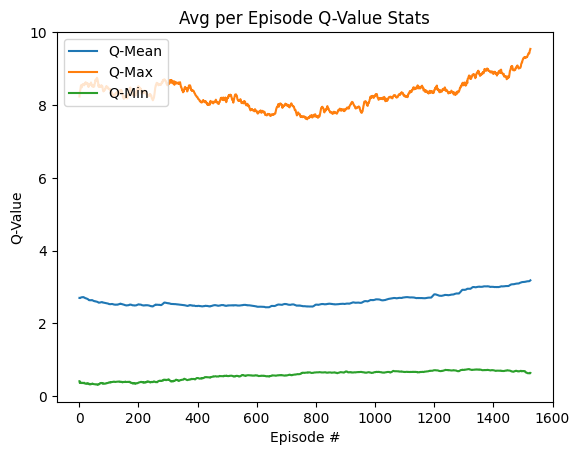

[PER STATS] TD-error mean: 0.06925005556986542 std: 0.1229494272257994 min: 0.0 max: 16.6875
episode: 1526   frame: 341043   proc time: 114.9s   score: 8.0   memory length: 537769   epsilon: 0.1   steps: 290 steps/sec: 2.52   lr: 3.2000000000000005e-05   PER_beta: 0.67283 PER Alpha: 0.32717   reward MA: 5.7   mean loss: 0.01118   mean max Q: 9.747
episode: 1527   frame: 341299   proc time: 101.0s   score: 4.0   memory length: 538020   epsilon: 0.1   steps: 256 steps/sec: 2.54   lr: 3.2000000000000005e-05   PER_beta: 0.67304 PER Alpha: 0.32696   reward MA: 5.68   mean loss: 0.01583   mean max Q: 9.4825
episode: 1528   frame: 341572   proc time: 108.1s   score: 8.0   memory length: 538288   epsilon: 0.1   steps: 273 steps/sec: 2.53   lr: 3.2000000000000005e-05   PER_beta: 0.67326 PER Alpha: 0.32674   reward MA: 5.74   mean loss: 0.01012   mean max Q: 9.3043
episode: 1529   frame: 341797   proc time: 89.2s   score: 3.0   memory length: 538508   epsilon: 0.1   steps: 225 steps/sec: 2.52   

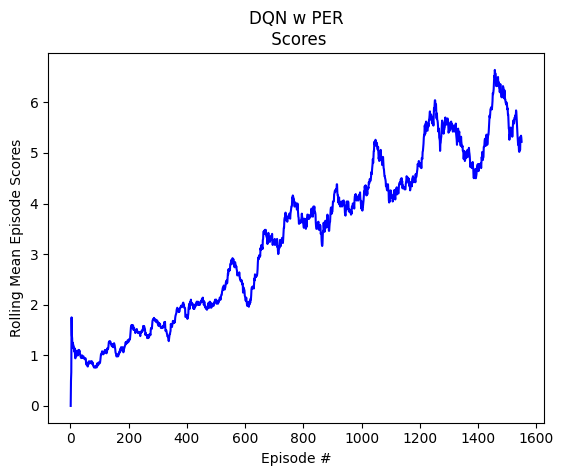

[SAVED PLOT] ./save_graph/run18/Run18_Bootstrapped_run17_stickyactions5percent_ep1550_losses.png


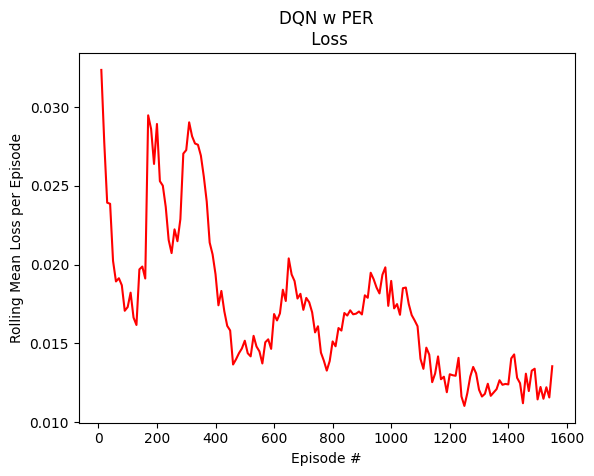

[SAVED PLOT] ./save_graph/run18/Run18_Bootstrapped_run17_stickyactions5percent_ep1550_Qstats.png


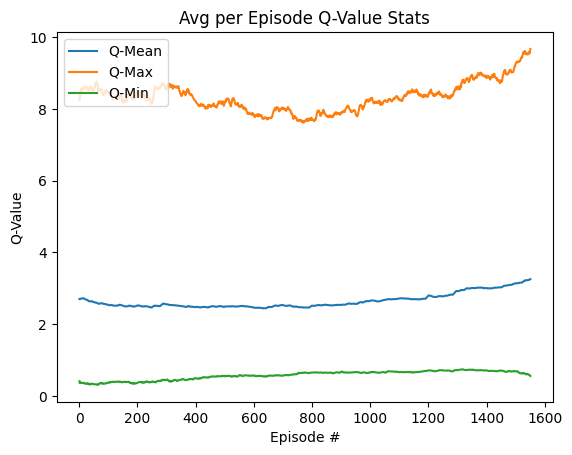

episode: 1551   frame: 347349   proc time: 105.0s   score: 4.0   memory length: 543950   epsilon: 0.1   steps: 238 steps/sec: 2.27   lr: 3.2000000000000005e-05   PER_beta: 0.67788 PER Alpha: 0.32212   reward MA: 5.14   mean loss: 0.01279   mean max Q: 9.7576
episode: 1552   frame: 347586   proc time: 104.9s   score: 4.0   memory length: 544182   epsilon: 0.1   steps: 237 steps/sec: 2.26   lr: 3.2000000000000005e-05   PER_beta: 0.67807 PER Alpha: 0.32193   reward MA: 5.1   mean loss: 0.01292   mean max Q: 10.0128
episode: 1553   frame: 347934   proc time: 155.5s   score: 5.0   memory length: 544525   epsilon: 0.1   steps: 348 steps/sec: 2.24   lr: 3.2000000000000005e-05   PER_beta: 0.67835 PER Alpha: 0.32165   reward MA: 5.12   mean loss: 0.01465   mean max Q: 9.5706
[PER STATS] TD-error mean: 0.07148433439583098 std: 0.12849384927296228 min: 0.0 max: 16.8203125
episode: 1554   frame: 348250   proc time: 140.6s   score: 6.0   memory length: 544836   epsilon: 0.1   steps: 316 steps/sec: 

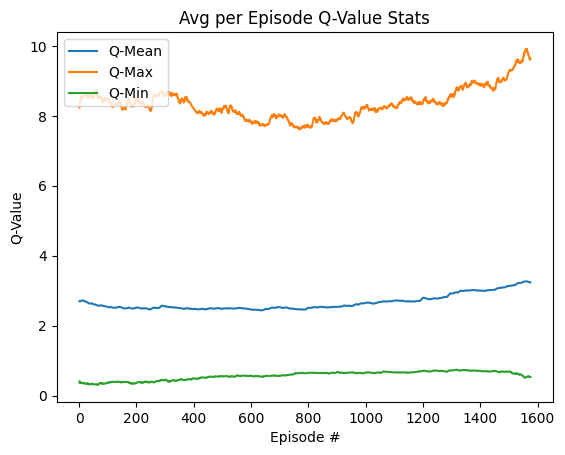

[PER STATS] TD-error mean: 0.06994127108923319 std: 0.12687655255874872 min: 0.0 max: 16.91015625
episode: 1576   frame: 354157   proc time: 145.7s   score: 5.0   memory length: 550633   epsilon: 0.1   steps: 321 steps/sec: 2.2   lr: 3.2000000000000005e-05   PER_beta: 0.68333 PER Alpha: 0.31667   reward MA: 4.74   mean loss: 0.01155   mean max Q: 9.7798
episode: 1577   frame: 354447   proc time: 130.6s   score: 8.0   memory length: 550918   epsilon: 0.1   steps: 290 steps/sec: 2.22   lr: 3.2000000000000005e-05   PER_beta: 0.68356 PER Alpha: 0.31644   reward MA: 4.82   mean loss: 0.01065   mean max Q: 9.7514
episode: 1578   frame: 354766   proc time: 143.8s   score: 6.0   memory length: 551232   epsilon: 0.1   steps: 319 steps/sec: 2.22   lr: 3.2000000000000005e-05   PER_beta: 0.68381 PER Alpha: 0.31619   reward MA: 4.78   mean loss: 0.01495   mean max Q: 9.7378
Target network updated at frame:  355000
[PER STATS] TD-error mean: 0.06966590295886627 std: 0.12622945487171294 min: 0.0 max:

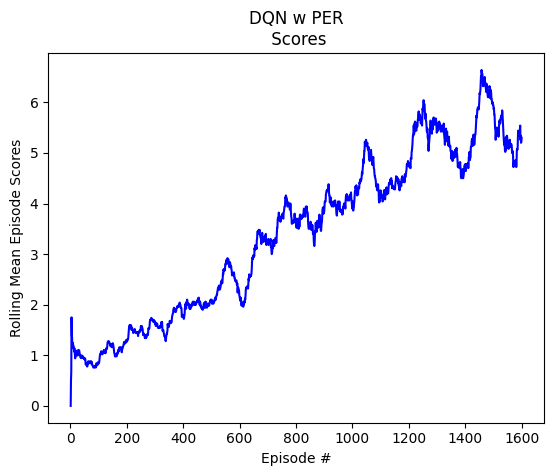

[SAVED PLOT] ./save_graph/run18/Run18_Bootstrapped_run17_stickyactions5percent_ep1600_losses.png


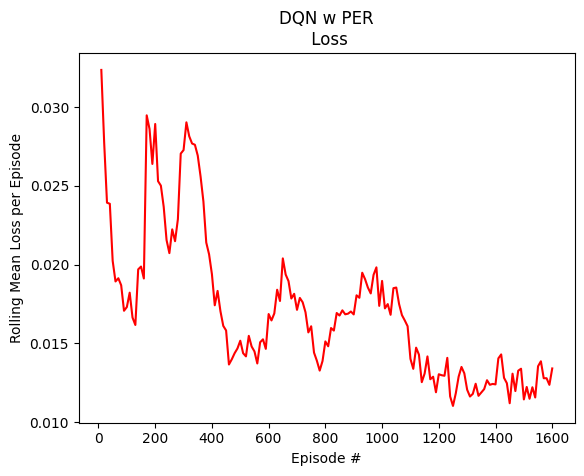

[SAVED PLOT] ./save_graph/run18/Run18_Bootstrapped_run17_stickyactions5percent_ep1600_Qstats.png


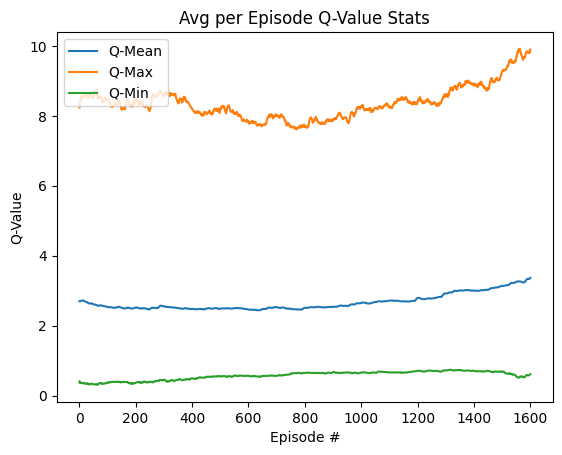

Checkpoint for episode 1600 saved
Replay buffer of 557880 frames saved
episode: 1601   frame: 361780   proc time: 126.6s   score: 4.0   memory length: 558131   epsilon: 0.1   steps: 256 steps/sec: 2.02   lr: 3.2000000000000005e-05   PER_beta: 0.68942 PER Alpha: 0.31058   reward MA: 5.3   mean loss: 0.01415   mean max Q: 10.2954
[PER STATS] TD-error mean: 0.07038621612162266 std: 0.1290527423554887 min: 0.0 max: 14.37890625
episode: 1602   frame: 362053   proc time: 137.6s   score: 4.0   memory length: 558399   epsilon: 0.1   steps: 273 steps/sec: 1.98   lr: 3.2000000000000005e-05   PER_beta: 0.68964 PER Alpha: 0.31036   reward MA: 5.3   mean loss: 0.01302   mean max Q: 10.1172
episode: 1603   frame: 362231   proc time: 86.7s   score: 2.0   memory length: 558572   epsilon: 0.1   steps: 178 steps/sec: 2.05   lr: 3.2000000000000005e-05   PER_beta: 0.68978 PER Alpha: 0.31022   reward MA: 5.24   mean loss: 0.01297   mean max Q: 10.3049
episode: 1604   frame: 362541   proc time: 152.3s   sco

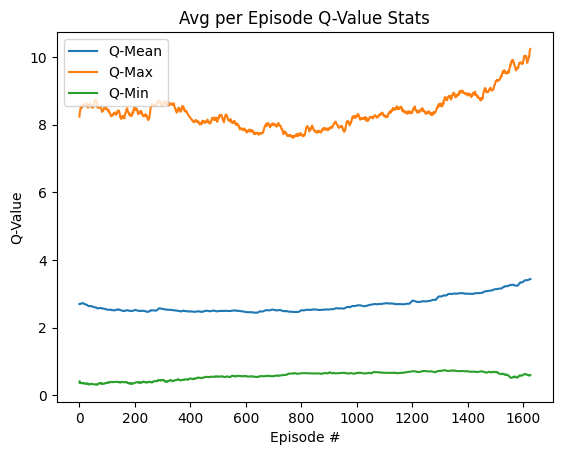

episode: 1626   frame: 368591   proc time: 59.5s   score: 0.0   memory length: 564817   epsilon: 0.1   steps: 120 steps/sec: 2.02   lr: 3.2000000000000005e-05   PER_beta: 0.69487 PER Alpha: 0.30513   reward MA: 5.28   mean loss: 0.0155   mean max Q: 9.867
episode: 1627   frame: 368859   proc time: 132.7s   score: 8.0   memory length: 565080   epsilon: 0.1   steps: 268 steps/sec: 2.02   lr: 3.2000000000000005e-05   PER_beta: 0.69509 PER Alpha: 0.30491   reward MA: 5.28   mean loss: 0.01879   mean max Q: 10.1884
[PER STATS] TD-error mean: 0.07335538467009058 std: 0.13723243393758244 min: 0.0 max: 16.0859375
episode: 1628   frame: 369120   proc time: 131.1s   score: 4.0   memory length: 565336   epsilon: 0.1   steps: 261 steps/sec: 1.99   lr: 3.2000000000000005e-05   PER_beta: 0.6953 PER Alpha: 0.3047   reward MA: 5.24   mean loss: 0.01489   mean max Q: 10.2095
episode: 1629   frame: 369346   proc time: 113.2s   score: 3.0   memory length: 565557   epsilon: 0.1   steps: 226 steps/sec: 2.0

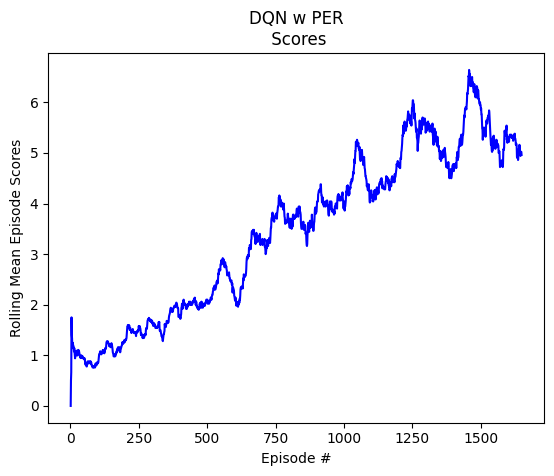

[SAVED PLOT] ./save_graph/run18/Run18_Bootstrapped_run17_stickyactions5percent_ep1650_losses.png


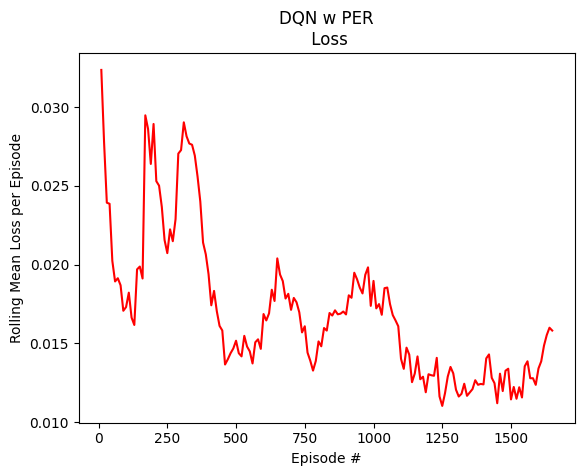

[SAVED PLOT] ./save_graph/run18/Run18_Bootstrapped_run17_stickyactions5percent_ep1650_Qstats.png


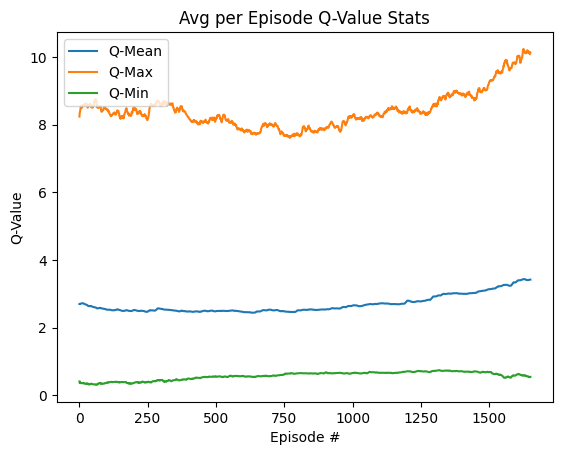

episode: 1651   frame: 375611   proc time: 131.1s   score: 8.0   memory length: 571712   epsilon: 0.1   steps: 275 steps/sec: 2.1   lr: 3.2000000000000005e-05   PER_beta: 0.70049 PER Alpha: 0.29951   reward MA: 5.04   mean loss: 0.01575   mean max Q: 10.5715
episode: 1652   frame: 375867   proc time: 122.7s   score: 4.0   memory length: 571963   epsilon: 0.1   steps: 256 steps/sec: 2.09   lr: 3.2000000000000005e-05   PER_beta: 0.70069 PER Alpha: 0.29931   reward MA: 5.04   mean loss: 0.01619   mean max Q: 10.1257
[PER STATS] TD-error mean: 0.07485184690226405 std: 0.13743838574261388 min: 0.0 max: 14.7109375
episode: 1653   frame: 376075   proc time: 101.2s   score: 3.0   memory length: 572166   epsilon: 0.1   steps: 208 steps/sec: 2.06   lr: 3.2000000000000005e-05   PER_beta: 0.70086 PER Alpha: 0.29914   reward MA: 5.06   mean loss: 0.01849   mean max Q: 10.9253
episode: 1654   frame: 376432   proc time: 168.3s   score: 10.0   memory length: 572518   epsilon: 0.1   steps: 357 steps/se

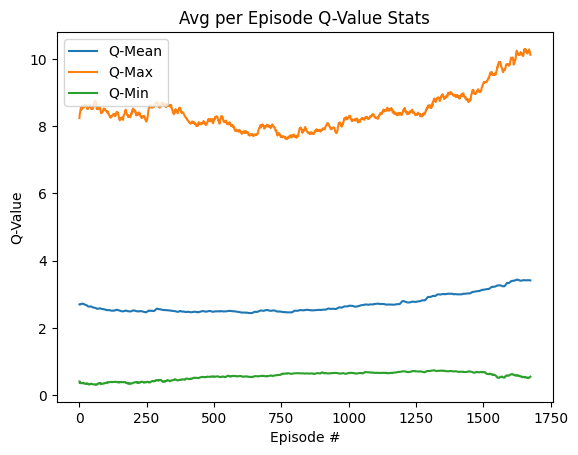

episode: 1676   frame: 382374   proc time: 115.5s   score: 7.0   memory length: 578350   epsilon: 0.1   steps: 241 steps/sec: 2.09   lr: 3.2000000000000005e-05   PER_beta: 0.7059 PER Alpha: 0.2941   reward MA: 5.04   mean loss: 0.01206   mean max Q: 10.0802
episode: 1677   frame: 382651   proc time: 132.8s   score: 4.0   memory length: 578622   epsilon: 0.1   steps: 277 steps/sec: 2.09   lr: 3.2000000000000005e-05   PER_beta: 0.70612 PER Alpha: 0.29388   reward MA: 4.96   mean loss: 0.01368   mean max Q: 10.0469
[PER STATS] TD-error mean: 0.07338701637557839 std: 0.13208481107393596 min: 0.0 max: 13.5703125
episode: 1678   frame: 383005   proc time: 171.7s   score: 10.0   memory length: 578971   epsilon: 0.1   steps: 354 steps/sec: 2.06   lr: 3.2000000000000005e-05   PER_beta: 0.7064 PER Alpha: 0.2936   reward MA: 5.08   mean loss: 0.01344   mean max Q: 10.0666
episode: 1679   frame: 383297   proc time: 141.8s   score: 5.0   memory length: 579258   epsilon: 0.1   steps: 292 steps/sec: 

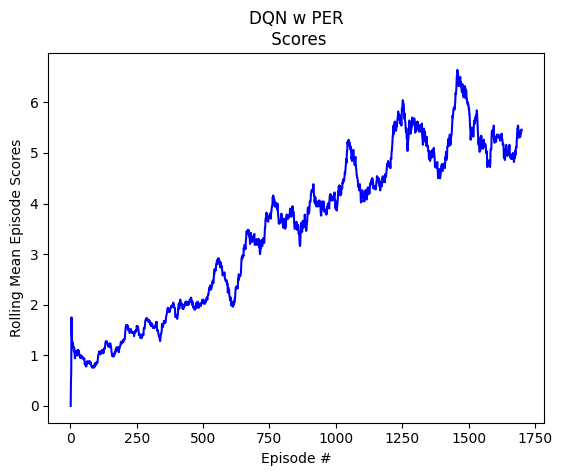

[SAVED PLOT] ./save_graph/run18/Run18_Bootstrapped_run17_stickyactions5percent_ep1700_losses.png


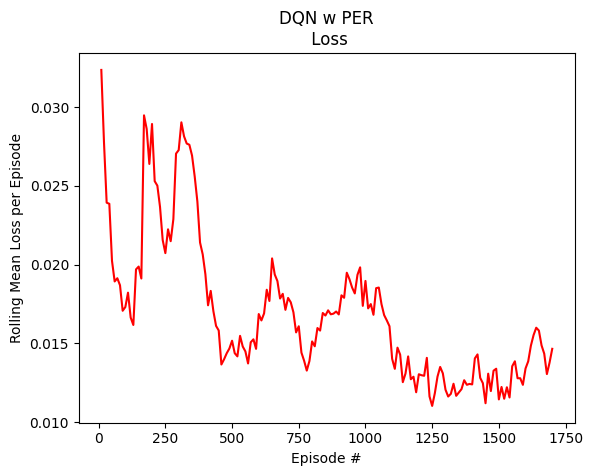

[SAVED PLOT] ./save_graph/run18/Run18_Bootstrapped_run17_stickyactions5percent_ep1700_Qstats.png


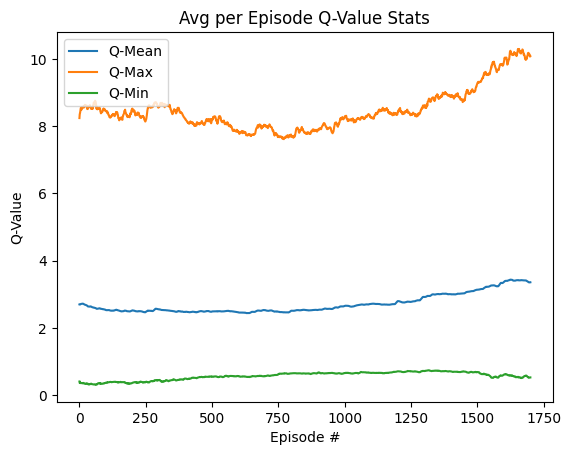

Checkpoint for episode 1700 saved
episode: 1701   frame: 389998   proc time: 126.5s   score: 4.0   memory length: 585849   epsilon: 0.1   steps: 241 steps/sec: 1.91   lr: 3.2000000000000005e-05   PER_beta: 0.712 PER Alpha: 0.288   reward MA: 5.38   mean loss: 0.0174   mean max Q: 10.0457
Target network updated at frame:  390000
[PER STATS] TD-error mean: 0.07257760796182995 std: 0.13044468538035164 min: 0.0 max: 12.484375
episode: 1702   frame: 390290   proc time: 152.2s   score: 4.0   memory length: 586136   epsilon: 0.1   steps: 292 steps/sec: 1.92   lr: 3.2000000000000005e-05   PER_beta: 0.71223 PER Alpha: 0.28777   reward MA: 5.38   mean loss: 0.01328   mean max Q: 9.9265
episode: 1703   frame: 390722   proc time: 224.3s   score: 11.0   memory length: 586563   epsilon: 0.1   steps: 432 steps/sec: 1.93   lr: 3.2000000000000005e-05   PER_beta: 0.71258 PER Alpha: 0.28742   reward MA: 5.54   mean loss: 0.01411   mean max Q: 10.1386
[PER STATS] TD-error mean: 0.07262016228679387 std: 0.

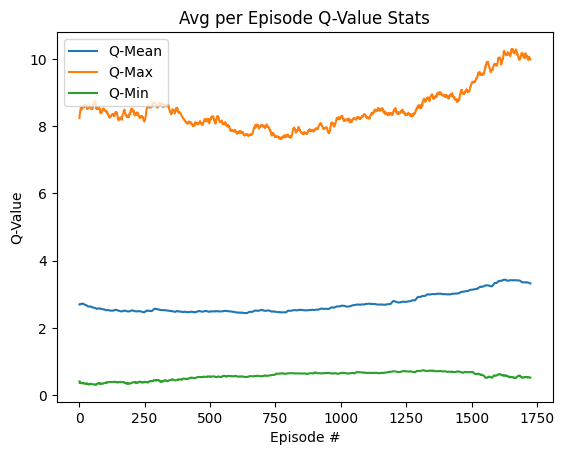

episode: 1726   frame: 397499   proc time: 162.5s   score: 9.0   memory length: 593225   epsilon: 0.1   steps: 306 steps/sec: 1.88   lr: 3.2000000000000005e-05   PER_beta: 0.718 PER Alpha: 0.282   reward MA: 5.92   mean loss: 0.01382   mean max Q: 9.977
episode: 1727   frame: 397777   proc time: 146.1s   score: 4.0   memory length: 593498   epsilon: 0.1   steps: 278 steps/sec: 1.9   lr: 3.2000000000000005e-05   PER_beta: 0.71822 PER Alpha: 0.28178   reward MA: 5.92   mean loss: 0.01362   mean max Q: 10.0387
[PER STATS] TD-error mean: 0.07211719670078544 std: 0.13072297430706137 min: 0.0 max: 11.52734375
episode: 1728   frame: 398024   proc time: 138.4s   score: 3.0   memory length: 593740   epsilon: 0.1   steps: 247 steps/sec: 1.78   lr: 3.2000000000000005e-05   PER_beta: 0.71842 PER Alpha: 0.28158   reward MA: 5.78   mean loss: 0.01295   mean max Q: 10.2912
episode: 1729   frame: 398265   proc time: 135.3s   score: 4.0   memory length: 593976   epsilon: 0.1   steps: 241 steps/sec: 1.7

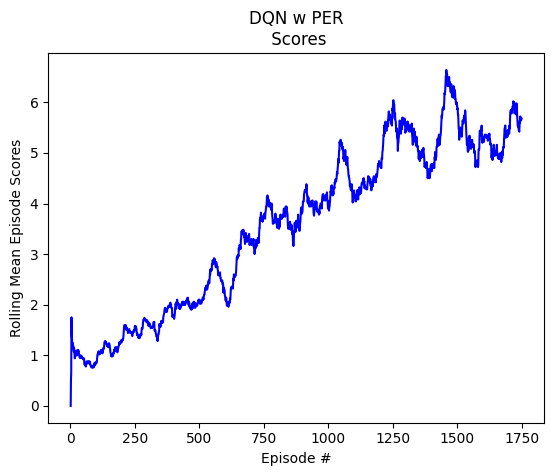

[SAVED PLOT] ./save_graph/run18/Run18_Bootstrapped_run17_stickyactions5percent_ep1750_losses.png


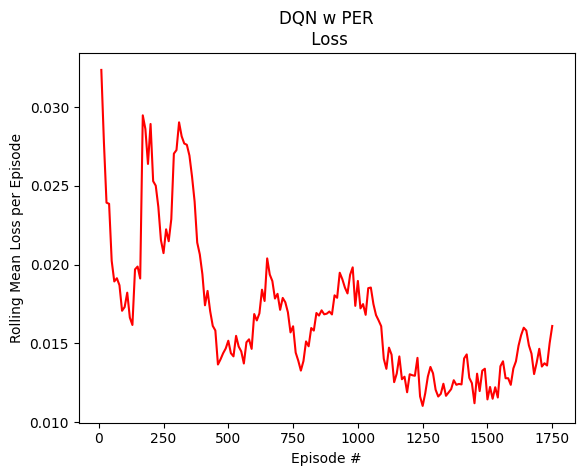

[SAVED PLOT] ./save_graph/run18/Run18_Bootstrapped_run17_stickyactions5percent_ep1750_Qstats.png


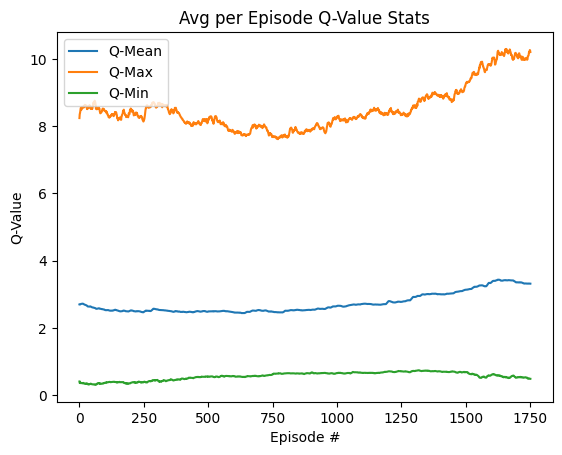

episode: 1751   frame: 404871   proc time: 166.9s   score: 5.0   memory length: 600472   epsilon: 0.1   steps: 294 steps/sec: 1.76   lr: 1.2800000000000003e-05   PER_beta: 0.7239 PER Alpha: 0.2761   reward MA: 5.7   mean loss: 0.01511   mean max Q: 10.5247
Target network updated at frame:  405000
[PER STATS] TD-error mean: 0.07477542789562505 std: 0.13648824235223192 min: 0.0 max: 11.21875
episode: 1752   frame: 405132   proc time: 334.0s   score: 4.0   memory length: 600728   epsilon: 0.1   steps: 261 steps/sec: 0.78   lr: 1.2800000000000003e-05   PER_beta: 0.72411 PER Alpha: 0.27589   reward MA: 5.7   mean loss: 0.01489   mean max Q: 9.8093
episode: 1753   frame: 405389   proc time: 477.6s   score: 4.0   memory length: 600980   epsilon: 0.1   steps: 257 steps/sec: 0.54   lr: 1.2800000000000003e-05   PER_beta: 0.72431 PER Alpha: 0.27569   reward MA: 5.56   mean loss: 0.01483   mean max Q: 10.0204
episode: 1754   frame: 405704   proc time: 174.3s   score: 4.0   memory length: 601290   

KeyboardInterrupt: 

In [15]:
from config import *
import time
# torch.set_float32_matmul_precision('high')

set_seed(seed)
run_num = "18"
name = "Bootstrapped_run17_stickyactions5percent"
run_name = "Run"+ str(run_num) + "_" + name


from config import *
from gymnasium.wrappers import RecordVideo

# choose which Agent to use
from agent import Agent

#create fresh environment
env = gym.make('ALE/Breakout-v5', frameskip=4, repeat_action_probability=sticky_action_prob, full_action_space=False, render_mode='rgb_array')  # Use equivalent parameters to BreakoutDeterministic-v4

# setup video recording
def video_trigger(_):
    if len(episodes) == 0:
        return False
    else:
        curr_ep = episodes[-1]
        return (curr_ep > 99 and curr_ep % 100 == 0) 

video_path = f"./videos/run{run_num}"
if not os.path.exists(video_path):
    os.makedirs(video_path)
env = RecordVideo(env, video_folder=video_path, episode_trigger=video_trigger)


print(f"Starting run {run_name}")
train_interval = 1
    
evaluation_reward = deque(maxlen=evaluation_reward_length)
rewards, episodes = [], []
reward = 0
best_eval_reward = curr_mean_reward = last_save_reward = 0

#initialize trackers
## LOSS TRACKERS ##
losses_window = deque(maxlen=10)
loss_history = []
episode_losses = []
loss = mean_loss = 0

# ## Q-VALUE TRACKERS ##
episode_q_means = []
episode_q_maxs = []
episode_q_mins = []
q_mean_window = deque(maxlen=10)
q_max_window = deque(maxlen=10)
q_min_window = deque(maxlen=10)
q_stats_history = {
    'mean': [],
    'max': [],
    'min': [],
    'episode': []
}


# Epsilon Bump Control Variables
plateau_patience = 300
episodes_since_improvement = 0
epsilon_bump = 0.15  # amount to re-increase epsilon
soonest_bump = 2000  # earliest episode to apply epsilon bump

frame = 0
ep_start = 0
training_started_flg = False

print("Instantiating agent")

### Bootstrapped loading run 17 ###
# mem_path = './checkpoints/Run17_StdDQN_750Kfr_newest_get_frame_CirularPER_wIS_159356_replay_buffer.pkl'
# checkpoint = torch.load('./checkpoints/Run17_StdDQN_750Kfr_newest_get_frame_CirularPER_wIS_2000_checkpoint.pt')
# agent = Agent(action_size, mem_path)  #use when starting with prefilled replay buffer

# # extend the loaded mem buffer capacity
# new_capacity = 1_000_000
# agent.memory.capacity = new_capacity
# agent.memory.memory.extend([None] * (new_capacity - len(agent.memory.memory)))
# agent.memory.valid_flags.extend([False] * (new_capacity - len(agent.memory.valid_flags)))
# assert len(agent.memory.memory) == len(agent.memory.valid_flags) == agent.memory.capacity == new_capacity
# assert sum(agent.memory.valid_flags) == len(agent.memory.valid_indices) == len(agent.memory.td_errors)
# print("Updated memory capacity to ", agent.memory.capacity)

# # Verify correct episilon
# print("epsilon max: ", agent.epsilon_max, "epsilon min: ", agent.epsilon_min, "epsilon_decay: ", agent.epsilon_decay)

# td_errors_np = np.array(agent.memory.td_errors, dtype=np.float32)

# # Print memory stats before
# num_invalid = np.sum(~np.isfinite(td_errors_np)) + np.sum(td_errors_np <= 0)
# print(f"[SANITIZER] Fixing {num_invalid} invalid or nonpositive TD-errors...")
# # Fix all issues
# td_errors_np = np.where(~np.isfinite(td_errors_np) | (td_errors_np <= 0), 1.0, td_errors_np)
# agent.memory._priority_cache_dirty = True
# # Convert back to list
# agent.memory.td_errors = td_errors_np.tolist()

# #load prior model weights
# agent.policy_net.load_state_dict(checkpoint['policy_net']) # load partially trained policy network weights
# agent.policy_net = torch.compile(agent.policy_net)
# print(agent.policy_net)
# print("Compiled:", isinstance(agent.policy_net, torch._dynamo.eval_frame.OptimizedModule))
# agent.target_net.load_state_dict(checkpoint['target_net'])

# agent.beta = IS_BETA
# agent.alpha = PER_ALPHA

### END BOOTSTRAPPING ####

# agent = Agent(action_size, mem_path)  
agent = Agent(action_size)

#########################
#### LOAD CHECKPOINT ####
# metadata = agent.load_checkpoint("Run8_Stdized_DDQN_750K_frames", 2999)  #Edit episode number
# frame = metadata['global_frame']
# agent.load_replay_buffer("Run8_Stdized_DDQN_750K_frames", 711354)
# ep_start = metadata['global_episode']
# evaluation_reward = metadata['eval_rewards']
# rewards = metadata['rewards']    
# episodes = metadata['episodes']
# losses_window = metadata['last_10_ep_losses']
# loss_history = metadata['loss_tracker']
# training_started_flg = True
########################


start_train_immediate = False
frame_max = TRAINING_STEPS
e = ep_start


while e < EPISODES:
    #limit number of frames for consistent testing
    if frame >= frame_max:
        break
    ep_start_time = time.time()
    done = False
    score = 0
    episode_losses = []
    history = np.zeros([5, 84, 84], dtype=np.uint8)
    step = 0
    state, _ = env.reset()
    next_state = state
    life = number_lives
    fire_ready = True
    no_reward_steps = 0

    get_init_state(history, state, HISTORY_SIZE)

    while not done:
        
        #limit number of frames for consitent testing
        if frame >= frame_max:
            break

        step += 1
        frame += 1

        # Selet Action (with robust check for FIRE action)
        if fire_ready:  
            next_state, force_done = reset_after_life_loss(env, history)
            if force_done:
                break
            action = 1
            fire_ready = False
        else:
            trainable_action = agent.get_action(np.float32(history[:4, :, :]) / 255.)
            action = TRAINABLE_ACTIONS[trainable_action]

        # Step the environment
        state = next_state
        next_state, reward, terminations, truncations, info = env.step(action)  
        done = truncations or terminations
        
        # Failsafe to force reset if no reward for 3000 steps (prevents agent from getting stuck)
        stuck_limit = 3000
        if no_reward_steps > stuck_limit:
            done = True
            print(f"[WARNING] No reward for {stuck_limit} steps, forcing reset | ", "Episode:", e, "  Frame:", frame, ) 
             
        frame_next_state = get_frame(next_state)
             
        # append next state to history
        history[4, :, :] = frame_next_state
        
        # life handling
        lost_life = check_live(life, info['lives'])  #check if the agent has lost a life
        if lost_life:
            fire_ready = True
        life = info['lives']
        
        r = reward
        if r == 0:
            no_reward_steps += 1
        else:
            no_reward_steps = 0 

        # Store the transition in replay buffer if it was not a FIRE action
        
        if action in TRAINABLE_ACTIONS:
            trainable_index = TRAINABLE_ACTIONS.index(action)
            term_state = done or lost_life
            if type(agent.memory).__name__ == "CircularReplayMemoryPER":
                # print("[DEBUG] Using CircularReplayMemoeryPER.push()")
                # agent.memory.push(agent, deepcopy(frame_next_state), trainable_index, r, term_state)  # for use when model is used to estimate new TD-errors
                mean_td = np.mean(agent.recent_td_errors) if len(agent.recent_td_errors) > 200 else 1.0
                agent.memory.push(frame_next_state.copy(), trainable_index, r, term_state, mean_recent_td_error=mean_td)
            else:
                agent.memory.push(frame_next_state.copy(), trainable_index, r, term_state)
        
        # Start training after random sample generation
        if training_started_flg == False and (frame == train_frame or (start_train_immediate and frame == 1)):
            print("Starting training")
            training_started_flg = True
            e = ep_start  #reset episode counter when training starts
        if(training_started_flg): 
            if frame % train_interval == 0: # Use adaptive training interval
                loss, q_stats = agent.train_policy_net()
                episode_losses.append(loss)
                episode_q_means.append(q_stats['q_mean'])
                episode_q_maxs.append(q_stats['q_max'])
                episode_q_mins.append(q_stats['q_min'])
            # Update the target network
            if (frame % (train_interval * update_target_network_frequency)) == 0:
                agent.update_target_net()
                print("Target network updated at frame: ", frame)
        
        # Update score and history
        score += reward
        history[:4, :, :] = history[1:, :, :]  # shift history by one erasing oldest frame

        ## DEBUG ##
        if frame % 1000 == 0 and len(agent.memory.td_errors) > 0:
            agent.memory.log_td_error_distribution()
            
        if done:
            e += 1
            fire_ready = True
            evaluation_reward.append(score)
            ep_duration = time.time() - ep_start_time            
            

            # print episode information every X episodes
            if e % 1 == 0:
                print("episode:", e, "  frame:", frame, "  proc time:", str(round(ep_duration, 1)) +'s', "  score:", score, "  memory length:",
                  len(agent.memory), "  epsilon:", round(agent.epsilon, 5), 
                  "  steps:", step,  "steps/sec:", round(step/ep_duration, 2), "  lr:", agent.optimizer.param_groups[0]['lr'], "  PER_beta:", round(agent.beta,5), "PER Alpha:", round(agent.alpha,5),
                  "  reward MA:", round(np.mean(evaluation_reward), 3), 
                  "  mean loss:", round(mean_loss, 5), "  mean max Q:", round(np.mean(episode_q_maxs), 4))
                #   "  latest step Q max:", round(q_stats['q_max'], 4))


            
            if training_started_flg:



                episodes.append(e)
                rewards.append(np.mean(evaluation_reward))  # record moving average of last evaluation_reward_length episodes

                # # adapt training interval to agent performance
                # if np.mean(evaluation_reward) < 8:
                #     train_interval = 4
                # elif np.mean(evaluation_reward) < 15:
                #     train_interval = 2
                # else:
                #     train_interval = 1

                ## DEBUG ##
                # Check TD-error distribution in Replay Buffer
                if e>0 and e % 100 == 0:
                    agent.memory.log_td_error_distribution()

                # save rolling loss everages every X episodes
                if episode_losses:
                    mean_loss = sum(episode_losses) / len(episode_losses)
                    losses_window.append(mean_loss)
                    if e > 9 and e % 10 == 0:
                        loss_history.append((np.mean(losses_window), e))

                # save rolling Q-score stat averages
                q_mean_window.append(np.mean(episode_q_means))
                q_max_window.append(np.mean(episode_q_maxs))
                q_min_window.append(np.mean(episode_q_mins))
                q_stats_history['mean'].append(np.mean(q_mean_window))
                q_stats_history['max'].append(np.mean(q_max_window))
                q_stats_history['min'].append(np.mean(q_min_window))
                q_stats_history['episode'].append(e)
                episode_q_means = []
                episode_q_maxs = []
                episode_q_mins = []

                # plot the rewards every X episodes
                if e > 0 and e % 50 == 0:
                    # clear_output(wait=True)
                    pylab.plot(episodes, rewards, 'b')
                    pylab.xlabel('Episode #')
                    pylab.ylabel('Rolling Mean Episode Scores') 
                    pylab.title('DQN w PER\n Scores')
                    plot_path = f"./save_graph/run{run_num}/{run_name}_ep{e}_scores.png"
                    os.makedirs(os.path.dirname(plot_path), exist_ok=True)
                    pylab.savefig(plot_path)
                    print(f"[SAVED PLOT] {plot_path}")
                    pylab.show()
                    pylab.close()
                
                # every X episodes, plot the mean losses
                if e > 0 and e % 50 == 0:
                    x = [entry[1] for entry in loss_history]
                    y = [entry[0] for entry in loss_history]
                    pylab.plot(x, y, 'r')
                    pylab.xlabel('Episode #')
                    pylab.ylabel('Rolling Mean Loss per Episode') 
                    pylab.title('DQN w PER\n Loss')
                    plot_path = f"./save_graph/run{run_num}/{run_name}_ep{e}_losses.png"
                    os.makedirs(os.path.dirname(plot_path), exist_ok=True)
                    pylab.savefig(plot_path)
                    print(f"[SAVED PLOT] {plot_path}")
                    pylab.show()
                    pylab.close()

                # plot Q-value statistics every X episodes
                if e > 0 and e % 25 == 0:
                    pylab.plot(q_stats_history['episode'], q_stats_history['mean'], label='Q-Mean')
                    pylab.plot(q_stats_history['episode'], q_stats_history['max'], label='Q-Max')
                    pylab.plot(q_stats_history['episode'], q_stats_history['min'], label='Q-Min')
                    pylab.xlabel('Episode #')
                    pylab.ylabel('Q-Value')
                    pylab.title('Avg per Episode Q-Value Stats')
                    pylab.legend(loc='upper left')
                    plot_path = f"./save_graph/run{run_num}/{run_name}_ep{e}_Qstats.png"
                    os.makedirs(os.path.dirname(plot_path), exist_ok=True)
                    pylab.savefig(plot_path)
                    print(f"[SAVED PLOT] {plot_path}")
                    pylab.show()
                    pylab.close()


                    ## DEBUG ##
                    # print(f"[PLOT DEBUG] Last 5 q_means: {q_stats_history['mean'][-5:]}")

                # Checkpoint the training process every X episodes 
                if e > 0 and e % 100 == 0:
                    metadata = create_metadata(agent, e, frame, evaluation_reward, rewards, episodes, losses_window, loss_history, q_stats_history, q_mean_window, \
                                               q_max_window, q_min_window, agent.epsilon, alpha=agent.alpha, beta=agent.beta)
                    agent.save_checkpoint(metadata, run_name, e)
                if e > 0 and e % 200 == 0:
                    agent.save_replay_buffer(run_name, frame)

                # Check if reward has improved
                curr_mean_reward = np.mean(evaluation_reward)
                if curr_mean_reward > best_eval_reward:
                    best_eval_reward = curr_mean_reward
                    episodes_since_improvement = 0
                else:
                    episodes_since_improvement += 1
                
                # save model if it is good
                if curr_mean_reward > 8 and curr_mean_reward > (1.05 * last_save_reward):
                    model_path = f"./save_model/run{run_num}/good_{run_name}_{e}_eps.pth"
                    os.makedirs(os.path.dirname(model_path), exist_ok=True)
                    torch.save(agent.policy_net.state_dict(), model_path)
                    print(f"[SAVED MODEL] {model_path}")
                    last_save_reward = curr_mean_reward
               
                # # # Apply epsilon bump if plateauing
                # if e > soonest_bump and episodes_since_improvement >= plateau_patience:
                #     if agent.epsilon < agent.epsilon_max:
                #         agent.epsilon = min(agent.epsilon + epsilon_bump, agent.epsilon_max)
                #         print(f"[BUMP] Epsilon bumped to {agent.epsilon:.4f} after {plateau_patience} stagnant episodes.")
                #     episodes_since_improvement = 0  # Reset counter after bump



# Checkpoint the model at the end of training loop
metadata = create_metadata(agent, e, frame, evaluation_reward, rewards, episodes, losses_window, loss_history, q_stats_history, q_mean_window, \
                            q_max_window, q_min_window, agent.epsilon, alpha=agent.alpha, beta=agent.beta)
agent.save_checkpoint(metadata, run_name, e)
agent.save_replay_buffer(run_name, frame)

print("Training complete")



In [ ]:

# === Load checkpoint files ===
ddqn_ckpt = torch.load("./checkpoints/Run12_DDQN_750K_frames_imprvdBatching_3007_checkpoint.pt")
dqn_ckpt  = torch.load("./checkpoints/Run13_StdDQN_750K_frames_imprvdBatching_2673_checkpoint.pt")

# === Extract metadata ===
ddqn_meta = ddqn_ckpt["metadata"]
dqn_meta = dqn_ckpt["metadata"]

# # === Extract episode indices and rolling mean rewards ===
# ddqn_episodes = ddqn_meta["episodes"]
# ddqn_rewards = ddqn_meta["rewards"]

# dqn_episodes = dqn_meta["episodes"]
# dqn_rewards = dqn_meta["rewards"]

# # === Plot ===
# plt.figure(figsize=(10, 6))
# plt.plot(dqn_episodes, dqn_rewards, label="DQN", color="red")
# plt.plot(ddqn_episodes, ddqn_rewards, label="DDQN", color="blue")
# plt.xlabel("Episode #", fontweight="bold")
# plt.ylabel("Mean Episode Score (Moving Avg)", fontweight="bold")
# plt.legend(loc = "upper left")
# # Main title
# pylab.text(0.5, 1.05, 'Std DQN vs DDQN Scores',
#            ha='center', va='bottom', transform=pylab.gca().transAxes,
#            fontsize=14, fontweight='semibold')

# # Subtitle (smaller font)
# pylab.text(0.5, 1.01, '(750K training steps)',
#            ha='center', va='bottom', transform=pylab.gca().transAxes,
#            fontsize=10, color='gray')


# plot_path = f"./presentation_assets/DQN_vs_DDQN_750K_steps_SCORES.png"
# os.makedirs(os.path.dirname(plot_path), exist_ok=True)
# pylab.savefig(plot_path, bbox_inches='tight')
# print(f"[SAVED PLOT] {plot_path}")
# plt.show()


# # === Extract loss data ===
ddqn_loss_history = ddqn_meta["loss_tracker"]
dqn_loss_history = dqn_meta["loss_tracker"]

ddqn_episodes = [entry[1] for entry in ddqn_loss_history]
ddqn_losses = [entry[0] for entry in ddqn_loss_history]

dqn_episodes = [entry[1] for entry in dqn_loss_history]
dqn_losses = [entry[0] for entry in dqn_loss_history]

# === Plot ===
plt.figure(figsize=(10, 6))
plt.plot(dqn_episodes, dqn_losses, label="DQN", color="red")
plt.plot(ddqn_episodes, ddqn_losses, label="DDQN", color="blue")
plt.xlabel("Episode #", fontweight="bold")
plt.ylabel("Mean Episode Loss (Moving Avg)", fontweight="bold")
plt.legend(loc = "best")
# Main title
pylab.text(0.5, 1.05, 'Std DQN vs DDQN Huber Loss',
           ha='center', va='bottom', transform=pylab.gca().transAxes,
           fontsize=14, fontweight='semibold')

# Subtitle (smaller font)
pylab.text(0.5, 1.01, '(750K training steps)',
           ha='center', va='bottom', transform=pylab.gca().transAxes,
           fontsize=10, color='gray')


plot_path = f"./presentation_assets/DQN_vs_DDQN_750K_steps_LOSSES.png"
os.makedirs(os.path.dirname(plot_path), exist_ok=True)
pylab.savefig(plot_path, bbox_inches='tight')
print(f"[SAVED PLOT] {plot_path}")
plt.show()


### ONNX Visualization
The code below can be used to generate an ONNX file that can be imported to https://netron.app/ to produce a visual diagram of a nework architecture

In [ ]:
# chkpt = torch.load("./checkpoints/Run12_DDQN_750K_frames_imprvdBatching_3007_checkpoint.pt")
from model import DQN_DualBranch
action_size = len(TRAINABLE_ACTIONS)
model = DQN_DualBranch(action_size)
model.eval()

#create dummy input for model
dummy_input = torch.rand(BATCH_SIZE, 6, 84, 84)

#export to ONNX
torch.onnx.export(model, dummy_input, "Branched Network.onnx",
                  input_names=["input"], output_names=["output"],
                  dynamic_axes={"input": {0: "batch_size"}, "output": {0: "batch_size"}},
                  opset_version=11)

print("ONNX model exported successfully!")


# Visualize Agent Performance

BE AWARE THIS CODE BELOW MAY CRASH THE KERNEL IF YOU RUN THE SAME CELL TWICE.

Please save your model before running this portion of the code.

### Play Game in Window or Save Video

In [ ]:
import gymnasium as gym
from gymnasium.wrappers import RecordVideo

# set random seed to sync visual and recorded game
seed = 55
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)

# Load and setup Agent
print("Instantiating agent")
agent = Agent(action_size)
agent.load_policy_net("./save_model/run3/good_Run3_DDQN_Serial_InvTimeEpsilon_ddqn_886_eps.pth")
agent.policy_net.eval()
agent.epsilon = 0  # Set agent to only exploit the best action


# Create environments
env_human = gym.make('ALE/Breakout-v5', frameskip=4, repeat_action_probability=sticky_action_prob, full_action_space=False, render_mode="human")
# env_record = RecordVideo(env_record, video_folder="./videos", episode_trigger=lambda e: True)

# Reset to seed
state_h, _ = env_human.reset(seed=seed)
state_h = do_random_actions(env_human, 20)


# Setup History
history = np.zeros([HISTORY_SIZE + 1, 84, 84], dtype=np.uint8)
get_init_state(history, state_h, HISTORY_SIZE)

done = False
fire_ready = True
life = number_lives
score = 0
step = 0

while not done:
    step += 1

    # Select action
    if fire_ready:
        print(f"[DEBUG] Agent is not acting — sending FIRE at step {step}")
        action = 1
        fire_ready = False
    else:
        model_action = agent.get_action(np.float32(history[:4, :, :]) / 255.)
        action = TRAINABLE_ACTIONS[model_action]

    # Step the environment
    state_h, reward, term_h, trunc_h, info = env_human.step(action)
    done = term_h or trunc_h

    # update history
    frame_next_state = get_frame(state_h)
    history[4, :, :] = frame_next_state
    history[:4, :, :] = history[1:, :, :]  #shift history by one erasing oldest frame
    
    # check if life has been lost
    lost_life = check_live(life, info['lives'])  #check if the agent has lost a life
    if lost_life:
        print(f"[DEBUG] Lost life detected at step {step}")
        fire_ready = True
    life = info['lives']
    
    # keep track of score
    score += reward # update total score

    
env_human.close()


### Play Game Rendered in Jupyter Notebook

In [ ]:
from IPython.display import display as ipythondisplay, clear_output

def show_state_live(frame, step=0, info=""):
    plt.figure(3)
    plt.clf()
    plt.imshow(frame)
    plt.title(f"Step: {step} {info}")
    plt.axis('off')
    clear_output(wait=True)
    ipythondisplay(plt.gcf())

In [ ]:
import gymnasium as gym
from gymnasium.wrappers import RecordVideo


# set random seed to sync visual and recorded game
seed = 42
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)

# Load and setup Agent
# Choose whether to use double DQN
double_dqn = False # set to True if using double DQN agent
if double_dqn:
    from agent_double import Agent
else:
    from agent import Agent

#Initialize agent
print("Instantiating agent")
agent = Agent(action_size)
agent.load_policy_net("./save_model/Run1_serial/good_breakout_dqn_1256_eps.pth")
agent.policy_net.eval()
agent.epsilon = 0  # Set agent to only exploit the best action


# Create environments
env = gym.make('ALE/Breakout-v5', frameskip=4, repeat_action_probability=sticky_action_prob, full_action_space=False, render_mode="rgb_array")
# Use RecordVideo to save the video to the "videos" directory
# env = RecordVideo(env, video_folder="./videos", episode_trigger=lambda episode_id: True)

# Reset the environment
state, _ = env.reset(seed=seed)

# Setup History
history = np.zeros([HISTORY_SIZE + 1, 84, 84], dtype=np.uint8)
get_init_state(history, state, HISTORY_SIZE)

#Initialize variables
step = 0
done = False
fire_ready = True
life = number_lives
score = 0

while not done:

    # Render the current frame live in the notebook
    show_state_live(state, step)   

    # Select action
    if fire_ready:
        action = 1
        fire_ready = False
    else:
        model_action = agent.get_action(np.float32(history[:4, :, :]) / 255.)
        action = TRAINABLE_ACTIONS[model_action]

    # Step the environment
    next_state, reward, term, trunc, info = env.step(action)
    done = term or trunc

    # update history
    frame_next_state = get_frame(state)
    history[4, :, :] = frame_next_state
    history[:4, :, :] = history[1:, :, :]  #shift history by one erasing oldest frame
    
    # check if life has been lost
    lost_life = check_live(life, info['lives'])  #check if the agent has lost a life
    if lost_life:
        fire_ready = True  
        # do_random_actions(env_human, 30) #IMPT: introduce randomness to game and paddle position before next life
    life = info['lives']
    
    # keep track of score
    score += reward # update total score

    state = next_state
    step += 1

    

env.close()

## Model Results Comparison Tester

In [ ]:
from utils import *
from config import *
import gymnasium as gym



# Load and setup Agent
# Choose which agent class to load
from agent import Agent
# from agent_timediff import Agent

# 50 unique, fixed seeds
seeds = [765,817,53,705,990,511,236,661,654,418,804,968,1,749,125,293,985,574, 
         447,948,687,317,280,645,927,842,309,616,717,930,778,323,595,798,195,11,
         483,316,690,951,196,307,906,558,516,844,410,965,371,886]


#Initialize agent
print("Instantiating agent")
agent = Agent(action_size)
# agent.load_policy_net("./save_model/run12/good_Run12_DDQN_750K_frames_imprvdBatching_2319_eps.pth")
agent.load_policy_net("./save_model/run13/good_Run13_StdDQN_750K_frames_imprvdBatching_2477_eps.pth")
# agent.load_policy_net("./save_model/run14/good_Run14_StdDQN_750Kfr_timediff_new_get_frame_2425_eps.pth")
agent.target_net.load_state_dict(agent.policy_net.state_dict())
agent.target_net.eval()
agent.policy_net.eval()
agent.epsilon = 0.05  # Set agent to use model action 95% of the time for robustness


# Create environments
env = gym.make('ALE/Breakout-v5', frameskip=4, repeat_action_probability=0.0, full_action_space=False, render_mode="rgb_array")
# Use RecordVideo to save the video to the "videos" directory
# video_path = f"./videos/testing/run13"
# if not os.path.exists(video_path):
#     os.makedirs(video_path)
# env = RecordVideo(env, video_folder=video_path, episode_trigger=lambda e: True)


scores = []

for e, seed in enumerate(seeds):
    set_seed(seed)
    # Reset the environment
    state, _ = env.reset(seed=seed)

    # Setup History
    history = np.zeros([HISTORY_SIZE + 1, 84, 84], dtype=np.uint8)
    get_init_state(history, state, HISTORY_SIZE)  #non cropped version
    # new_get_init_state(history, state, HISTORY_SIZE)  #cropped version

    #Initialize variables
    step = 0
    done = False
    fire_ready = True
    life = number_lives
    score = 0

    while not done:
        
        # Selet Action (with robust check for FIRE action)
        if fire_ready:
            next_state, force_done = reset_after_life_loss(env, history)
            if force_done:
                break
            action = 1
            fire_ready = False
        else:
            trainable_action = agent.get_action(np.float32(history[:4, :, :]) / 255.)
            action = TRAINABLE_ACTIONS[trainable_action]

        # Step the environment
    
        next_state, reward, term, trunc, info = env.step(action)
        done = term or trunc
        # update total score
        score += reward 

        # update history
        history[4, :, :] = get_frame(next_state)  #non cropped version
        # history[4, :, :] = new_get_frame(next_state)  #cropped version
        history[:4, :, :] = history[1:, :, :]  #shift history by one erasing oldest frame
        
        # check if life has been lost
        lost_life = check_live(life, info['lives'])  #check if the agent has lost a life
        if lost_life:
            fire_ready = True  
        life = info['lives']
        
        
        step += 1
    
    print("episode:", e, "  seed:", seed, "  score:", score, "  epsilon:", round(agent.epsilon, 5), 
    "  steps:", step)
    
    scores.append(score)

env.close()
print("Mean Score: ", np.mean(scores))
print("Std Score: ", np.std(scores))
print("Max Score: ", np.max(scores))
print("Min Score: ", np.min(scores))
print("Median Score: ", np.median(scores))

env.close()

### Debug Harnesses

In [ ]:
import numpy as np
import random
import memory as mem

# Use a small capacity for easy debugging
capacity = 10
history_size = 3
memory = mem.CircularReplayMemoryPER(capacity, history_size)

# Push 30 fake transitions (will cause multiple wraps)
for step in range(30):
    frame = np.ones((84, 84), dtype=np.uint8) * step
    action = random.randint(0, 3)
    reward = random.random()
    done = (step % 7 == 0)  # Random done flag every few steps

    memory.push(frame, action, reward, done)

    num_flags = sum(memory.valid_flags)
    num_indices = len(memory.valid_indices)

    if num_flags != num_indices:
        print(f"❌ Mismatch at step {step}:")
        print(f"   valid_flags count = {num_flags}")
        print(f"   valid_indices count = {num_indices}")
        print(f"   position = {memory.position}")
        print(f"   size = {memory.size}")
        print(f"   flags: {memory.valid_flags}")
        print(f"   valid_indices: {memory.valid_indices}")
        raise AssertionError("valid_flags and valid_indices out of sync")

print("✅ All checks passed — valid_flags == valid_indices through all pushes.")


In [ ]:
import memory as RepBuff
import traceback

# Configuration
capacity = 1000
history_size = 4
batch_size = 32


# Configuration
capacity = 1000
history_size = 4
batch_size = 16
alpha = 0.6

# Initialize memory
memory = RepBuff.CircularReplayMemoryPER(capacity=capacity, history_size=history_size)

# Track previous cache values for comparison
previous_probs = None

# Simulate a bunch of pushes
for step in range(1500):
    print(f"Step {step}, ")
    frame = np.ones((84, 84), dtype=np.uint8) * step
    action = random.randint(0, 3)
    reward = random.random()
    done = (step % 50 == 0)


    memory.push(frame, action, reward, done)

    # Occasionally update TD-errors
    if step > 100 and len(memory.valid_indices) >= batch_size:
        indices = random.sample(range(len(memory.valid_indices)), min(len(memory.valid_indices), batch_size))
        print(len(indices))
        new_td = np.random.rand(batch_size).astype(np.float32)
        memory.update_td_errors(indices, new_td)

    # Check probability stability and cache correctness
    if len(memory.valid_indices) >= batch_size:
        try:
            # Trigger cache update and record internal state
            probs = memory.get_sampling_probs(memory.valid_indices)
            total_prob = probs.sum()

            # Cache sanity checks
            assert hasattr(memory, "_cached_probs"), "Missing cached_probs"
            assert memory._cached_probs is not None, "Cached probs not populated"
            assert np.allclose(memory._cached_probs.sum(), 1.0, atol=1e-4), "Cached probs do not sum to 1"

            # Compare with previous cache state
            if previous_probs is not None:
                if np.array_equal(previous_probs, memory._cached_probs):
                    print(f"[DEBUG] Cache unchanged at step {step} — may be okay if no new TDs pushed")
                else:
                    print(f"[DEBUG] Cache updated at step {step}")
            previous_probs = memory._cached_probs.copy()

            if np.isnan(total_prob) or total_prob == 0:
                print("[ERROR] Total probability is invalid at step:", step)
                print("TD errors:", [memory.td_errors[i] for i in memory.valid_indices[:10]])
                print("Sampling probs:", probs[:10])
                raise AssertionError("Invalid sampling distribution")

        except Exception as e:
            print("[EXCEPTION]", str(e))
            traceback.print_exc()
            break

print("✅ Debug harness completed without total_priority = 0 and with valid cache behavior")
